In [1]:
# package(s) related to time, space and id
import datetime, time
import os
import io
import functools
import logging
import pickle
import random
import math

# package(s) related to the simulation
import enum
import simpy
import scipy as sc
import math
import networkx as nx  
import numpy as np
import pandas as pd
import re
import yaml as yaml
import time
import bisect
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import xarray as xr

from osgeo import gdal
from scipy import interpolate
from scipy.signal import correlate
from shapely.ops import transform,split,snap
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# OpenTNSim
from opentnsim import core
from opentnsim import plot
from opentnsim import model
from opentnsim import import_hydrodynamic_dataset
from opentnsim import vessel_traffic_service
from opentnsim import port
from opentnsim import lock
from opentnsim import vessel
from opentnsim import waterway
from opentnsim import output
from opentnsim import tidal_window_constructor
from opentnsim import rule_constructor
from opentnsim import regulations

# spatial libraries 
import shapely.geometry
from shapely.geometry import Point
import shapely.wkt
import pyproj
import folium
import datetime
import time as timepy

# package(s) for data handling
import requests

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

# define the coorinate systemb
geod = pyproj.Geod(ellps="WGS84")

location_vessel_database = "Vessels/richtlijnen-vaarwegen-2017.csv"

In [2]:
wgs = pyproj.CRS('EPSG:4326')
utm = pyproj.CRS('EPSG:28992')
wgs_to_utm = pyproj.Transformer.from_crs(wgs,utm,always_xy=True).transform
utm_to_wgs = pyproj.Transformer.from_crs(utm,wgs,always_xy=True).transform

In [3]:
starting_hour = 1000/(60*60*4)
next_hours = np.arange(0.25,12.25,0.25)
hours = np.append(np.array([starting_hour]),next_hours)

In [4]:
Node = type('Site', (core.Identifiable, core.Log, core.Locatable, core.HasResource), {})
nodes = []
path = []
coords = []

for hour in reversed(hours):
    coords.append(transform(utm_to_wgs,Point(155000-hour*60*60*4,463000)))
for hour in hours:
    coords.append(transform(utm_to_wgs,Point(155000+hour*60*60*4,463000)))

for index,coord in enumerate(coords):
    data_node = {"env": [],
                 "name": "Node_" + str(index+1),
                 "geometry": coord}
    node = Node(**data_node)
    nodes.append(node)
    
for i in range(len(nodes)-1):
    path.append([nodes[i],nodes[i+1]]) 
    path.append([nodes[i+1],nodes[i]])

FG = nx.MultiDiGraph()

positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

for edge in path:
    geometry = shapely.geometry.LineString([FG.nodes[edge[0].name]['geometry'],FG.nodes[edge[1].name]['geometry']])
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {},geometry=geometry)
    
for node in FG.nodes:
    FG.nodes[node]['Info'] = {}

In [5]:
for node in FG.nodes:
    FG.nodes[node]['geometry'] = transform(wgs_to_utm,FG.nodes[node]['geometry'])
    
for edge in FG.edges:
    geometry = transform(wgs_to_utm,FG.edges[edge]['geometry'])
    length = int(geometry.length)
    FG.edges[edge]['geometry'] = geometry
    FG.edges[edge]['Info']['geometry'] = geometry
    FG.edges[edge]['Info']['length'] = length

In [6]:
import pytz
simulation_start = datetime.datetime(2019,1,1,0,0,0)
duration = datetime.timedelta(seconds=14*24*60*60) #seconds

In [7]:
water_level = []
salinity = []

for nodes in enumerate(FG.nodes):
    water_level.append([[],[]])
    salinity.append([[],[]])

MBL = [11]*len(FG.nodes)
depth = MBL
times = np.arange(simulation_start,simulation_start+duration,datetime.timedelta(seconds=10*60))
stations = list(FG.nodes)

sea = True
for index,node in enumerate(list(FG.nodes)):
    if sea:
        water_level[index]=[1.0*np.sin(2*np.pi*((t-np.datetime64(0,'s'))/np.timedelta64(1, 's')-simulation_start.timestamp())/45000) for t in times]
        salinity[index]=[25.0 for t in times]
        if node == 'Node_49':
            sea = False
    else:
        water_level[index]=[0.0 for t in times]
        salinity[index]=[0.0 for t in times]

In [8]:
import xarray as xr
station_data = xr.DataArray(data=stations,
                         dims=["STATIONS"])

time_data = xr.DataArray(data=times,
                         dims=["TIME"])

MBL_data = xr.DataArray(data=MBL,
                        dims=["STATIONS"])

depth_data = xr.DataArray(data=depth,
                          dims=["STATIONS"])

water_level_data = xr.DataArray(data=[wlev for wlev in water_level],
                                dims=["STATIONS","TIME"])

salinity_data = xr.DataArray(data=[sal for sal in salinity],
                             dims=["STATIONS","TIME"])

hydrodynamic_data = xr.Dataset({'TIME':times,
                                'Stations':station_data,
                                'MBL':MBL_data,
                                'Depth':depth_data,
                                'Water level': water_level_data,
                                'Salinity':salinity_data})

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_29164\3095883058.py:5: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_29164\3095883058.py:20: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by con

In [9]:
sim = model.Simulation(graph=FG,simulation_start=simulation_start,simulation_duration=duration,hydrodynamic_data=hydrodynamic_data)
env = sim.environment

In [10]:
sim.environment.vessel_traffic_service

In [11]:
lock_1 = lock.IsLock(env = sim.environment, 
                     name = 'Lock',
                     distance_doors1_from_first_waiting_area=750,   
                     distance_doors2_from_second_waiting_area=FG.edges['Node_49','Node_50',0]['Info']['length']-1250,
                     node_doors1 = 'Node_49', node_doors2 = 'Node_50',time_step=60,
                     lock_length = 500, lock_width = 40, lock_depth = 10.5, 
                     doors_open = 600, doors_close = 600, disch_coeff = 0.8,
                     opening_area = 4.0, opening_depth = 5.0,node_open='Node_50',detector_nodes=['Node_49','Node_50'],priority_rules = regulations.ConditionalRule('start_node','==','Node_50'))

lineup_area_1 = lock.IsLockLineUpArea(env = sim.environment, name = 'Lock', distance_to_lock_doors = 100,
                                      start_node = 'Node_49',end_node = 'Node_50', lineup_length = 500)

lineup_area_2 = lock.IsLockLineUpArea(env = sim.environment, name = "Lock", distance_to_lock_doors = 100,
                                      start_node = 'Node_50',end_node = 'Node_49', lineup_length = 500)

waiting_area_1 = lock.IsLockWaitingArea(env = sim.environment, name = 'Lock', distance_from_node=0,
                                        node = 'Node_49')
    
waiting_area_2 = lock.IsLockWaitingArea(env = sim.environment, name = "Lock", distance_from_node=0,
                                        node = 'Node_50')

c:\users\floorbakker\opentnsim\opentnsim\lock.py:343: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



In [12]:
Vessel = type('Vessel', 
              (core.SimpyObject, core.Identifiable, lock.HasWaitingArea, lock.HasLock, lock.HasLineUpArea, core.Movable, vessel.VesselProperties, output.HasOutput, vessel.ExtraMetadata), {})

In [13]:
def create_vessel(name,FG,origin,destination,length,beam,draught,height,v,arrival_time):
    vessel_input = { "name":name,
                     "geometry":FG.nodes[origin]['geometry'],
                     "origin":origin,
                     "destination":destination,
                     #"next_destination":next_destination,
                     "route":nx.dijkstra_path(FG,origin,destination),
                     "env":env,
                     "type":'Tanker',
                     "B":beam,
                     "L":length,
                     "T": draught,
                     "H":height,
                     #"t_berthing":berthing_time.total_seconds(),
                     #"t_(un)loading":[time.total_seconds() for time in unloading_time],
                     #"t_turning":[time.total_seconds() for time in turning_time],
                     #"ukc":ukc,
                     "v":v,
                     #"terminal_of_call": terminal_of_call,
                     #"berth_of_call": berth_of_call,
                     #"(un)loading": delta_draught,
                     #"max_waiting_time":datetime.timedelta(days=10).total_seconds(),
                     #"max_cross_current":max_cross_current,
                     "arrival_time":arrival_time,
                     #"arrival_delay":arrival_time,
                     #"priority": 0,
                     #"additional_waiting_time": additional_waiting_time/np.timedelta64(1, 's'),
                     #"bound":bound,
                     #"priority":False
                   }
    return vessel_input

In [14]:
random.seed(0)
month_reached = False
arrival_time = sim.environment.simulation_start
vessel_index = 0
while not month_reached:
    arrival_time += pd.Timedelta(random.uniform(0,4),'h')
    created_vessel = Vessel(**create_vessel(name = f'inbound_vessel_{vessel_index}',
                                            FG = FG,
                                            origin='Node_1',
                                            destination='Node_98',
                                            length=200,
                                            beam=35,
                                            draught=10,
                                            height=5,
                                            v=4,
                                            arrival_time=arrival_time))
    sim.add_vessels(vessel=created_vessel)
    vessel_index += 1
    if arrival_time > sim.environment.simulation_start + datetime.timedelta(days=14):
        month_reached = True

month_reached = False
arrival_time = sim.environment.simulation_start
vessel_index = 0
while not month_reached:
    arrival_time += pd.Timedelta(random.uniform(0,4),'h')
    created_vessel = Vessel(**create_vessel(name = f'outbound_vessel_{vessel_index}',
                                            FG = FG,
                                            origin='Node_98',
                                            destination='Node_1',
                                            length=200,
                                            beam=35,
                                            draught=10,
                                            height=5,
                                            v=4,
                                            arrival_time=arrival_time))
    sim.add_vessels(vessel=created_vessel)
    vessel_index += 1
    if arrival_time > sim.environment.simulation_start + datetime.timedelta(days=14):
        month_reached = True
    

In [15]:
waiting_area_1.resource.users

[]

In [16]:
t1 = timepy.time()
sim.run()
t2 = timepy.time()
print(t2-t1)

outbound_vessel_0
outbound_vessel_1
inbound_vessel_0
outbound_vessel_2
inbound_vessel_1
inbound_vessel_2
outbound_vessel_3
inbound_vessel_3
outbound_vessel_4
outbound_vessel_5
hi got outbound_vessel_0 2019-01-01 12:57:23.438305 300
haiii outbound_vessel_0
haiii outbound_vessel_0
outbound_vessel_0 start waiting time 2019-01-01 13:00:14.271638 300
claim the lock doors outbound_vessel_0 2019-01-01 13:00:14.271638
formal request 1
lock is empty and not converting hihi haha ho ho ho outbound_vessel_0 2019-01-01 13:00:14.271638 0 1
outbound_vessel_0 0
lock doors claimed outbound_vessel_0 2019-01-01 13:00:14.271638
outbound_vessel_0 sail to assigned lock position
inbound_vessel_4
left doors1 outbound_vessel_0 2019-01-01 13:11:20.938305 0 [] ['outbound_vessel_0']
print doors outbound_vessel_0 ['outbound_vessel_0'] []
outbound_vessel_0 in lock ['outbound_vessel_0']
outbound_vessel_0 converting hap 2019-01-01 13:11:20.938305
hi 2019-01-01 13:11:20.938305
2019-01-01 13:11:20.938305 Node_50 Node_4

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_6
outbound_vessel_0 hap is geconvert 2019-01-01 14:05:20.938305
300
500
300
left lock outbound_vessel_0 2019-01-01 14:05:20.938305
leave lock outbound_vessel_0 0
500 back
left doors2 outbound_vessel_0 2019-01-01 14:09:42.049416 0 [] []
hi got outbound_vessel_1 2019-01-01 15:02:23.901914 300
outbound_vessel_1 empty lock conversion while approaching 2019-01-01 15:02:23.901914
empty conversion requested outbound_vessel_1 2019-01-01 15:02:23.901914
heyoos
hi 2019-01-01 15:02:23.901914
2019-01-01 15:02:23.901914 Node_49 Node_50 Lock doors closing start
door open 830 897 4023.901913881302
len time 68 2019-01-01T13:50:00.000000000
3.2868106070971006
4.247927117565128
5.202125656619936
6.146071100822329
7.076572766353959
7.9906257951652195
8.885447190482859
9.758505678606719
10.60754485906618
11.43059939752164
12.226004296965991
12.992397537041517
13.728716586505172
14.434189462130458
15.108321125004078
15.7508760725938
16.36185800576084
16.941487430145084
17.49017799868431
18.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

empty conversion done outbound_vessel_1 2019-01-01 15:02:23.901914
haiii outbound_vessel_1
haiii outbound_vessel_1
outbound_vessel_1 start waiting time 2019-01-01 15:05:14.735247 300
claim the lock doors outbound_vessel_1 2019-01-01 15:05:14.735247
hi got inbound_vessel_0 2019-01-01 15:18:29.674661 300
haiii inbound_vessel_0
haiii inbound_vessel_0
inbound_vessel_0 start waiting time 2019-01-01 15:21:20.507994 300
claim the lock doors inbound_vessel_0 2019-01-01 15:21:20.507994
approach node != node open 2019-01-01 15:21:20.507994 []
requesting approach: else inbound_vessel_0 2019-01-01 15:21:20.507994 0 ['outbound_vessel_1'] []
doors request inbound_vessel_0 2019-01-01 15:21:20.507994
formal request 1
lock is empty and not converting hihi haha ho ho ho outbound_vessel_1 2019-01-01 16:00:23 0 1
outbound_vessel_1 0
lock doors claimed outbound_vessel_1 2019-01-01 16:00:23
outbound_vessel_1 sail to assigned lock position
left doors1 outbound_vessel_1 2019-01-01 16:11:29.666667 0 [] ['outbo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_5
outbound_vessel_1 hap is geconvert 2019-01-01 17:00:29.666667
300
500
300
left lock outbound_vessel_1 2019-01-01 17:00:29.666667
leave lock outbound_vessel_1 0
500 back
left doors2 outbound_vessel_1 2019-01-01 17:04:50.777778 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_0 2019-01-01 17:04:50.777778
inbound_vessel_0 sail to assigned lock position
left doors1 inbound_vessel_0 2019-01-01 17:15:57.444445 [] 1 ['inbound_vessel_0']
print doors inbound_vessel_0 [] ['inbound_vessel_0']
inbound_vessel_0 in lock ['inbound_vessel_0']
inbound_vessel_0 converting hap 2019-01-01 17:15:57.444445
hi 2019-01-01 17:15:57.444445
2019-01-01 17:15:57.444445 Node_49 Node_50 Lock doors closing start
door open 1015 1041 1528.444444656372
len time 26 2019-01-01T16:55:00.000000000
14.078917444019286
14.40782367595424
14.735604519541784
15.061706884203259
15.385589048119071
15.70672419267787
16.02460372631659
16.338740354842496
16.648670861290476
16.95395856502668
17.254195436934

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_7
hi got outbound_vessel_2 2019-01-01 17:37:11.047553 300
haiii outbound_vessel_2
haiii outbound_vessel_2
outbound_vessel_2 start waiting time 2019-01-01 17:40:01.880886 300
claim the lock doors outbound_vessel_2 2019-01-01 17:40:01.880886
lock not empty outbound_vessel_2 2019-01-01 17:40:01.880886 ['inbound_vessel_0']
lock is not empty (may be converting) outbound_vessel_2 2019-01-01 17:40:01.880886 True
inbound_vessel_0 hap is geconvert 2019-01-01 17:42:57.444445
300
500
300
left lock inbound_vessel_0 2019-01-01 17:42:57.444445
leave lock inbound_vessel_0 0
500 back
left doors2 inbound_vessel_0 2019-01-01 17:47:18.555556 1 [] []
requested first set of doors outbound_vessel_2 2019-01-01 17:47:18.555556
lock doors claimed outbound_vessel_2 2019-01-01 17:47:18.555556
outbound_vessel_2 sail to assigned lock position
left doors1 outbound_vessel_2 2019-01-01 17:58:25.222223 0 [] ['outbound_vessel_2']
print doors outbound_vessel_2 ['outbound_vessel_2'] []
outbound_vessel_2 i

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_2 hap is geconvert 2019-01-01 18:30:25.222223
300
500
300
left lock outbound_vessel_2 2019-01-01 18:30:25.222223
leave lock outbound_vessel_2 0
500 back
left doors2 outbound_vessel_2 2019-01-01 18:34:46.333334 0 [] []
hi got inbound_vessel_1 2019-01-01 18:52:09.187121 300
haiii inbound_vessel_1
haiii inbound_vessel_1
inbound_vessel_1 start waiting time 2019-01-01 18:55:00.020454 300
claim the lock doors inbound_vessel_1 2019-01-01 18:55:00.020454
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_1 2019-01-01 18:55:00.020454 0 1
inbound_vessel_1 0
lock doors claimed inbound_vessel_1 2019-01-01 18:55:00.020454
inbound_vessel_1 sail to assigned lock position
left doors1 inbound_vessel_1 2019-01-01 19:06:06.687121 [] 1 ['inbound_vessel_1']
print doors inbound_vessel_1 [] ['inbound_vessel_1']
inbound_vessel_1 in lock ['inbound_vessel_1']
inbound_vessel_1 converting hap 2019-01-01 19:06:06.687121
hi 2019-01-01 19:06:06.687121
2019-01-01 19:06

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_8
ho got inbound_vessel_2 2019-01-01 19:54:17.588325 0
inbound_vessel_1 hap is geconvert 2019-01-01 19:57:06.687121
300
500
300
left lock inbound_vessel_1 2019-01-01 19:57:06.687121
haiii inbound_vessel_2
haiii inbound_vessel_2
inbound_vessel_2 start waiting time 2019-01-01 19:57:08.421658 0
leave lock inbound_vessel_1 0
500 back
claim the lock doors inbound_vessel_2 2019-01-01 19:58:57.798232
approach node != node open 2019-01-01 19:58:57.798232 []
else: claiming lock: priority doors2 = -1 inbound_vessel_2 2019-01-01 19:58:57.798232 -1
requested first set of doors inbound_vessel_2 2019-01-01 19:58:57.798232
lock doors claimed inbound_vessel_2 2019-01-01 19:58:57.798232
empty conversion requested inbound_vessel_2 2019-01-01 19:58:57.798232
hi 2019-01-01 19:58:57.798232
2019-01-01 19:58:57.798232 Node_50 Node_49 Lock doors closing start
outbound_vessel_9
inbound_vessel_7
door open 1192 1204 711.7982320785522
len time 12 2019-01-01T19:52:00.000000000
13.747369066888274
13

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



empty conversion done inbound_vessel_2 2019-01-01 20:55:57.798232
inbound_vessel_2 sail to assigned lock position
hi got outbound_vessel_3 2019-01-01 21:06:25.886787 300
left doors1 inbound_vessel_2 2019-01-01 21:07:04.464899 [] 1 ['inbound_vessel_2']
print doors inbound_vessel_2 [] ['inbound_vessel_2']
inbound_vessel_2 in lock ['inbound_vessel_2']
inbound_vessel_2 converting hap 2019-01-01 21:07:04.464899
hi 2019-01-01 21:07:04.464899
2019-01-01 21:07:04.464899 Node_49 Node_50 Lock doors closing start
haiii outbound_vessel_3
haiii outbound_vessel_3
outbound_vessel_3 start waiting time 2019-01-01 21:09:16.720120 300
claim the lock doors outbound_vessel_3 2019-01-01 21:09:16.720120
approach node != node open 2019-01-01 21:09:16.720120 [<PriorityRequest() object at 0x2447b199d30>]
requesting approach: else outbound_vessel_3 2019-01-01 21:09:16.720120 1 ['inbound_vessel_2'] []
doors request outbound_vessel_3 2019-01-01 21:09:16.720120
inbound_vessel_8
door open 1251 1272 1267.464898824691

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_9
ho got inbound_vessel_3 2019-01-01 21:50:54.947155 0
haiii inbound_vessel_3
haiii inbound_vessel_3
inbound_vessel_3 start waiting time 2019-01-01 21:53:45.780488 0
inbound_vessel_2 hap is geconvert 2019-01-01 22:05:04.464899
300
500
300
left lock inbound_vessel_2 2019-01-01 22:05:04.464899
leave lock inbound_vessel_2 0
500 back
claim the lock doors inbound_vessel_3 2019-01-01 22:06:55.576010
approach node != node open 2019-01-01 22:06:55.576010 []
requesting approach: else inbound_vessel_3 2019-01-01 22:06:55.576010 0 [] ['inbound_vessel_2']
left doors2 inbound_vessel_2 2019-01-01 22:09:25.576010 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_3 2019-01-01 22:09:25.576010
outbound_vessel_3 sail to assigned lock position
left doors1 outbound_vessel_3 2019-01-01 22:20:32.242677 0 ['inbound_vessel_3'] ['outbound_vessel_3']
print doors outbound_vessel_3 ['outbound_vessel_3'] ['inbound_vessel_3']
outbound_vessel_3 in lock ['outbound_vessel_3']
outbound_vessel_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_10
outbound_vessel_3 hap is geconvert 2019-01-01 23:10:32.242677
300
500
300
left lock outbound_vessel_3 2019-01-01 23:10:32.242677
leave lock outbound_vessel_3 0
500 back
left doors2 outbound_vessel_3 2019-01-01 23:14:53.353788 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_3 2019-01-01 23:14:53.353788
inbound_vessel_3 sail to assigned lock position
left doors1 inbound_vessel_3 2019-01-01 23:26:00.020455 [] 1 ['inbound_vessel_3']
print doors inbound_vessel_3 [] ['inbound_vessel_3']
inbound_vessel_3 in lock ['inbound_vessel_3']
inbound_vessel_3 converting hap 2019-01-01 23:26:00.020455
hi 2019-01-01 23:26:00.020455
2019-01-01 23:26:00.020455 Node_49 Node_50 Lock doors closing start
door open 1386 1411 1528.0204546451569
len time 26 2019-01-01T23:06:00.000000000
11.84295664971635
12.261679454984854
12.67880756980653
13.09355879189046
13.505168817623165
13.912896761595798
14.316030308969427
14.713890427770671
15.105835579650707
15.491265380308594
15.869623674

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_10
inbound_vessel_3 hap is geconvert 2019-01-01 23:56:00.020455
300
500
300
left lock inbound_vessel_3 2019-01-01 23:56:00.020455
leave lock inbound_vessel_3 0
500 back
left doors2 inbound_vessel_3 2019-01-02 00:00:21.131566 1 [] []
hi got outbound_vessel_4 2019-01-02 00:30:43.739164 300
haiii outbound_vessel_4
haiii outbound_vessel_4
outbound_vessel_4 start waiting time 2019-01-02 00:33:34.572497 300
claim the lock doors outbound_vessel_4 2019-01-02 00:33:34.572497
formal request 1
lock is empty and not converting hihi haha ho ho ho outbound_vessel_4 2019-01-02 00:33:34.572497 0 1
outbound_vessel_4 0
lock doors claimed outbound_vessel_4 2019-01-02 00:33:34.572497
outbound_vessel_4 sail to assigned lock position
ho got outbound_vessel_5 2019-01-02 00:40:29.290304 100
haiii outbound_vessel_5
haiii outbound_vessel_5
outbound_vessel_5 start waiting time 2019-01-02 00:43:20.123637 100
claim the lock doors outbound_vessel_5 2019-01-02 00:43:20.123637
formal request 1
left do

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_5 hap is geconvert 2019-01-02 01:36:05.683609
100
0
0
waiting for others done outbound_vessel_4
yo yo yo outbound_vessel_4 2019-01-02 01:36:05.683609
left lock outbound_vessel_4 2019-01-02 01:36:05.683609
leave lock outbound_vessel_4 0
left lock outbound_vessel_5 2019-01-02 01:40:26.794720
ho got outbound_vessel_6 2019-01-02 01:42:48.529412 0
haiii outbound_vessel_6
haiii outbound_vessel_6
outbound_vessel_6 start waiting time 2019-01-02 01:45:39.362745 0
leave lock outbound_vessel_5 0
500 back
claim the lock doors outbound_vessel_6 2019-01-02 01:46:00.128053
approach node != node open 2019-01-02 01:46:00.128053 []
requesting approach: else outbound_vessel_6 2019-01-02 01:46:00.128053 0 [] ['outbound_vessel_5']
left doors2 outbound_vessel_5 2019-01-02 01:48:30.128053 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_4 2019-01-02 01:48:30.128053
inbound_vessel_4 sail to assigned lock position
left doors1 inbound_vessel_4 2019-01-02 01:59:36.794720 ['outbound_ve

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_11
inbound_vessel_4 hap is geconvert 2019-01-02 02:55:36.794720
300
500
300
left lock inbound_vessel_4 2019-01-02 02:55:36.794720
leave lock inbound_vessel_4 0
500 back
left doors2 inbound_vessel_4 2019-01-02 02:59:57.905831 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_6 2019-01-02 02:59:57.905831
outbound_vessel_6 sail to assigned lock position
left doors1 outbound_vessel_6 2019-01-02 03:11:04.572498 0 [] ['outbound_vessel_6']
print doors outbound_vessel_6 ['outbound_vessel_6'] []
outbound_vessel_6 in lock ['outbound_vessel_6']
outbound_vessel_6 converting hap 2019-01-02 03:11:04.572498
hi 2019-01-02 03:11:04.572498
2019-01-02 03:11:04.572498 Node_50 Node_49 Lock doors closing start
door open 1611 1636 1528.572497844696
len time 26 2019-01-02T02:51:00.000000000
14.480420976805913
13.98502290164703
13.491795318381389
13.001799771653447
12.516069855372345
12.035602697237836
11.561351097832048
11.09421644926259
10.635042535265455
10.184610289444038
9.7436

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_12
outbound_vessel_6 hap is geconvert 2019-01-02 04:10:04.572498
300
500
300
left lock outbound_vessel_6 2019-01-02 04:10:04.572498
leave lock outbound_vessel_6 0
500 back
left doors2 outbound_vessel_6 2019-01-02 04:14:25.683609 0 [] []
inbound_vessel_13
hi got inbound_vessel_5 2019-01-02 04:51:17.966763 300
haiii inbound_vessel_5
haiii inbound_vessel_5
inbound_vessel_5 start waiting time 2019-01-02 04:54:08.800096 300
claim the lock doors inbound_vessel_5 2019-01-02 04:54:08.800096
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_5 2019-01-02 04:54:08.800096 0 1
inbound_vessel_5 0
lock doors claimed inbound_vessel_5 2019-01-02 04:54:08.800096
inbound_vessel_5 sail to assigned lock position
outbound_vessel_1
outbound_vessel_12
left doors1 inbound_vessel_5 2019-01-02 05:05:15.466763 [] 1 ['inbound_vessel_5']
print doors inbound_vessel_5 [] ['inbound_vessel_5']
inbound_vessel_5 in lock ['inbound_vessel_5']
inbound_vessel_5 converting hap 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got outbound_vessel_7 2019-01-02 05:29:58.166192 300
haiii outbound_vessel_7
haiii outbound_vessel_7
outbound_vessel_7 start waiting time 2019-01-02 05:32:48.999525 300
claim the lock doors outbound_vessel_7 2019-01-02 05:32:48.999525
lock not empty outbound_vessel_7 2019-01-02 05:32:48.999525 ['inbound_vessel_5']
lock is not empty (may be converting) outbound_vessel_7 2019-01-02 05:32:48.999525 True
inbound_vessel_0
inbound_vessel_5 hap is geconvert 2019-01-02 05:47:15.466763
300
500
300
left lock inbound_vessel_5 2019-01-02 05:47:15.466763
leave lock inbound_vessel_5 0
500 back
left doors2 inbound_vessel_5 2019-01-02 05:51:36.577874 1 [] []
requested first set of doors outbound_vessel_7 2019-01-02 05:51:36.577874
lock doors claimed outbound_vessel_7 2019-01-02 05:51:36.577874
outbound_vessel_7 sail to assigned lock position
left doors1 outbound_vessel_7 2019-01-02 06:02:43.244541 0 [] ['outbound_vessel_7']
print doors outbound_vessel_7 ['outbound_vessel_7'] []
outbound_vessel_7 in

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_7 hap is geconvert 2019-01-02 06:23:43.244541
300
500
300
left lock outbound_vessel_7 2019-01-02 06:23:43.244541
leave lock outbound_vessel_7 0
500 back
left doors2 outbound_vessel_7 2019-01-02 06:28:04.355652 0 [] []
outbound_vessel_2
hi got inbound_vessel_6 2019-01-02 07:11:18.668131 300
haiii inbound_vessel_6
haiii inbound_vessel_6
inbound_vessel_6 start waiting time 2019-01-02 07:14:09.501464 300
claim the lock doors inbound_vessel_6 2019-01-02 07:14:09.501464
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_6 2019-01-02 07:14:09.501464 0 1
inbound_vessel_6 0
lock doors claimed inbound_vessel_6 2019-01-02 07:14:09.501464
inbound_vessel_6 sail to assigned lock position
left doors1 inbound_vessel_6 2019-01-02 07:25:16.168131 [] 1 ['inbound_vessel_6']
print doors inbound_vessel_6 [] ['inbound_vessel_6']
inbound_vessel_6 in lock ['inbound_vessel_6']
inbound_vessel_6 converting hap 2019-01-02 07:25:16.168131
hi 2019-01-02 07:25:16.16813

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_13
hi got outbound_vessel_8 2019-01-02 07:46:09.702413 300
haiii outbound_vessel_8
haiii outbound_vessel_8
outbound_vessel_8 start waiting time 2019-01-02 07:49:00.535746 300
claim the lock doors outbound_vessel_8 2019-01-02 07:49:00.535746
lock not empty outbound_vessel_8 2019-01-02 07:49:00.535746 ['inbound_vessel_6']
lock is not empty (may be converting) outbound_vessel_8 2019-01-02 07:49:00.535746 True
ho got outbound_vessel_9 2019-01-02 07:56:14.567673 100
inbound_vessel_1
haiii outbound_vessel_9
haiii outbound_vessel_9
outbound_vessel_9 start waiting time 2019-01-02 07:57:58.734340 100
claim the lock doors outbound_vessel_9 2019-01-02 07:57:58.734340
lock not empty outbound_vessel_9 2019-01-02 07:57:58.734340 ['inbound_vessel_6']
lock is not empty (may be converting) outbound_vessel_9 2019-01-02 07:57:58.734340 True
ho got inbound_vessel_7 2019-01-02 08:03:44.243398 0
haiii inbound_vessel_7
haiii inbound_vessel_7
inbound_vessel_7 start waiting time 2019-01-02 08:0

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_8 2019-01-02 09:11:22.708357 100
haiii inbound_vessel_8
haiii inbound_vessel_8
inbound_vessel_8 start waiting time 2019-01-02 09:13:06.875024 100
claim the lock doors inbound_vessel_8 2019-01-02 09:13:06.875024
lock not empty inbound_vessel_8 2019-01-02 09:13:06.875024 ['outbound_vessel_8', 'outbound_vessel_9']
lock is not empty (may be converting) inbound_vessel_8 2019-01-02 09:13:06.875024 True
ho got inbound_vessel_9 2019-01-02 09:34:08.271351 100
outbound_vessel_9 hap is geconvert 2019-01-02 09:38:50.612576
100
0
0
waiting for others done outbound_vessel_8
yo yo yo outbound_vessel_8 2019-01-02 09:38:50.612576
left lock outbound_vessel_8 2019-01-02 09:38:50.612576
leave lock outbound_vessel_8 0
left doors2 outbound_vessel_8 2019-01-02 09:43:11.723687 0 [] []
left lock outbound_vessel_9 2019-01-02 09:43:11.723687
leave lock outbound_vessel_9 0
500 back
left doors2 outbound_vessel_9 2019-01-02 09:51:15.057020 0 [] []
claiming lock: priority doors2 not -1 inbound_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_10 2019-01-02 10:34:15.562666 100
haiii inbound_vessel_10
haiii inbound_vessel_10
inbound_vessel_10 start waiting time 2019-01-02 10:35:59.729333 100
inbound_vessel_15
outbound_vessel_14
inbound_vessel_8 hap is geconvert 2019-01-02 11:09:28.390354
100
0
0
waiting for others done inbound_vessel_7
yo yo yo inbound_vessel_7 2019-01-02 11:09:28.390354
left lock inbound_vessel_7 2019-01-02 11:09:28.390354
leave lock inbound_vessel_7 100
outbound_vessel_3
left doors2 inbound_vessel_7 2019-01-02 11:13:49.501465 1 [] []
left lock inbound_vessel_8 2019-01-02 11:13:49.501465
leave lock inbound_vessel_8 100
500 back
claim the lock doors inbound_vessel_9 2019-01-02 11:19:22.834798
approach node != node open 2019-01-02 11:19:22.834798 []
else: claiming lock: priority doors2 = -1 inbound_vessel_9 2019-01-02 11:19:22.834798 -1
claim the lock doors inbound_vessel_10 2019-01-02 11:19:22.834798
approach node != node open 2019-01-02 11:19:22.834798 []
else: claiming lock: priority d

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got outbound_vessel_10 2019-01-02 11:46:55.889574 300
haiii outbound_vessel_10
haiii outbound_vessel_10
outbound_vessel_10 start waiting time 2019-01-02 11:49:46.722907 300
claim the lock doors outbound_vessel_10 2019-01-02 11:49:46.722907
approach node != node open 2019-01-02 11:49:46.722907 []
requesting approach: else outbound_vessel_10 2019-01-02 11:49:46.722907 0 ['inbound_vessel_9'] ['inbound_vessel_9']
outbound_vessel_15
inbound_vessel_3
empty conversion done inbound_vessel_9 2019-01-02 12:03:22.834798
inbound_vessel_9 sail to assigned lock position
left doors1 inbound_vessel_9 2019-01-02 12:14:29.501465 ['inbound_vessel_10'] 1 ['inbound_vessel_9']
print doors inbound_vessel_9 ['inbound_vessel_10'] ['inbound_vessel_9']
inbound_vessel_9 in lock ['inbound_vessel_9', 'inbound_vessel_10']
hii inbound_vessel_9 2019-01-02 12:14:29.501465
requested first set of doors inbound_vessel_10 2019-01-02 12:14:29.501465
lock doors claimed inbound_vessel_10 2019-01-02 12:14:29.501465
inbound_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_11 2019-01-02 12:42:04.478996 0
haiii inbound_vessel_11
haiii inbound_vessel_11
inbound_vessel_11 start waiting time 2019-01-02 12:44:55.312329 0
inbound_vessel_16
inbound_vessel_10 hap is geconvert 2019-01-02 12:49:36.168132
100
0
0
waiting for others done inbound_vessel_9
yo yo yo inbound_vessel_9 2019-01-02 12:49:36.168132
left lock inbound_vessel_9 2019-01-02 12:49:36.168132
leave lock inbound_vessel_9 0
left lock inbound_vessel_10 2019-01-02 12:53:57.279243
leave lock inbound_vessel_10 0
500 back
claim the lock doors inbound_vessel_11 2019-01-02 12:59:30.612576
approach node != node open 2019-01-02 12:59:30.612576 []
requesting approach: else inbound_vessel_11 2019-01-02 12:59:30.612576 0 [] ['inbound_vessel_10']
left doors2 inbound_vessel_10 2019-01-02 13:02:00.612576 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_10 2019-01-02 13:02:00.612576
outbound_vessel_10 sail to assigned lock position
outbound_vessel_16
left doors1 outbound_vessel_10 2

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_4
outbound_vessel_17
outbound_vessel_5
outbound_vessel_10 hap is geconvert 2019-01-02 13:54:07.279243
300
500
300
left lock outbound_vessel_10 2019-01-02 13:54:07.279243
leave lock outbound_vessel_10 0
500 back
left doors2 outbound_vessel_10 2019-01-02 13:58:28.390354 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_11 2019-01-02 13:58:28.390354
inbound_vessel_11 sail to assigned lock position
left doors1 inbound_vessel_11 2019-01-02 14:09:35.057021 [] 1 ['inbound_vessel_11']
print doors inbound_vessel_11 [] ['inbound_vessel_11']
inbound_vessel_11 in lock ['inbound_vessel_11']
inbound_vessel_11 converting hap 2019-01-02 14:09:35.057021
hi 2019-01-02 14:09:35.057021
2019-01-02 14:09:35.057021 Node_49 Node_50 Lock doors closing start
inbound_vessel_17
door open 2269 2295 1528.057020664215
len time 26 2019-01-02T13:49:00.000000000
10.800613487863012
11.295971358550597
11.789075382161618
12.278824190924313
12.764146534534703
13.244010422857285
13.717431537825234

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got outbound_vessel_11 2019-01-02 14:24:13.100425 300
haiii outbound_vessel_11
haiii outbound_vessel_11
outbound_vessel_11 start waiting time 2019-01-02 14:27:03.933758 300
claim the lock doors outbound_vessel_11 2019-01-02 14:27:03.933758
lock not empty outbound_vessel_11 2019-01-02 14:27:03.933758 ['inbound_vessel_11']
lock is not empty (may be converting) outbound_vessel_11 2019-01-02 14:27:03.933758 True
inbound_vessel_4
outbound_vessel_18
inbound_vessel_11 hap is geconvert 2019-01-02 15:03:35.057021
300
500
300
left lock inbound_vessel_11 2019-01-02 15:03:35.057021
leave lock inbound_vessel_11 0
500 back
left doors2 inbound_vessel_11 2019-01-02 15:07:56.168132 1 [] []
requested first set of doors outbound_vessel_11 2019-01-02 15:07:56.168132
lock doors claimed outbound_vessel_11 2019-01-02 15:07:56.168132
outbound_vessel_11 sail to assigned lock position
left doors1 outbound_vessel_11 2019-01-02 15:19:02.834799 0 [] ['outbound_vessel_11']
print doors outbound_vessel_11 ['outbou

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got inbound_vessel_12 2019-01-02 15:56:31.607194 300
haiii inbound_vessel_12
haiii inbound_vessel_12
inbound_vessel_12 start waiting time 2019-01-02 15:59:22.440527 300
claim the lock doors inbound_vessel_12 2019-01-02 15:59:22.440527
lock not empty inbound_vessel_12 2019-01-02 15:59:22.440527 ['outbound_vessel_11']
lock is not empty (may be converting) inbound_vessel_12 2019-01-02 15:59:22.440527 True
outbound_vessel_6
outbound_vessel_11 hap is geconvert 2019-01-02 16:18:02.834799
300
500
300
left lock outbound_vessel_11 2019-01-02 16:18:02.834799
leave lock outbound_vessel_11 0
500 back
left doors2 outbound_vessel_11 2019-01-02 16:22:23.945910 0 [] []
requested first set of doors inbound_vessel_12 2019-01-02 16:22:23.945910
lock doors claimed inbound_vessel_12 2019-01-02 16:22:23.945910
inbound_vessel_12 sail to assigned lock position
ho got inbound_vessel_13 2019-01-02 16:31:47.851364 100
left doors1 inbound_vessel_12 2019-01-02 16:33:30.612576 [] 1 ['inbound_vessel_12']
print do

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got outbound_vessel_12 2019-01-02 16:58:48.766162 300
haiii outbound_vessel_12
haiii outbound_vessel_12
outbound_vessel_12 start waiting time 2019-01-02 17:01:39.599495 300
claim the lock doors outbound_vessel_12 2019-01-02 17:01:39.599495
lock not empty outbound_vessel_12 2019-01-02 17:01:39.599495 ['inbound_vessel_12', 'inbound_vessel_13']
lock is not empty (may be converting) outbound_vessel_12 2019-01-02 17:01:39.599495 True
inbound_vessel_19
inbound_vessel_13 hap is geconvert 2019-01-02 17:36:03.129142
100
0
0
waiting for others done inbound_vessel_12
yo yo yo inbound_vessel_12 2019-01-02 17:36:03.129142
left lock inbound_vessel_12 2019-01-02 17:36:03.129142
leave lock inbound_vessel_12 0
left lock inbound_vessel_13 2019-01-02 17:40:24.240253
leave lock inbound_vessel_13 0
500 back
inbound_vessel_5
left doors2 inbound_vessel_13 2019-01-02 17:48:27.573586 1 [] []
requested first set of doors outbound_vessel_12 2019-01-02 17:48:27.573586
lock doors claimed outbound_vessel_12 2019

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_7
outbound_vessel_12 hap is geconvert 2019-01-02 18:35:34.240253
300
500
300
left lock outbound_vessel_12 2019-01-02 18:35:34.240253
leave lock outbound_vessel_12 0
500 back
left doors2 outbound_vessel_12 2019-01-02 18:39:55.351364 0 [] []
inbound_vessel_20
hi got inbound_vessel_14 2019-01-02 19:26:57.428538 300
haiii inbound_vessel_14
haiii inbound_vessel_14
inbound_vessel_14 start waiting time 2019-01-02 19:29:48.261871 300
claim the lock doors inbound_vessel_14 2019-01-02 19:29:48.261871
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_14 2019-01-02 19:29:48.261871 0 1
inbound_vessel_14 0
lock doors claimed inbound_vessel_14 2019-01-02 19:29:48.261871
inbound_vessel_14 sail to assigned lock position
hi got outbound_vessel_13 2019-01-02 19:32:26.799439 300
haiii outbound_vessel_13
haiii outbound_vessel_13
outbound_vessel_13 start waiting time 2019-01-02 19:35:17.632772 300
claim the lock doors outbound_vessel_13 2019-01-02 19:35:17.6

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_6
inbound_vessel_14 hap is geconvert 2019-01-02 20:25:54.928538
300
500
300
left lock inbound_vessel_14 2019-01-02 20:25:54.928538
leave lock inbound_vessel_14 0
500 back
left doors2 inbound_vessel_14 2019-01-02 20:30:16.039649 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_13 2019-01-02 20:30:16.039649
outbound_vessel_13 sail to assigned lock position
left doors1 outbound_vessel_13 2019-01-02 20:41:22.706316 0 [] ['outbound_vessel_13']
print doors outbound_vessel_13 ['outbound_vessel_13'] []
outbound_vessel_13 in lock ['outbound_vessel_13']
outbound_vessel_13 converting hap 2019-01-02 20:41:22.706316
hi 2019-01-02 20:41:22.706316
2019-01-02 20:41:22.706316 Node_50 Node_49 Lock doors closing start
door open 2661 2686 1528.7063159942627
len time 26 2019-01-02T20:21:00.000000000
14.890008411999865
14.37310192425439
13.858525094105454
13.347416583930109
12.840884213700944
12.339995589628526
11.845769474547227
11.359168040438089
10.881090116680468
10.412365518

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_20
outbound_vessel_21
inbound_vessel_21
outbound_vessel_13 hap is geconvert 2019-01-02 21:37:22.706316
300
500
300
left lock outbound_vessel_13 2019-01-02 21:37:22.706316
leave lock outbound_vessel_13 0
500 back
outbound_vessel_8
left doors2 outbound_vessel_13 2019-01-02 21:41:43.817427 0 [] []
outbound_vessel_9
outbound_vessel_22
hi got inbound_vessel_15 2019-01-02 22:51:04.251636 300
haiii inbound_vessel_15
haiii inbound_vessel_15
inbound_vessel_15 start waiting time 2019-01-02 22:53:55.084969 300
claim the lock doors inbound_vessel_15 2019-01-02 22:53:55.084969
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_15 2019-01-02 22:53:55.084969 0 1
inbound_vessel_15 0
lock doors claimed inbound_vessel_15 2019-01-02 22:53:55.084969
inbound_vessel_15 sail to assigned lock position
outbound_vessel_23
hi got outbound_vessel_14 2019-01-02 23:01:35.113972 300
haiii outbound_vessel_14
haiii outbound_vessel_14
outbound_vessel_14 start waiting tim

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_8
ho got outbound_vessel_15 2019-01-02 23:51:28.069065 100
haiii outbound_vessel_15
haiii outbound_vessel_15
outbound_vessel_15 start waiting time 2019-01-02 23:53:12.235732 100
claim the lock doors outbound_vessel_15 2019-01-02 23:53:12.235732
lock not empty outbound_vessel_15 2019-01-02 23:53:12.235732 ['inbound_vessel_15']
lock is not empty (may be converting) outbound_vessel_15 2019-01-02 23:53:12.235732 True
inbound_vessel_15 hap is geconvert 2019-01-02 23:57:01.751636
300
500
300
left lock inbound_vessel_15 2019-01-02 23:57:01.751636
leave lock inbound_vessel_15 0
500 back
left doors2 inbound_vessel_15 2019-01-03 00:01:22.862747 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_14 2019-01-03 00:01:22.862747
outbound_vessel_14 sail to assigned lock position
left doors1 outbound_vessel_14 2019-01-03 00:12:29.529414 0 ['outbound_vessel_15'] ['outbound_vessel_14']
print doors outbound_vessel_14 ['outbound_vessel_14'] ['outbound_vessel_15']
outbound_vessel_1

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_22
hi got inbound_vessel_16 2019-01-03 00:44:23.106738 300
haiii inbound_vessel_16
haiii inbound_vessel_16
inbound_vessel_16 start waiting time 2019-01-03 00:47:13.940071 300
claim the lock doors inbound_vessel_16 2019-01-03 00:47:13.940071
lock not empty inbound_vessel_16 2019-01-03 00:47:13.940071 ['outbound_vessel_14', 'outbound_vessel_15']
lock is not empty (may be converting) inbound_vessel_16 2019-01-03 00:47:13.940071 True
inbound_vessel_9
outbound_vessel_15 hap is geconvert 2019-01-03 00:57:36.196081
100
0
0
waiting for others done outbound_vessel_14
yo yo yo outbound_vessel_14 2019-01-03 00:57:36.196081
left lock outbound_vessel_14 2019-01-03 00:57:36.196081
inbound_vessel_10
leave lock outbound_vessel_14 0
ho got outbound_vessel_16 2019-01-03 01:01:18.980096 0
left doors2 outbound_vessel_14 2019-01-03 01:01:57.307192 0 [] []
left lock outbound_vessel_15 2019-01-03 01:01:57.307192
haiii outbound_vessel_16
haiii outbound_vessel_16
outbound_vessel_16 start waiting

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_17 2019-01-03 01:37:33.713799 100
haiii outbound_vessel_17
haiii outbound_vessel_17
outbound_vessel_17 start waiting time 2019-01-03 01:39:17.880466 100
claim the lock doors outbound_vessel_17 2019-01-03 01:39:17.880466
lock not empty outbound_vessel_17 2019-01-03 01:39:17.880466 ['inbound_vessel_16']
lock is not empty (may be converting) outbound_vessel_17 2019-01-03 01:39:17.880466 True
outbound_vessel_10
inbound_vessel_16 hap is geconvert 2019-01-03 01:55:07.307192
300
500
300
left lock inbound_vessel_16 2019-01-03 01:55:07.307192
leave lock inbound_vessel_16 0
500 back
left doors2 inbound_vessel_16 2019-01-03 01:59:28.418303 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_16 2019-01-03 01:59:28.418303
outbound_vessel_16 sail to assigned lock position
hi got inbound_vessel_17 2019-01-03 02:09:17.701883 300
left doors1 outbound_vessel_16 2019-01-03 02:10:35.084970 0 ['outbound_vessel_17'] ['outbound_vessel_16']
print doors outbound_vessel_16 ['out

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_24
ho got outbound_vessel_18 2019-01-03 02:58:33.873185 0
haiii outbound_vessel_18
haiii outbound_vessel_18
outbound_vessel_18 start waiting time 2019-01-03 03:01:24.706518 0
inbound_vessel_11
outbound_vessel_17 hap is geconvert 2019-01-03 03:11:41.751637
100
0
0
waiting for others done outbound_vessel_16
yo yo yo outbound_vessel_16 2019-01-03 03:11:41.751637
left lock outbound_vessel_16 2019-01-03 03:11:41.751637
leave lock outbound_vessel_16 0
left doors2 outbound_vessel_16 2019-01-03 03:16:02.862748 0 [] []
left lock outbound_vessel_17 2019-01-03 03:16:02.862748
leave lock outbound_vessel_17 0
500 back
claim the lock doors outbound_vessel_18 2019-01-03 03:21:36.196081
approach node != node open 2019-01-03 03:21:36.196081 []
requesting approach: else outbound_vessel_18 2019-01-03 03:21:36.196081 0 [] ['outbound_vessel_17']
left doors2 outbound_vessel_17 2019-01-03 03:24:06.196081 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_17 2019-01-03 03:24:06.19608

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_25
outbound_vessel_11
inbound_vessel_23
inbound_vessel_17 hap is geconvert 2019-01-03 04:34:12.862748
300
500
300
left lock inbound_vessel_17 2019-01-03 04:34:12.862748
ho got inbound_vessel_18 2019-01-03 04:35:54.474300 0
leave lock inbound_vessel_17 0
500 back
left doors2 inbound_vessel_17 2019-01-03 04:38:33.973859 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_18 2019-01-03 04:38:33.973859
haiii inbound_vessel_18
haiii inbound_vessel_18
inbound_vessel_18 start waiting time 2019-01-03 04:38:45.307633 300
claim the lock doors inbound_vessel_18 2019-01-03 04:38:45.307633
approach node != node open 2019-01-03 04:38:45.307633 []
requesting approach: else inbound_vessel_18 2019-01-03 04:38:45.307633 0 ['outbound_vessel_18'] ['outbound_vessel_18']
outbound_vessel_18 sail to assigned lock position
left doors1 outbound_vessel_18 2019-01-03 04:49:40.640526 0 ['inbound_vessel_18'] ['outbound_vessel_18']
print doors outbound_vessel_18 ['outbound_vessel_18'] ['inb

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_19 2019-01-03 05:24:58.953893 100
haiii inbound_vessel_19
haiii inbound_vessel_19
inbound_vessel_19 start waiting time 2019-01-03 05:26:43.120560 100
claim the lock doors inbound_vessel_19 2019-01-03 05:26:43.120560
lock not empty inbound_vessel_19 2019-01-03 05:26:43.120560 ['outbound_vessel_18']
lock is not empty (may be converting) inbound_vessel_19 2019-01-03 05:26:43.120560 True
inbound_vessel_12
inbound_vessel_13
outbound_vessel_18 hap is geconvert 2019-01-03 05:46:40.640526
300
500
300
left lock outbound_vessel_18 2019-01-03 05:46:40.640526
leave lock outbound_vessel_18 0
500 back
hi got outbound_vessel_19 2019-01-03 05:51:00.264872 300
left doors2 outbound_vessel_18 2019-01-03 05:51:01.751637 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_18 2019-01-03 05:51:01.751637
inbound_vessel_18 sail to assigned lock position
haiii outbound_vessel_19
haiii outbound_vessel_19
outbound_vessel_19 start waiting time 2019-01-03 05:53:51.098205 300
claim the

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_12
inbound_vessel_19 hap is geconvert 2019-01-03 06:55:15.084970
100
0
0
waiting for others done inbound_vessel_18
yo yo yo inbound_vessel_18 2019-01-03 06:55:15.084970
left lock inbound_vessel_18 2019-01-03 06:55:15.084970
leave lock inbound_vessel_18 0
left doors2 inbound_vessel_18 2019-01-03 06:59:36.196081 1 [] []
left lock inbound_vessel_19 2019-01-03 06:59:36.196081
outbound_vessel_26
leave lock inbound_vessel_19 0
500 back
left doors2 inbound_vessel_19 2019-01-03 07:07:39.529415 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_19 2019-01-03 07:07:39.529415
outbound_vessel_19 sail to assigned lock position
outbound_vessel_27
inbound_vessel_24
left doors1 outbound_vessel_19 2019-01-03 07:18:46.196081 0 [] ['outbound_vessel_19']
print doors outbound_vessel_19 ['outbound_vessel_19'] []
outbound_vessel_19 in lock ['outbound_vessel_19']
outbound_vessel_19 converting hap 2019-01-03 07:18:46.196081
hi 2019-01-03 07:18:46.196081
2019-01-03 07:18:46.196081 Nod

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_19 hap is geconvert 2019-01-03 07:45:46.196081
300
500
300
left lock outbound_vessel_19 2019-01-03 07:45:46.196081
leave lock outbound_vessel_19 0
500 back
left doors2 outbound_vessel_19 2019-01-03 07:50:07.307193 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_20 2019-01-03 07:50:07.307193
inbound_vessel_20 sail to assigned lock position
left doors1 inbound_vessel_20 2019-01-03 08:01:13.973859 [] 1 ['inbound_vessel_20']
print doors inbound_vessel_20 [] ['inbound_vessel_20']
inbound_vessel_20 in lock ['inbound_vessel_20']
inbound_vessel_20 converting hap 2019-01-03 08:01:13.973859
hi 2019-01-03 08:01:13.973859
2019-01-03 08:01:13.973859 Node_49 Node_50 Lock doors closing start
door open 3341 3366 1527.9738593101501
len time 26 2019-01-03T07:41:00.000000000
10.666217934183438
11.148715820113285
11.629165034826972
12.106562924765196
12.579932419592184
13.048329848822219
13.510852176777517
13.9666435437646
14.414901021308205
14.854879511162451
15.2858957407252

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_14
inbound_vessel_20 hap is geconvert 2019-01-03 08:43:13.973859
300
500
300
left lock inbound_vessel_20 2019-01-03 08:43:13.973859
leave lock inbound_vessel_20 0
500 back
left doors2 inbound_vessel_20 2019-01-03 08:47:35.084970 1 [] []
hi got outbound_vessel_20 2019-01-03 08:58:03.868461 300
haiii outbound_vessel_20
haiii outbound_vessel_20
outbound_vessel_20 start waiting time 2019-01-03 09:00:54.701794 300
claim the lock doors outbound_vessel_20 2019-01-03 09:00:54.701794
formal request 1
lock is empty and not converting hihi haha ho ho ho outbound_vessel_20 2019-01-03 09:00:54.701794 0 1
outbound_vessel_20 0
lock doors claimed outbound_vessel_20 2019-01-03 09:00:54.701794
outbound_vessel_20 sail to assigned lock position
ho got outbound_vessel_21 2019-01-03 09:07:57.190933 100
haiii outbound_vessel_21
haiii outbound_vessel_21
outbound_vessel_21 start waiting time 2019-01-03 09:10:48.024266 100
claim the lock doors outbound_vessel_21 2019-01-03 09:10:48.024266
formal 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_13
ho got outbound_vessel_22 2019-01-03 09:43:48.781862 0
haiii outbound_vessel_22
haiii outbound_vessel_22
outbound_vessel_22 start waiting time 2019-01-03 09:46:39.615195 0
inbound_vessel_25
outbound_vessel_21 hap is geconvert 2019-01-03 10:16:25.812906
100
0
0
waiting for others done outbound_vessel_20
yo yo yo outbound_vessel_20 2019-01-03 10:16:25.812906
left lock outbound_vessel_20 2019-01-03 10:16:25.812906
leave lock outbound_vessel_20 0
left lock outbound_vessel_21 2019-01-03 10:20:46.924017
leave lock outbound_vessel_21 0
500 back
claim the lock doors outbound_vessel_22 2019-01-03 10:26:20.257350
approach node != node open 2019-01-03 10:26:20.257350 []
requesting approach: else outbound_vessel_22 2019-01-03 10:26:20.257350 0 [] ['outbound_vessel_21']
left doors2 outbound_vessel_21 2019-01-03 10:28:50.257350 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_21 2019-01-03 10:28:50.257350
inbound_vessel_21 sail to assigned lock position
outbound_vessel

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_23 2019-01-03 10:53:18.026154 100
outbound_vessel_29
haiii outbound_vessel_23
haiii outbound_vessel_23
outbound_vessel_23 start waiting time 2019-01-03 10:55:02.192821 100
claim the lock doors outbound_vessel_23 2019-01-03 10:55:02.192821
lock not empty outbound_vessel_23 2019-01-03 10:55:02.192821 ['inbound_vessel_21']
lock is not empty (may be converting) outbound_vessel_23 2019-01-03 10:55:02.192821 True
inbound_vessel_21 hap is geconvert 2019-01-03 11:37:56.924017
300
500
300
left lock inbound_vessel_21 2019-01-03 11:37:56.924017
leave lock inbound_vessel_21 0
500 back
left doors2 inbound_vessel_21 2019-01-03 11:42:18.035128 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_22 2019-01-03 11:42:18.035128
outbound_vessel_22 sail to assigned lock position
left doors1 outbound_vessel_22 2019-01-03 11:53:24.701795 0 ['outbound_vessel_23'] ['outbound_vessel_22']
print doors outbound_vessel_22 ['outbound_vessel_22'] ['outbound_vessel_23']
outbound_vessel

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got inbound_vessel_22 2019-01-03 12:37:47.787714 300
haiii inbound_vessel_22
haiii inbound_vessel_22
inbound_vessel_22 start waiting time 2019-01-03 12:40:38.621047 300
claim the lock doors inbound_vessel_22 2019-01-03 12:40:38.621047
lock not empty inbound_vessel_22 2019-01-03 12:40:38.621047 ['outbound_vessel_22', 'outbound_vessel_23']
lock is not empty (may be converting) inbound_vessel_22 2019-01-03 12:40:38.621047 True
inbound_vessel_26
outbound_vessel_23 hap is geconvert 2019-01-03 12:52:31.368461
100
0
0
waiting for others done outbound_vessel_22
yo yo yo outbound_vessel_22 2019-01-03 12:52:31.368461
left lock outbound_vessel_22 2019-01-03 12:52:31.368461
leave lock outbound_vessel_22 0
left doors2 outbound_vessel_22 2019-01-03 12:56:52.479573 0 [] []
left lock outbound_vessel_23 2019-01-03 12:56:52.479573
outbound_vessel_14
leave lock outbound_vessel_23 0
500 back
left doors2 outbound_vessel_23 2019-01-03 13:04:55.812906 0 [] []
requested first set of doors inbound_vessel_22

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_22 hap is geconvert 2019-01-03 13:37:02.479573
300
500
300
left lock inbound_vessel_22 2019-01-03 13:37:02.479573
leave lock inbound_vessel_22 0
500 back
left doors2 inbound_vessel_22 2019-01-03 13:41:23.590684 1 [] []
inbound_vessel_16
outbound_vessel_30
hi got outbound_vessel_24 2019-01-03 14:50:43.989738 300
haiii outbound_vessel_24
haiii outbound_vessel_24
outbound_vessel_24 start waiting time 2019-01-03 14:53:34.823071 300
claim the lock doors outbound_vessel_24 2019-01-03 14:53:34.823071
formal request 1
lock is empty and not converting hihi haha ho ho ho outbound_vessel_24 2019-01-03 14:53:34.823071 0 1
outbound_vessel_24 0
lock doors claimed outbound_vessel_24 2019-01-03 14:53:34.823071
outbound_vessel_24 sail to assigned lock position
left doors1 outbound_vessel_24 2019-01-03 15:04:41.489738 0 [] ['outbound_vessel_24']
print doors outbound_vessel_24 ['outbound_vessel_24'] []
outbound_vessel_24 in lock ['outbound_vessel_24']
outbound_vessel_24 converting hap 2019

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_17
outbound_vessel_31
outbound_vessel_24 hap is geconvert 2019-01-03 15:56:41.489738
300
500
300
left lock outbound_vessel_24 2019-01-03 15:56:41.489738
leave lock outbound_vessel_24 0
500 back
left doors2 outbound_vessel_24 2019-01-03 16:01:02.600849 0 [] []
hi got outbound_vessel_25 2019-01-03 16:01:09.050558 300
outbound_vessel_25 empty lock conversion while approaching 2019-01-03 16:01:09.050558
empty conversion requested outbound_vessel_25 2019-01-03 16:01:09.050558
heyoos
hi 2019-01-03 16:01:09.050558
2019-01-03 16:01:09.050558 Node_49 Node_50 Lock doors closing start
door open 3822 3836 868.05055809021
len time 15 2019-01-03T15:42:00.000000000
2.8940616337973264
3.8805928649907355
4.859911030245845
5.828540771910286
6.783159630565802
7.720641743650375
8.638095799447084
9.532896371296102
10.402708066798361
11.245502243632608
12.059566347325049
12.843506199722063
13.596241796936203
14.31699735377605


c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



empty conversion done outbound_vessel_25 2019-01-03 16:01:09.050558
haiii outbound_vessel_25
haiii outbound_vessel_25
outbound_vessel_25 start waiting time 2019-01-03 16:03:59.883891 300
claim the lock doors outbound_vessel_25 2019-01-03 16:03:59.883891
hi got inbound_vessel_23 2019-01-03 16:17:38.108231 300
haiii inbound_vessel_23
haiii inbound_vessel_23
inbound_vessel_23 start waiting time 2019-01-03 16:20:28.941564 300
claim the lock doors inbound_vessel_23 2019-01-03 16:20:28.941564
approach node != node open 2019-01-03 16:20:28.941564 []
requesting approach: else inbound_vessel_23 2019-01-03 16:20:28.941564 0 ['outbound_vessel_25'] []
doors request inbound_vessel_23 2019-01-03 16:20:28.941564
inbound_vessel_17
formal request 1
lock is empty and not converting hihi haha ho ho ho outbound_vessel_25 2019-01-03 16:59:09 0 1
outbound_vessel_25 0
lock doors claimed outbound_vessel_25 2019-01-03 16:59:09
outbound_vessel_25 sail to assigned lock position
left doors1 outbound_vessel_25 201

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_18
outbound_vessel_25 hap is geconvert 2019-01-03 18:07:15.666667
300
500
300
left lock outbound_vessel_25 2019-01-03 18:07:15.666667
leave lock outbound_vessel_25 0
500 back
outbound_vessel_32
left doors2 outbound_vessel_25 2019-01-03 18:11:36.777778 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_23 2019-01-03 18:11:36.777778
inbound_vessel_23 sail to assigned lock position
left doors1 inbound_vessel_23 2019-01-03 18:22:43.444445 [] 1 ['inbound_vessel_23']
print doors inbound_vessel_23 [] ['inbound_vessel_23']
inbound_vessel_23 in lock ['inbound_vessel_23']
inbound_vessel_23 converting hap 2019-01-03 18:22:43.444445
hi 2019-01-03 18:22:43.444445
2019-01-03 18:22:43.444445 Node_49 Node_50 Lock doors closing start
door open 3962 3988 1528.444444656372
len time 26 2019-01-03T18:02:00.000000000
13.696549179184078
14.048934329183647
14.400030108714423
14.749203596865998
15.09583578622107
15.439325886960939
15.779095356212167
16.11459159752722
16.44529128365291

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_28
inbound_vessel_18
hi got outbound_vessel_26 2019-01-03 18:56:28.563511 300
haiii outbound_vessel_26
haiii outbound_vessel_26
outbound_vessel_26 start waiting time 2019-01-03 18:59:19.396844 300
claim the lock doors outbound_vessel_26 2019-01-03 18:59:19.396844
lock not empty outbound_vessel_26 2019-01-03 18:59:19.396844 ['inbound_vessel_23']
lock is not empty (may be converting) outbound_vessel_26 2019-01-03 18:59:19.396844 True
inbound_vessel_19
ho got outbound_vessel_27 2019-01-03 19:08:03.455127 100
inbound_vessel_23 hap is geconvert 2019-01-03 19:09:43.444445
300
500
300
left lock inbound_vessel_23 2019-01-03 19:09:43.444445
haiii outbound_vessel_27
haiii outbound_vessel_27
outbound_vessel_27 start waiting time 2019-01-03 19:09:47.621794 100
claim the lock doors outbound_vessel_27 2019-01-03 19:09:47.621794
lock not empty outbound_vessel_27 2019-01-03 19:09:47.621794 ['inbound_vessel_23']
lock is not empty (may be converting) outbound_vessel_27 2019-01-03 19:09:47

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_19
outbound_vessel_27 hap is geconvert 2019-01-03 19:57:17.888889
100
0
0
waiting for others done outbound_vessel_26
yo yo yo outbound_vessel_26 2019-01-03 19:57:17.888889
left lock outbound_vessel_26 2019-01-03 19:57:17.888889
leave lock outbound_vessel_26 0
left doors2 outbound_vessel_26 2019-01-03 20:01:39 0 [] []
left lock outbound_vessel_27 2019-01-03 20:01:39
outbound_vessel_33
leave lock outbound_vessel_27 0
500 back
left doors2 outbound_vessel_27 2019-01-03 20:09:42.333334 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_24 2019-01-03 20:09:42.333334
inbound_vessel_24 sail to assigned lock position
left doors1 inbound_vessel_24 2019-01-03 20:20:49 [] 1 ['inbound_vessel_24']
print doors inbound_vessel_24 [] ['inbound_vessel_24']
inbound_vessel_24 in lock ['inbound_vessel_24']
inbound_vessel_24 converting hap 2019-01-03 20:20:49
hi 2019-01-03 20:20:49
2019-01-03 20:20:49 Node_49 Node_50 Lock doors closing start
door open 4072 4106 2012.0000004768372
le

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_20
inbound_vessel_24 hap is geconvert 2019-01-03 20:59:49
300
500
300
left lock inbound_vessel_24 2019-01-03 20:59:49
leave lock inbound_vessel_24 0
500 back
left doors2 inbound_vessel_24 2019-01-03 21:04:10.111112 1 [] []
inbound_vessel_29
hi got inbound_vessel_25 2019-01-03 22:00:49.505015 300
inbound_vessel_25 empty lock conversion while approaching 2019-01-03 22:00:49.505015
empty conversion requested inbound_vessel_25 2019-01-03 22:00:49.505015
heyoos
hi 2019-01-03 22:00:49.505015
2019-01-03 22:00:49.505015 Node_50 Node_49 Lock doors closing start
door open 4125 4196 4260.505014896393
len time 72 2019-01-03T20:45:00.000000000
20.685859982592763
19.83223319518274
18.98397642357906
18.143690591363608
17.313878213522404
16.496914627418178
15.695022449011743
14.910249788795348
14.14445260755572
13.399281430461047
12.676172478238113
11.976343124654624
11.300791456990098
10.650299605715398
10.025440424302285
9.42658704112924
8.853924772287998
8.307464874750577
7.787059630

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

empty conversion done inbound_vessel_25 2019-01-03 22:00:49.505015
haiii inbound_vessel_25
haiii inbound_vessel_25
inbound_vessel_25 start waiting time 2019-01-03 22:03:40.338348 300
claim the lock doors inbound_vessel_25 2019-01-03 22:03:40.338348
outbound_vessel_20
outbound_vessel_21
hi got outbound_vessel_28 2019-01-03 22:33:44.781872 300
haiii outbound_vessel_28
haiii outbound_vessel_28
outbound_vessel_28 start waiting time 2019-01-03 22:36:35.615205 300
claim the lock doors outbound_vessel_28 2019-01-03 22:36:35.615205
approach node != node open 2019-01-03 22:36:35.615205 []
requesting approach: else outbound_vessel_28 2019-01-03 22:36:35.615205 0 ['inbound_vessel_25'] []
doors request outbound_vessel_28 2019-01-03 22:36:35.615205
ho got outbound_vessel_29 2019-01-03 22:50:45.207402 100
haiii outbound_vessel_29
haiii outbound_vessel_29
outbound_vessel_29 start waiting time 2019-01-03 22:52:29.374069 100
claim the lock doors outbound_vessel_29 2019-01-03 22:52:29.374069
approach no

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_21
inbound_vessel_25 hap is geconvert 2019-01-04 00:06:55.666667
300
500
300
left lock inbound_vessel_25 2019-01-04 00:06:55.666667
leave lock inbound_vessel_25 0
500 back
left doors2 inbound_vessel_25 2019-01-04 00:11:16.777778 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_28 2019-01-04 00:11:16.777778
outbound_vessel_28 sail to assigned lock position
left doors1 outbound_vessel_28 2019-01-04 00:22:23.444445 0 ['outbound_vessel_29'] ['outbound_vessel_28']
print doors outbound_vessel_28 ['outbound_vessel_28'] ['outbound_vessel_29']
outbound_vessel_28 in lock ['outbound_vessel_28', 'outbound_vessel_29']
hii outbound_vessel_28 2019-01-04 00:22:23.444445
claiming lock: priority doors2 not -1 outbound_vessel_29 2019-01-04 00:22:23.444445
outbound_vessel_29 sail to assigned lock position
left doors1 outbound_vessel_29 2019-01-04 00:33:30.111111 0 [] ['outbound_vessel_28']
print doors outbound_vessel_29 ['outbound_vessel_28'] []
outbound_vessel_29 in lock ['out

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_26
haiii inbound_vessel_26
inbound_vessel_26 start waiting time 2019-01-04 00:44:01.744445 300
claim the lock doors inbound_vessel_26 2019-01-04 00:44:01.744445
lock not empty inbound_vessel_26 2019-01-04 00:44:01.744445 ['outbound_vessel_28', 'outbound_vessel_29']
lock is not empty (may be converting) inbound_vessel_26 2019-01-04 00:44:01.744445 True
outbound_vessel_22
outbound_vessel_23
inbound_vessel_30
outbound_vessel_36
outbound_vessel_29 hap is geconvert 2019-01-04 01:21:30.111111
100
0
0
waiting for others done outbound_vessel_28
yo yo yo outbound_vessel_28 2019-01-04 01:21:30.111111
left lock outbound_vessel_28 2019-01-04 01:21:30.111111
leave lock outbound_vessel_28 0
left doors2 outbound_vessel_28 2019-01-04 01:25:51.222223 0 [] []
left lock outbound_vessel_29 2019-01-04 01:25:51.222223
leave lock outbound_vessel_29 0
500 back
left doors2 outbound_vessel_29 2019-01-04 01:33:54.555556 0 [] []
requested first set of doors inbound_vessel_26 2019-01-04 01:33:

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_26 hap is geconvert 2019-01-04 02:06:01.222223
300
500
300
left lock inbound_vessel_26 2019-01-04 02:06:01.222223
leave lock inbound_vessel_26 0
500 back
left doors2 inbound_vessel_26 2019-01-04 02:10:22.333334 1 [] []
hi got outbound_vessel_30 2019-01-04 02:11:17.267595 300
haiii outbound_vessel_30
haiii outbound_vessel_30
outbound_vessel_30 start waiting time 2019-01-04 02:14:08.100928 300
claim the lock doors outbound_vessel_30 2019-01-04 02:14:08.100928
formal request 1
lock is empty and not converting hihi haha ho ho ho outbound_vessel_30 2019-01-04 02:14:08.100928 0 1
outbound_vessel_30 0
lock doors claimed outbound_vessel_30 2019-01-04 02:14:08.100928
outbound_vessel_30 sail to assigned lock position
left doors1 outbound_vessel_30 2019-01-04 02:25:14.767595 0 [] ['outbound_vessel_30']
print doors outbound_vessel_30 ['outbound_vessel_30'] []
outbound_vessel_30 in lock ['outbound_vessel_30']
outbound_vessel_30 converting hap 2019-01-04 02:25:14.767595
hi 2019-01-04 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_37
outbound_vessel_30 hap is geconvert 2019-01-04 03:03:14.767595
300
500
300
left lock outbound_vessel_30 2019-01-04 03:03:14.767595
leave lock outbound_vessel_30 0
500 back
left doors2 outbound_vessel_30 2019-01-04 03:07:35.878706 0 [] []
hi got inbound_vessel_27 2019-01-04 03:08:02.229133 300
haiii inbound_vessel_27
haiii inbound_vessel_27
inbound_vessel_27 start waiting time 2019-01-04 03:10:53.062466 300
claim the lock doors inbound_vessel_27 2019-01-04 03:10:53.062466
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_27 2019-01-04 03:10:53.062466 0 1
inbound_vessel_27 0
lock doors claimed inbound_vessel_27 2019-01-04 03:10:53.062466
inbound_vessel_27 sail to assigned lock position
left doors1 inbound_vessel_27 2019-01-04 03:21:59.729133 [] 1 ['inbound_vessel_27']
print doors inbound_vessel_27 [] ['inbound_vessel_27']
inbound_vessel_27 in lock ['inbound_vessel_27']
inbound_vessel_27 converting hap 2019-01-04 03:21:59.729133
hi 2019

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got outbound_vessel_31 2019-01-04 03:50:49.258764 300
haiii outbound_vessel_31
haiii outbound_vessel_31
outbound_vessel_31 start waiting time 2019-01-04 03:53:40.092097 300
claim the lock doors outbound_vessel_31 2019-01-04 03:53:40.092097
lock not empty outbound_vessel_31 2019-01-04 03:53:40.092097 ['inbound_vessel_27']
lock is not empty (may be converting) outbound_vessel_31 2019-01-04 03:53:40.092097 True
outbound_vessel_24
outbound_vessel_38
inbound_vessel_27 hap is geconvert 2019-01-04 04:11:59.729133
300
500
300
left lock inbound_vessel_27 2019-01-04 04:11:59.729133
leave lock inbound_vessel_27 0
500 back
left doors2 inbound_vessel_27 2019-01-04 04:16:20.840244 1 [] []
requested first set of doors outbound_vessel_31 2019-01-04 04:16:20.840244
lock doors claimed outbound_vessel_31 2019-01-04 04:16:20.840244
outbound_vessel_31 sail to assigned lock position
left doors1 outbound_vessel_31 2019-01-04 04:27:27.506911 0 [] ['outbound_vessel_31']
print doors outbound_vessel_31 ['outb

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_31
outbound_vessel_31 hap is geconvert 2019-01-04 05:25:27.506911
300
500
300
left lock outbound_vessel_31 2019-01-04 05:25:27.506911
leave lock outbound_vessel_31 0
500 back
left doors2 outbound_vessel_31 2019-01-04 05:29:48.618022 0 [] []
inbound_vessel_32
hi got outbound_vessel_32 2019-01-04 06:05:25.210604 300
outbound_vessel_32 empty lock conversion while approaching 2019-01-04 06:05:25.210604
empty conversion requested outbound_vessel_32 2019-01-04 06:05:25.210604
heyoos
hi 2019-01-04 06:05:25.210604
2019-01-04 06:05:25.210604 Node_49 Node_50 Lock doors closing start
door open 4630 4680 2998.210603952408
len time 50 2019-01-04T05:10:00.000000000
7.5503218391619615
8.240954524981786
8.92757805842988
9.608245811121165
10.28107910565174
10.944287292807793
11.596185760249073
12.235211516665693
12.859936088078205
13.469075561082338
14.061497706196482
14.63622620821089
15.19244211542477
15.729482692672407
16.24683792190292
16.744144937668352
17.221180713061674
17.6778533

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



empty conversion done outbound_vessel_32 2019-01-04 06:05:25.210604
outbound_vessel_25
haiii outbound_vessel_32
haiii outbound_vessel_32
outbound_vessel_32 start waiting time 2019-01-04 06:08:16.043937 300
claim the lock doors outbound_vessel_32 2019-01-04 06:08:16.043937
inbound_vessel_33
hi got inbound_vessel_28 2019-01-04 06:36:15.709100 300
haiii inbound_vessel_28
haiii inbound_vessel_28
inbound_vessel_28 start waiting time 2019-01-04 06:39:06.542433 300
claim the lock doors inbound_vessel_28 2019-01-04 06:39:06.542433
approach node != node open 2019-01-04 06:39:06.542433 []
requesting approach: else inbound_vessel_28 2019-01-04 06:39:06.542433 0 ['outbound_vessel_32'] []
doors request inbound_vessel_28 2019-01-04 06:39:06.542433
formal request 1
lock is empty and not converting hihi haha ho ho ho outbound_vessel_32 2019-01-04 06:59:25 0 1
outbound_vessel_32 0
lock doors claimed outbound_vessel_32 2019-01-04 06:59:25
outbound_vessel_32 sail to assigned lock position
left doors1 out

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_39
outbound_vessel_32 hap is geconvert 2019-01-04 07:52:31.666667
300
500
300
left lock outbound_vessel_32 2019-01-04 07:52:31.666667
leave lock outbound_vessel_32 0
500 back
left doors2 outbound_vessel_32 2019-01-04 07:56:52.777778 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_28 2019-01-04 07:56:52.777778
outbound_vessel_26
inbound_vessel_28 sail to assigned lock position
hi got outbound_vessel_33 2019-01-04 07:59:10.877580 300
haiii outbound_vessel_33
haiii outbound_vessel_33
outbound_vessel_33 start waiting time 2019-01-04 08:02:01.710913 300
claim the lock doors outbound_vessel_33 2019-01-04 08:02:01.710913
approach node != node open 2019-01-04 08:02:01.710913 []
requesting approach: else outbound_vessel_33 2019-01-04 08:02:01.710913 0 ['inbound_vessel_28'] ['inbound_vessel_28']
inbound_vessel_34
outbound_vessel_27
left doors1 inbound_vessel_28 2019-01-04 08:07:59.444445 ['outbound_vessel_33'] 1 ['inbound_vessel_28']
print doors inbound_vessel_28 ['o

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_40
inbound_vessel_28 hap is geconvert 2019-01-04 08:28:59.444445
300
500
300
left lock inbound_vessel_28 2019-01-04 08:28:59.444445
leave lock inbound_vessel_28 0
500 back
left doors2 inbound_vessel_28 2019-01-04 08:33:20.555556 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_33 2019-01-04 08:33:20.555556
outbound_vessel_33 sail to assigned lock position
left doors1 outbound_vessel_33 2019-01-04 08:44:27.222223 0 [] ['outbound_vessel_33']
print doors outbound_vessel_33 ['outbound_vessel_33'] []
outbound_vessel_33 in lock ['outbound_vessel_33']
outbound_vessel_33 converting hap 2019-01-04 08:44:27.222223
hi 2019-01-04 08:44:27.222223
2019-01-04 08:44:27.222223 Node_50 Node_49 Lock doors closing start
door open 4824 4849 1528.2222225666046
len time 26 2019-01-04T08:24:00.000000000
13.417872852317474
12.976766707042954
12.53744957792757
12.10079788489582
11.667666689018038
11.238883140236059
10.815240390137943
10.39749206059429
9.98634734374724
9.582466791969

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_24
outbound_vessel_33 hap is geconvert 2019-01-04 09:20:27.222223
300
500
300
left lock outbound_vessel_33 2019-01-04 09:20:27.222223
leave lock outbound_vessel_33 0
500 back
left doors2 outbound_vessel_33 2019-01-04 09:24:48.333334 0 [] []
hi got inbound_vessel_29 2019-01-04 09:31:31.720599 300
haiii inbound_vessel_29
haiii inbound_vessel_29
inbound_vessel_29 start waiting time 2019-01-04 09:34:22.553932 300
claim the lock doors inbound_vessel_29 2019-01-04 09:34:22.553932
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_29 2019-01-04 09:34:22.553932 0 1
inbound_vessel_29 0
lock doors claimed inbound_vessel_29 2019-01-04 09:34:22.553932
inbound_vessel_29 sail to assigned lock position
left doors1 inbound_vessel_29 2019-01-04 09:45:29.220599 [] 1 ['inbound_vessel_29']
print doors inbound_vessel_29 [] ['inbound_vessel_29']
inbound_vessel_29 in lock ['inbound_vessel_29']
inbound_vessel_29 converting hap 2019-01-04 09:45:29.220599
hi 2019-

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_29 hap is geconvert 2019-01-04 10:38:29.220599
300
500
300
left lock inbound_vessel_29 2019-01-04 10:38:29.220599
leave lock inbound_vessel_29 0
500 back
left doors2 inbound_vessel_29 2019-01-04 10:42:50.331710 1 [] []
hi got outbound_vessel_34 2019-01-04 11:10:40.268379 300
haiii outbound_vessel_34
haiii outbound_vessel_34
outbound_vessel_34 start waiting time 2019-01-04 11:13:31.101712 300
claim the lock doors outbound_vessel_34 2019-01-04 11:13:31.101712
formal request 1
lock is empty and not converting hihi haha ho ho ho outbound_vessel_34 2019-01-04 11:13:31.101712 0 1
outbound_vessel_34 0
lock doors claimed outbound_vessel_34 2019-01-04 11:13:31.101712
outbound_vessel_34 sail to assigned lock position
left doors1 outbound_vessel_34 2019-01-04 11:24:37.768379 0 [] ['outbound_vessel_34']
print doors outbound_vessel_34 ['outbound_vessel_34'] []
outbound_vessel_34 in lock ['outbound_vessel_34']
outbound_vessel_34 converting hap 2019-01-04 11:24:37.768379
hi 2019-01-04 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_35
inbound_vessel_25
outbound_vessel_34 hap is geconvert 2019-01-04 12:23:37.768379
300
500
300
left lock outbound_vessel_34 2019-01-04 12:23:37.768379
leave lock outbound_vessel_34 0
500 back
left doors2 outbound_vessel_34 2019-01-04 12:27:58.879490 0 [] []
hi got outbound_vessel_35 2019-01-04 12:33:08.851327 300
outbound_vessel_35 empty lock conversion while approaching 2019-01-04 12:33:08.851327
empty conversion requested outbound_vessel_35 2019-01-04 12:33:08.851327
heyoos
hi 2019-01-04 12:33:08.851327
2019-01-04 12:33:08.851327 Node_49 Node_50 Lock doors closing start
door open 5049 5068 1171.8513269424438
len time 20 2019-01-04T12:09:00.000000000
1.7475135965323487
2.719686173057893
3.685587262652805
4.642181810645272
5.586552528886171
6.515934202813401
7.427744049076623
8.319607477559549
9.189378804529825
10.035156664886067
10.855294069417301
11.648403237218584
12.413355495405503
13.149276671878418
13.855538508470033
14.531746690187571
15.177726122436628
15.793504

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



empty conversion done outbound_vessel_35 2019-01-04 12:33:08.851327
haiii outbound_vessel_35
haiii outbound_vessel_35
outbound_vessel_35 start waiting time 2019-01-04 12:35:59.684660 300
claim the lock doors outbound_vessel_35 2019-01-04 12:35:59.684660
hi got inbound_vessel_30 2019-01-04 13:00:26.506341 300
ho got outbound_vessel_36 2019-01-04 13:00:59.367439 100
haiii outbound_vessel_36
haiii outbound_vessel_36
outbound_vessel_36 start waiting time 2019-01-04 13:02:43.534106 100
claim the lock doors outbound_vessel_36 2019-01-04 13:02:43.534106
haiii inbound_vessel_30
haiii inbound_vessel_30
inbound_vessel_30 start waiting time 2019-01-04 13:03:17.339674 300
claim the lock doors inbound_vessel_30 2019-01-04 13:03:17.339674
approach node != node open 2019-01-04 13:03:17.339674 []
requesting approach: else inbound_vessel_30 2019-01-04 13:03:17.339674 0 ['outbound_vessel_35'] []
doors request inbound_vessel_30 2019-01-04 13:03:17.339674
outbound_vessel_28
formal request 1
formal request

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_36
outbound_vessel_43
inbound_vessel_26
outbound_vessel_36 hap is geconvert 2019-01-04 14:23:21.333333
100
0
0
waiting for others done outbound_vessel_35
yo yo yo outbound_vessel_35 2019-01-04 14:23:21.333333
left lock outbound_vessel_35 2019-01-04 14:23:21.333333
leave lock outbound_vessel_35 0
left lock outbound_vessel_36 2019-01-04 14:27:42.444445
leave lock outbound_vessel_36 0
500 back
left doors2 outbound_vessel_36 2019-01-04 14:35:45.777778 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_30 2019-01-04 14:35:45.777778
inbound_vessel_30 sail to assigned lock position
hi got outbound_vessel_37 2019-01-04 14:43:21.476098 300
haiii outbound_vessel_37
haiii outbound_vessel_37
outbound_vessel_37 start waiting time 2019-01-04 14:46:12.309431 300
claim the lock doors outbound_vessel_37 2019-01-04 14:46:12.309431
approach node != node open 2019-01-04 14:46:12.309431 []
requesting approach: else outbound_vessel_37 2019-01-04 14:46:12.309431 0 ['inbound_vessel_30

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_30
outbound_vessel_45
inbound_vessel_30 hap is geconvert 2019-01-04 15:20:52.444445
300
500
300
left lock inbound_vessel_30 2019-01-04 15:20:52.444445
leave lock inbound_vessel_30 0
500 back
left doors2 inbound_vessel_30 2019-01-04 15:25:13.555556 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_37 2019-01-04 15:25:13.555556
outbound_vessel_37 sail to assigned lock position
outbound_vessel_46
left doors1 outbound_vessel_37 2019-01-04 15:36:20.222223 0 [] ['outbound_vessel_37']
print doors outbound_vessel_37 ['outbound_vessel_37'] []
outbound_vessel_37 in lock ['outbound_vessel_37']
outbound_vessel_37 converting hap 2019-01-04 15:36:20.222223
hi 2019-01-04 15:36:20.222223
2019-01-04 15:36:20.222223 Node_50 Node_49 Lock doors closing start
door open 5236 5261 1528.2222225666046
len time 26 2019-01-04T15:16:00.000000000
14.478270218136842
13.982984241695632
13.489867939400972
12.999982459508638
12.514361014188832
12.034000368395931
11.559852982868348
11.092819

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_37
ho got outbound_vessel_38 2019-01-04 16:03:46.655610 0
haiii outbound_vessel_38
haiii outbound_vessel_38
outbound_vessel_38 start waiting time 2019-01-04 16:06:37.488943 0
inbound_vessel_27
outbound_vessel_37 hap is geconvert 2019-01-04 16:24:20.222223
300
500
300
left lock outbound_vessel_37 2019-01-04 16:24:20.222223
leave lock outbound_vessel_37 0
500 back
claim the lock doors outbound_vessel_38 2019-01-04 16:26:11.333334
approach node != node open 2019-01-04 16:26:11.333334 []
else: claiming lock: priority doors2 = -1 outbound_vessel_38 2019-01-04 16:26:11.333334 -1
requested first set of doors outbound_vessel_38 2019-01-04 16:26:11.333334
lock doors claimed outbound_vessel_38 2019-01-04 16:26:11.333334
empty conversion requested outbound_vessel_38 2019-01-04 16:26:11.333334
hi 2019-01-04 16:26:11.333334
2019-01-04 16:26:11.333334 Node_49 Node_50 Lock doors closing start
door open 5299 5311 711.3333337306976
len time 12 2019-01-04T16:19:00.000000000
12.41858999510

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got inbound_vessel_31 2019-01-04 16:40:31.579496 300
haiii inbound_vessel_31
haiii inbound_vessel_31
inbound_vessel_31 start waiting time 2019-01-04 16:43:22.412829 300
claim the lock doors inbound_vessel_31 2019-01-04 16:43:22.412829
approach node != node open 2019-01-04 16:43:22.412829 []
requesting approach: else inbound_vessel_31 2019-01-04 16:43:22.412829 0 ['outbound_vessel_38'] ['outbound_vessel_38']
empty conversion done outbound_vessel_38 2019-01-04 17:22:11.333334
outbound_vessel_38 sail to assigned lock position
outbound_vessel_31
left doors1 outbound_vessel_38 2019-01-04 17:33:18 0 ['inbound_vessel_31'] ['outbound_vessel_38']
print doors outbound_vessel_38 ['outbound_vessel_38'] ['inbound_vessel_31']
outbound_vessel_38 in lock ['outbound_vessel_38']
outbound_vessel_38 converting hap 2019-01-04 17:33:18
hi 2019-01-04 17:33:18
2019-01-04 17:33:18 Node_50 Node_49 Lock doors closing start
doors request inbound_vessel_31 2019-01-04 17:33:18
outbound_vessel_47
ho got inbound_v

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_33 2019-01-04 18:11:59.568140 100
inbound_vessel_38
outbound_vessel_38 hap is geconvert 2019-01-04 18:32:18
300
500
300
left lock outbound_vessel_38 2019-01-04 18:32:18
leave lock outbound_vessel_38 0
500 back
left doors2 outbound_vessel_38 2019-01-04 18:36:39.111112 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_31 2019-01-04 18:36:39.111112
inbound_vessel_31 sail to assigned lock position
inbound_vessel_39
left doors1 inbound_vessel_31 2019-01-04 18:47:45.777778 ['inbound_vessel_32'] 1 ['inbound_vessel_31']
print doors inbound_vessel_31 ['inbound_vessel_32'] ['inbound_vessel_31']
inbound_vessel_31 in lock ['inbound_vessel_31', 'inbound_vessel_32', 'inbound_vessel_33']
hii inbound_vessel_31 2019-01-04 18:47:45.777778
claiming lock: priority doors2 not -1 inbound_vessel_32 2019-01-04 18:47:45.777778
inbound_vessel_32 sail to assigned lock position
haiii inbound_vessel_33
haiii inbound_vessel_33
inbound_vessel_33 start waiting time 2019-01-04 18:57:56

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got outbound_vessel_39 2019-01-04 19:38:26.012416 300
haiii outbound_vessel_39
haiii outbound_vessel_39
outbound_vessel_39 start waiting time 2019-01-04 19:41:16.845749 300
claim the lock doors outbound_vessel_39 2019-01-04 19:41:16.845749
lock not empty outbound_vessel_39 2019-01-04 19:41:16.845749 ['inbound_vessel_31', 'inbound_vessel_32']
lock is not empty (may be converting) outbound_vessel_39 2019-01-04 19:41:16.845749 True
inbound_vessel_32 hap is geconvert 2019-01-04 19:49:52.444445
100
0
0
waiting for others done inbound_vessel_31
yo yo yo inbound_vessel_31 2019-01-04 19:49:52.444445
left lock inbound_vessel_31 2019-01-04 19:49:52.444445
leave lock inbound_vessel_31 100
outbound_vessel_32
left doors2 inbound_vessel_31 2019-01-04 19:54:13.555556 1 [] []
left lock inbound_vessel_32 2019-01-04 19:54:13.555556
ho got inbound_vessel_34 2019-01-04 19:59:30.329968 100
leave lock inbound_vessel_32 100
500 back
claim the lock doors inbound_vessel_33 2019-01-04 19:59:46.888890
approac

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_28
outbound_vessel_39 hap is geconvert 2019-01-04 20:45:23.555556
300
500
300
left lock outbound_vessel_39 2019-01-04 20:45:23.555556
leave lock outbound_vessel_39 0
500 back
claim the lock doors outbound_vessel_40 2019-01-04 20:47:14.666667
approach node != node open 2019-01-04 20:47:14.666667 []
requesting approach: else outbound_vessel_40 2019-01-04 20:47:14.666667 0 [] ['outbound_vessel_39']
left doors2 outbound_vessel_39 2019-01-04 20:49:44.666667 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_33 2019-01-04 20:49:44.666667
inbound_vessel_33 sail to assigned lock position
left doors1 inbound_vessel_33 2019-01-04 21:00:51.333334 ['inbound_vessel_34'] 1 ['inbound_vessel_33']
print doors inbound_vessel_33 ['inbound_vessel_34'] ['inbound_vessel_33']
inbound_vessel_33 in lock ['inbound_vessel_33', 'inbound_vessel_34']
hii inbound_vessel_33 2019-01-04 21:00:51.333334
claiming lock: priority doors2 not -1 inbound_vessel_34 2019-01-04 21:00:51.333334
inbound_ve

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_34 hap is geconvert 2019-01-04 21:47:58.000001
100
0
0
waiting for others done inbound_vessel_33
yo yo yo inbound_vessel_33 2019-01-04 21:47:58.000001
left lock inbound_vessel_33 2019-01-04 21:47:58.000001
ho got outbound_vessel_41 2019-01-04 21:48:32.648748 100
leave lock inbound_vessel_33 0
haiii outbound_vessel_41
haiii outbound_vessel_41
outbound_vessel_41 start waiting time 2019-01-04 21:50:16.815415 100
claim the lock doors outbound_vessel_41 2019-01-04 21:50:16.815415
lock not empty outbound_vessel_41 2019-01-04 21:50:16.815415 ['inbound_vessel_34']
lock is not empty (may be converting) outbound_vessel_41 2019-01-04 21:50:16.815415 True
left doors2 inbound_vessel_33 2019-01-04 21:52:19.111112 1 [] []
left lock inbound_vessel_34 2019-01-04 21:52:19.111112
leave lock inbound_vessel_34 0
500 back
inbound_vessel_40
left doors2 inbound_vessel_34 2019-01-04 22:00:22.444445 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_40 2019-01-04 22:00:22.444445
outbou

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_29
inbound_vessel_41
outbound_vessel_41 hap is geconvert 2019-01-04 23:15:35.777779
100
0
0
waiting for others done outbound_vessel_40
yo yo yo outbound_vessel_40 2019-01-04 23:15:35.777779
left lock outbound_vessel_40 2019-01-04 23:15:35.777779
leave lock outbound_vessel_40 0
left doors2 outbound_vessel_40 2019-01-04 23:19:56.888890 0 [] []
left lock outbound_vessel_41 2019-01-04 23:19:56.888890
leave lock outbound_vessel_41 0
500 back
left doors2 outbound_vessel_41 2019-01-04 23:28:00.222223 0 [] []
outbound_vessel_49
hi got inbound_vessel_35 2019-01-04 23:57:52.720339 300
haiii inbound_vessel_35
haiii inbound_vessel_35
inbound_vessel_35 start waiting time 2019-01-05 00:00:43.553672 300
claim the lock doors inbound_vessel_35 2019-01-05 00:00:43.553672
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_35 2019-01-05 00:00:43.553672 0 1
inbound_vessel_35 0
lock doors claimed inbound_vessel_35 2019-01-05 00:00:43.553672
inbound_vessel_35 s

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_34
outbound_vessel_50
inbound_vessel_35 hap is geconvert 2019-01-05 01:09:50.220339
300
500
300
left lock inbound_vessel_35 2019-01-05 01:09:50.220339
leave lock inbound_vessel_35 0
500 back
inbound_vessel_42
left doors2 inbound_vessel_35 2019-01-05 01:14:11.331450 1 [] []
hi got outbound_vessel_42 2019-01-05 01:46:30.245135 300
haiii outbound_vessel_42
haiii outbound_vessel_42
outbound_vessel_42 start waiting time 2019-01-05 01:49:21.078468 300
claim the lock doors outbound_vessel_42 2019-01-05 01:49:21.078468
formal request 1
lock is empty and not converting hihi haha ho ho ho outbound_vessel_42 2019-01-05 01:49:21.078468 0 1
outbound_vessel_42 0
lock doors claimed outbound_vessel_42 2019-01-05 01:49:21.078468
outbound_vessel_42 sail to assigned lock position
outbound_vessel_51
hi got inbound_vessel_36 2019-01-05 01:59:47.065591 300
left doors1 outbound_vessel_42 2019-01-05 02:00:27.745135 0 [] ['outbound_vessel_42']
print doors outbound_vessel_42 ['outbound_vessel_42

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_43
outbound_vessel_35
outbound_vessel_36
outbound_vessel_42 hap is geconvert 2019-01-05 02:41:27.745135
300
500
300
left lock outbound_vessel_42 2019-01-05 02:41:27.745135
leave lock outbound_vessel_42 0
500 back
claim the lock doors outbound_vessel_43 2019-01-05 02:43:18.856246
approach node != node open 2019-01-05 02:43:18.856246 []
requesting approach: else outbound_vessel_43 2019-01-05 02:43:18.856246 0 [] ['outbound_vessel_42']
left doors2 outbound_vessel_42 2019-01-05 02:45:48.856246 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_36 2019-01-05 02:45:48.856246
inbound_vessel_36 sail to assigned lock position
ho got outbound_vessel_44 2019-01-05 02:49:50.044552 100
haiii outbound_vessel_44
haiii outbound_vessel_44
outbound_vessel_44 start waiting time 2019-01-05 02:51:34.211219 100
claim the lock doors outbound_vessel_44 2019-01-05 02:51:34.211219
approach node != node open 2019-01-05 02:51:34.211219 []
requesting approach: else outbound_vessel_44 2019-

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_36 hap is geconvert 2019-01-05 03:20:55.522913
300
500
300
left lock inbound_vessel_36 2019-01-05 03:20:55.522913
inbound_vessel_30
leave lock inbound_vessel_36 0
500 back
left doors2 inbound_vessel_36 2019-01-05 03:25:16.634024 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_43 2019-01-05 03:25:16.634024
outbound_vessel_43 sail to assigned lock position
ho got outbound_vessel_46 2019-01-05 03:28:02.994955 100
left doors1 outbound_vessel_43 2019-01-05 03:36:23.300691 0 ['outbound_vessel_44'] ['outbound_vessel_43']
print doors outbound_vessel_43 ['outbound_vessel_43'] ['outbound_vessel_44']
outbound_vessel_43 in lock ['outbound_vessel_43', 'outbound_vessel_44', 'outbound_vessel_45', 'outbound_vessel_46']
hii outbound_vessel_43 2019-01-05 03:36:23.300691
claiming lock: priority doors2 not -1 outbound_vessel_44 2019-01-05 03:36:23.300691
outbound_vessel_44 sail to assigned lock position
haiii outbound_vessel_45
haiii outbound_vessel_45
outbound_vessel_45 start

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_37
haiii inbound_vessel_37
inbound_vessel_37 start waiting time 2019-01-05 04:00:03.628572 300
claim the lock doors inbound_vessel_37 2019-01-05 04:00:03.628572
lock not empty inbound_vessel_37 2019-01-05 04:00:03.628572 ['outbound_vessel_43', 'outbound_vessel_44']
lock is not empty (may be converting) inbound_vessel_37 2019-01-05 04:00:03.628572 True
outbound_vessel_37
outbound_vessel_44 hap is geconvert 2019-01-05 04:31:29.967358
100
0
0
waiting for others done outbound_vessel_43
yo yo yo outbound_vessel_43 2019-01-05 04:31:29.967358
left lock outbound_vessel_43 2019-01-05 04:31:29.967358
leave lock outbound_vessel_43 100
left doors2 outbound_vessel_43 2019-01-05 04:35:51.078469 0 [] []
left lock outbound_vessel_44 2019-01-05 04:35:51.078469
leave lock outbound_vessel_44 100
500 back
claim the lock doors outbound_vessel_45 2019-01-05 04:41:24.411802
approach node != node open 2019-01-05 04:41:24.411802 []
requesting approach: else outbound_vessel_45 2019-01-05 04

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_47 2019-01-05 05:32:36.648648 100
inbound_vessel_37 hap is geconvert 2019-01-05 05:51:01.078469
300
500
300
left lock inbound_vessel_37 2019-01-05 05:51:01.078469
leave lock inbound_vessel_37 0
500 back
left doors2 inbound_vessel_37 2019-01-05 05:55:22.189580 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_45 2019-01-05 05:55:22.189580
outbound_vessel_45 sail to assigned lock position
outbound_vessel_52
inbound_vessel_45
left doors1 outbound_vessel_45 2019-01-05 06:06:28.856247 0 ['outbound_vessel_46'] ['outbound_vessel_45']
print doors outbound_vessel_45 ['outbound_vessel_45'] ['outbound_vessel_46']
outbound_vessel_45 in lock ['outbound_vessel_45', 'outbound_vessel_46', 'outbound_vessel_47']
hii outbound_vessel_45 2019-01-05 06:06:28.856247
claiming lock: priority doors2 not -1 outbound_vessel_46 2019-01-05 06:06:28.856247
hi got inbound_vessel_38 2019-01-05 06:09:31.043582 300
outbound_vessel_46 sail to assigned lock position
haiii inbound_vessel_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_38
ho got inbound_vessel_39 2019-01-05 06:39:28.317872 100
haiii inbound_vessel_39
haiii inbound_vessel_39
inbound_vessel_39 start waiting time 2019-01-05 06:41:12.484539 100
claim the lock doors inbound_vessel_39 2019-01-05 06:41:12.484539
lock not empty inbound_vessel_39 2019-01-05 06:41:12.484539 ['outbound_vessel_45', 'outbound_vessel_46']
lock is not empty (may be converting) inbound_vessel_39 2019-01-05 06:41:12.484539 True
inbound_vessel_46
outbound_vessel_46 hap is geconvert 2019-01-05 07:16:35.522913
100
0
0
waiting for others done outbound_vessel_45
yo yo yo outbound_vessel_45 2019-01-05 07:16:35.522913
left lock outbound_vessel_45 2019-01-05 07:16:35.522913
leave lock outbound_vessel_45 100
left doors2 outbound_vessel_45 2019-01-05 07:20:56.634025 0 [] []
left lock outbound_vessel_46 2019-01-05 07:20:56.634025
leave lock outbound_vessel_46 100
500 back
claim the lock doors outbound_vessel_47 2019-01-05 07:26:29.967358
approach node != node open 2019-01-05 07:

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_39 hap is geconvert 2019-01-05 08:38:13.300691
100
0
0
waiting for others done inbound_vessel_38
yo yo yo inbound_vessel_38 2019-01-05 08:38:13.300691
left lock inbound_vessel_38 2019-01-05 08:38:13.300691
leave lock inbound_vessel_38 0
left doors2 inbound_vessel_38 2019-01-05 08:42:34.411803 1 [] []
left lock inbound_vessel_39 2019-01-05 08:42:34.411803
outbound_vessel_39
leave lock inbound_vessel_39 0
500 back
left doors2 inbound_vessel_39 2019-01-05 08:50:37.745136 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_47 2019-01-05 08:50:37.745136
outbound_vessel_47 sail to assigned lock position
left doors1 outbound_vessel_47 2019-01-05 09:01:44.411803 0 [] ['outbound_vessel_47']
print doors outbound_vessel_47 ['outbound_vessel_47'] []
outbound_vessel_47 in lock ['outbound_vessel_47']
outbound_vessel_47 converting hap 2019-01-05 09:01:44.411803
hi 2019-01-05 09:01:44.411803
2019-01-05 09:01:44.411803 Node_50 Node_49 Lock doors closing start
outbound_vessel_53

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_48 2019-01-05 09:13:26.847279 0
haiii outbound_vessel_48
haiii outbound_vessel_48
outbound_vessel_48 start waiting time 2019-01-05 09:16:17.680612 0
outbound_vessel_47 hap is geconvert 2019-01-05 09:22:44.411803
300
500
300
left lock outbound_vessel_47 2019-01-05 09:22:44.411803
leave lock outbound_vessel_47 0
500 back
claim the lock doors outbound_vessel_48 2019-01-05 09:24:35.522914
approach node != node open 2019-01-05 09:24:35.522914 []
else: claiming lock: priority doors2 = -1 outbound_vessel_48 2019-01-05 09:24:35.522914 -1
requested first set of doors outbound_vessel_48 2019-01-05 09:24:35.522914
lock doors claimed outbound_vessel_48 2019-01-05 09:24:35.522914
empty conversion requested outbound_vessel_48 2019-01-05 09:24:35.522914
hi 2019-01-05 09:24:35.522914
2019-01-05 09:24:35.522914 Node_49 Node_50 Lock doors closing start
door open 6318 6330 711.5229136943817
len time 12 2019-01-05T09:18:00.000000000
10.55770694141601
11.050500647108208
11.5411462534

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_33
outbound_vessel_54
empty conversion done outbound_vessel_48 2019-01-05 09:51:35.522914
outbound_vessel_48 sail to assigned lock position
hi got inbound_vessel_40 2019-01-05 09:54:56.640703 300
inbound_vessel_34
haiii inbound_vessel_40
haiii inbound_vessel_40
inbound_vessel_40 start waiting time 2019-01-05 09:57:47.474036 300
claim the lock doors inbound_vessel_40 2019-01-05 09:57:47.474036
approach node != node open 2019-01-05 09:57:47.474036 []
requesting approach: else inbound_vessel_40 2019-01-05 09:57:47.474036 0 ['outbound_vessel_48'] ['outbound_vessel_48']
left doors1 outbound_vessel_48 2019-01-05 10:02:42.189580 0 ['inbound_vessel_40'] ['outbound_vessel_48']
print doors outbound_vessel_48 ['outbound_vessel_48'] ['inbound_vessel_40']
outbound_vessel_48 in lock ['outbound_vessel_48']
outbound_vessel_48 converting hap 2019-01-05 10:02:42.189580
hi 2019-01-05 10:02:42.189580
2019-01-05 10:02:42.189580 Node_50 Node_49 Lock doors closing start
doors request inbound_v

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_47
ho got inbound_vessel_41 2019-01-05 10:43:42.747378 100
outbound_vessel_48 hap is geconvert 2019-01-05 10:44:42.189580
300
500
300
left lock outbound_vessel_48 2019-01-05 10:44:42.189580
haiii inbound_vessel_41
haiii inbound_vessel_41
inbound_vessel_41 start waiting time 2019-01-05 10:45:26.914045 100
claim the lock doors inbound_vessel_41 2019-01-05 10:45:26.914045
lock not empty inbound_vessel_41 2019-01-05 10:45:26.914045 ['outbound_vessel_48']
lock is not empty (may be converting) inbound_vessel_41 2019-01-05 10:45:26.914045 True
leave lock outbound_vessel_48 0
500 back
left doors2 outbound_vessel_48 2019-01-05 10:49:03.300692 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_40 2019-01-05 10:49:03.300692
inbound_vessel_40 sail to assigned lock position
left doors1 inbound_vessel_40 2019-01-05 11:00:09.967358 ['inbound_vessel_41'] 1 ['inbound_vessel_40']
print doors inbound_vessel_40 ['inbound_vessel_41'] ['inbound_vessel_40']
inbound_vessel_40 in lock 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_41
hi got outbound_vessel_49 2019-01-05 11:33:49.244587 300
haiii outbound_vessel_49
haiii outbound_vessel_49
outbound_vessel_49 start waiting time 2019-01-05 11:36:40.077920 300
claim the lock doors outbound_vessel_49 2019-01-05 11:36:40.077920
lock not empty outbound_vessel_49 2019-01-05 11:36:40.077920 ['inbound_vessel_40', 'inbound_vessel_41']
lock is not empty (may be converting) outbound_vessel_49 2019-01-05 11:36:40.077920 True
inbound_vessel_41 hap is geconvert 2019-01-05 12:07:16.634025
100
0
0
waiting for others done inbound_vessel_40
yo yo yo inbound_vessel_40 2019-01-05 12:07:16.634025
left lock inbound_vessel_40 2019-01-05 12:07:16.634025
leave lock inbound_vessel_40 0
left doors2 inbound_vessel_40 2019-01-05 12:11:37.745136 1 [] []
left lock inbound_vessel_41 2019-01-05 12:11:37.745136
leave lock inbound_vessel_41 0
500 back
left doors2 inbound_vessel_41 2019-01-05 12:19:41.078470 1 [] []
requested first set of doors outbound_vessel_49 2019-01-05 12:19:41.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_48
hi got inbound_vessel_42 2019-01-05 13:08:28.620420 300
inbound_vessel_35
haiii inbound_vessel_42
haiii inbound_vessel_42
inbound_vessel_42 start waiting time 2019-01-05 13:11:19.453753 300
claim the lock doors inbound_vessel_42 2019-01-05 13:11:19.453753
lock not empty inbound_vessel_42 2019-01-05 13:11:19.453753 ['outbound_vessel_49', 'outbound_vessel_50']
lock is not empty (may be converting) inbound_vessel_42 2019-01-05 13:11:19.453753 True
outbound_vessel_56
outbound_vessel_50 hap is geconvert 2019-01-05 13:36:12.189581
100
0
0
waiting for others done outbound_vessel_49
yo yo yo outbound_vessel_49 2019-01-05 13:36:12.189581
left lock outbound_vessel_49 2019-01-05 13:36:12.189581
leave lock outbound_vessel_49 0
left lock outbound_vessel_50 2019-01-05 13:40:33.300692
leave lock outbound_vessel_50 0
500 back
left doors2 outbound_vessel_50 2019-01-05 13:48:36.634025 0 [] []
requested first set of doors inbound_vessel_42 2019-01-05 13:48:36.634025
lock doors claimed i

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_43 2019-01-05 14:17:30.885024 0
inbound_vessel_50
haiii inbound_vessel_43
haiii inbound_vessel_43
inbound_vessel_43 start waiting time 2019-01-05 14:20:21.718357 0
outbound_vessel_42
inbound_vessel_42 hap is geconvert 2019-01-05 14:47:43.300692
300
500
300
left lock inbound_vessel_42 2019-01-05 14:47:43.300692
leave lock inbound_vessel_42 0
500 back
claim the lock doors inbound_vessel_43 2019-01-05 14:49:34.411803
approach node != node open 2019-01-05 14:49:34.411803 []
requesting approach: else inbound_vessel_43 2019-01-05 14:49:34.411803 0 [] ['inbound_vessel_42']
inbound_vessel_51
left doors2 inbound_vessel_42 2019-01-05 14:52:04.411803 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_51 2019-01-05 14:52:04.411803
outbound_vessel_51 sail to assigned lock position
left doors1 outbound_vessel_51 2019-01-05 15:03:11.078470 0 ['inbound_vessel_43'] ['outbound_vessel_51']
print doors outbound_vessel_51 ['outbound_vessel_51'] ['inbound_vessel_43']
outboun

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_36
outbound_vessel_51 hap is geconvert 2019-01-05 15:33:11.078470
300
500
300
left lock outbound_vessel_51 2019-01-05 15:33:11.078470
leave lock outbound_vessel_51 0
500 back
left doors2 outbound_vessel_51 2019-01-05 15:37:32.189581 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_43 2019-01-05 15:37:32.189581
inbound_vessel_43 sail to assigned lock position
left doors1 inbound_vessel_43 2019-01-05 15:48:38.856248 [] 1 ['inbound_vessel_43']
print doors inbound_vessel_43 [] ['inbound_vessel_43']
inbound_vessel_43 in lock ['inbound_vessel_43']
inbound_vessel_43 converting hap 2019-01-05 15:48:38.856248
hi 2019-01-05 15:48:38.856248
2019-01-05 15:48:38.856248 Node_49 Node_50 Lock doors closing start
door open 6688 6714 1527.8562479019165
len time 26 2019-01-05T15:28:00.000000000
11.82953519044827
12.25796010273815
12.684682631896179
13.108868450863746
13.52970315303996
13.946398373919617
14.358197487319662
14.764380792656294
15.164270123499136
15.557232822814997

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_43 hap is geconvert 2019-01-05 16:22:38.856248
300
500
300
left lock inbound_vessel_43 2019-01-05 16:22:38.856248
leave lock inbound_vessel_43 0
500 back
left doors2 inbound_vessel_43 2019-01-05 16:26:59.967359 1 [] []
outbound_vessel_43
outbound_vessel_44
hi got inbound_vessel_44 2019-01-05 16:40:37.415830 300
inbound_vessel_44 empty lock conversion while approaching 2019-01-05 16:40:37.415830
empty conversion requested inbound_vessel_44 2019-01-05 16:40:37.415830
heyoos
hi 2019-01-05 16:40:37.415830
2019-01-05 16:40:37.415830 Node_50 Node_49 Lock doors closing start
door open 6728 6756 1679.4158298969269
len time 28 2019-01-05T16:08:00.000000000
19.668982334423323
18.878618955015583
18.09297960210504
17.31435599389086
16.54495747538231
15.786886771072687
15.042118313501538
14.312479585191122
13.599635793225945
12.905078071054076
12.230115277730764
11.575869347038225
10.943274032972738
10.333076808018241
9.745843599065731
9.181965994037204
8.641670520189816
8.1250295815

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



empty conversion done inbound_vessel_44 2019-01-05 16:40:37.415830
haiii inbound_vessel_44
haiii inbound_vessel_44
inbound_vessel_44 start waiting time 2019-01-05 16:43:28.249163 300
claim the lock doors inbound_vessel_44 2019-01-05 16:43:28.249163
outbound_vessel_57
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_44 2019-01-05 17:28:37 0 1
inbound_vessel_44 0
lock doors claimed inbound_vessel_44 2019-01-05 17:28:37
inbound_vessel_44 sail to assigned lock position
left doors1 inbound_vessel_44 2019-01-05 17:39:43.666667 [] 1 ['inbound_vessel_44']
print doors inbound_vessel_44 [] ['inbound_vessel_44']
inbound_vessel_44 in lock ['inbound_vessel_44']
inbound_vessel_44 converting hap 2019-01-05 17:39:43.666667
hi 2019-01-05 17:39:43.666667
2019-01-05 17:39:43.666667 Node_49 Node_50 Lock doors closing start
door open 6804 6825 1266.6666667461395
len time 22 2019-01-05T17:24:00.000000000
6.050004059184408
6.826718426624086
7.598609875727587
8.363341491732


c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_37
hi got outbound_vessel_52 2019-01-05 17:54:08.804137 300
ho got inbound_vessel_45 2019-01-05 17:56:42.890437 0
haiii outbound_vessel_52
haiii outbound_vessel_52
outbound_vessel_52 start waiting time 2019-01-05 17:56:59.637470 300
claim the lock doors outbound_vessel_52 2019-01-05 17:56:59.637470
lock not empty outbound_vessel_52 2019-01-05 17:56:59.637470 ['inbound_vessel_44']
lock is not empty (may be converting) outbound_vessel_52 2019-01-05 17:56:59.637470 True
haiii inbound_vessel_45
haiii inbound_vessel_45
inbound_vessel_45 start waiting time 2019-01-05 17:59:33.723770 0
inbound_vessel_52
inbound_vessel_44 hap is geconvert 2019-01-05 18:36:43.666667
300
500
300
left lock inbound_vessel_44 2019-01-05 18:36:43.666667
leave lock inbound_vessel_44 0
500 back
claim the lock doors inbound_vessel_45 2019-01-05 18:38:34.777778
approach node != node open 2019-01-05 18:38:34.777778 []
requesting approach: else inbound_vessel_45 2019-01-05 18:38:34.777778 0 [] ['inbound_ves

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_46 2019-01-05 19:06:23.635271 100
haiii inbound_vessel_46
haiii inbound_vessel_46
inbound_vessel_46 start waiting time 2019-01-05 19:08:07.801938 100
claim the lock doors inbound_vessel_46 2019-01-05 19:08:07.801938
lock not empty inbound_vessel_46 2019-01-05 19:08:07.801938 ['outbound_vessel_52']
lock is not empty (may be converting) inbound_vessel_46 2019-01-05 19:08:07.801938 True
outbound_vessel_45
outbound_vessel_46
outbound_vessel_52 hap is geconvert 2019-01-05 19:51:11.444445
300
500
300
left lock outbound_vessel_52 2019-01-05 19:51:11.444445
leave lock outbound_vessel_52 0
500 back
left doors2 outbound_vessel_52 2019-01-05 19:55:32.555556 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_45 2019-01-05 19:55:32.555556
inbound_vessel_45 sail to assigned lock position
left doors1 inbound_vessel_45 2019-01-05 20:06:39.222223 ['inbound_vessel_46'] 1 ['inbound_vessel_45']
print doors inbound_vessel_45 ['inbound_vessel_46'] ['inbound_vessel_45']
inboun

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_59
inbound_vessel_38
inbound_vessel_39
hi got outbound_vessel_53 2019-01-05 21:00:39.046361 300
haiii outbound_vessel_53
haiii outbound_vessel_53
outbound_vessel_53 start waiting time 2019-01-05 21:03:29.879694 300
claim the lock doors outbound_vessel_53 2019-01-05 21:03:29.879694
lock not empty outbound_vessel_53 2019-01-05 21:03:29.879694 ['inbound_vessel_45', 'inbound_vessel_46']
lock is not empty (may be converting) outbound_vessel_53 2019-01-05 21:03:29.879694 True
inbound_vessel_46 hap is geconvert 2019-01-05 21:04:45.888889
100
0
0
waiting for others done inbound_vessel_45
yo yo yo inbound_vessel_45 2019-01-05 21:04:45.888889
left lock inbound_vessel_45 2019-01-05 21:04:45.888889
leave lock inbound_vessel_45 0
left doors2 inbound_vessel_45 2019-01-05 21:09:07 1 [] []
left lock inbound_vessel_46 2019-01-05 21:09:07
leave lock inbound_vessel_46 0
500 back
left doors2 inbound_vessel_46 2019-01-05 21:17:10.333334 1 [] []
requested first set of doors outbound_vessel_5

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_60
ho got outbound_vessel_54 2019-01-05 21:46:43.054528 0
outbound_vessel_61
outbound_vessel_53 hap is geconvert 2019-01-05 21:49:17
300
500
300
left lock outbound_vessel_53 2019-01-05 21:49:17
haiii outbound_vessel_54
haiii outbound_vessel_54
outbound_vessel_54 start waiting time 2019-01-05 21:49:33.887861 0
leave lock outbound_vessel_53 0
500 back
claim the lock doors outbound_vessel_54 2019-01-05 21:51:08.111112
approach node != node open 2019-01-05 21:51:08.111112 []
else: claiming lock: priority doors2 = -1 outbound_vessel_54 2019-01-05 21:51:08.111112 -1
requested first set of doors outbound_vessel_54 2019-01-05 21:51:08.111112
lock doors claimed outbound_vessel_54 2019-01-05 21:51:08.111112
empty conversion requested outbound_vessel_54 2019-01-05 21:51:08.111112
hi 2019-01-05 21:51:08.111112
2019-01-05 21:51:08.111112 Node_49 Node_50 Lock doors closing start
door open 7064 7076 711.1111116409302
len time 12 2019-01-05T21:44:00.000000000
10.517269998262613
11.0129

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_55 2019-01-05 22:02:02.608992 100
haiii outbound_vessel_55
haiii outbound_vessel_55
outbound_vessel_55 start waiting time 2019-01-05 22:03:46.775659 100
claim the lock doors outbound_vessel_55 2019-01-05 22:03:46.775659
formal request 1
empty conversion done outbound_vessel_54 2019-01-05 22:18:08.111112
outbound_vessel_54 sail to assigned lock position
hi got inbound_vessel_47 2019-01-05 22:23:32.763163 300
haiii inbound_vessel_47
haiii inbound_vessel_47
inbound_vessel_47 start waiting time 2019-01-05 22:26:23.596496 300
claim the lock doors inbound_vessel_47 2019-01-05 22:26:23.596496
approach node != node open 2019-01-05 22:26:23.596496 []
requesting approach: else inbound_vessel_47 2019-01-05 22:26:23.596496 0 ['outbound_vessel_54'] ['outbound_vessel_54']
left doors1 outbound_vessel_54 2019-01-05 22:29:14.777778 0 ['outbound_vessel_55'] ['outbound_vessel_54']
print doors outbound_vessel_54 ['outbound_vessel_54'] ['outbound_vessel_55']
outbound_vessel_54 in loc

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_55 hap is geconvert 2019-01-05 23:25:21.444445
100
0
0
waiting for others done outbound_vessel_54
yo yo yo outbound_vessel_54 2019-01-05 23:25:21.444445
left lock outbound_vessel_54 2019-01-05 23:25:21.444445
leave lock outbound_vessel_54 0
left lock outbound_vessel_55 2019-01-05 23:29:42.555556
leave lock outbound_vessel_55 0
500 back
left doors2 outbound_vessel_55 2019-01-05 23:37:45.888890 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_47 2019-01-05 23:37:45.888890
inbound_vessel_47 sail to assigned lock position
left doors1 inbound_vessel_47 2019-01-05 23:48:52.555556 [] 1 ['inbound_vessel_47']
print doors inbound_vessel_47 [] ['inbound_vessel_47']
inbound_vessel_47 in lock ['inbound_vessel_47']
inbound_vessel_47 converting hap 2019-01-05 23:48:52.555556
hi 2019-01-05 23:48:52.555556
2019-01-05 23:48:52.555556 Node_49 Node_50 Lock doors closing start
door open 7160 7194 2011.5555562973022
len time 34 2019-01-05T23:20:00.000000000
18.86552736117688
18.9

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_40
inbound_vessel_41
inbound_vessel_47 hap is geconvert 2019-01-06 00:45:52.555556
300
500
300
left lock inbound_vessel_47 2019-01-06 00:45:52.555556
leave lock inbound_vessel_47 0
500 back
left doors2 inbound_vessel_47 2019-01-06 00:50:13.666667 1 [] []
hi got inbound_vessel_48 2019-01-06 00:50:36.696953 300
inbound_vessel_48 empty lock conversion while approaching 2019-01-06 00:50:36.696953
empty conversion requested inbound_vessel_48 2019-01-06 00:50:36.696953
heyoos
hi 2019-01-06 00:50:36.696953
2019-01-06 00:50:36.696953 Node_50 Node_49 Lock doors closing start
door open 7231 7246 884.6969530582428
len time 15 2019-01-06T00:31:00.000000000
19.014298612363106
18.263753020687666
17.51754196391184
16.77777037965684
16.046470107394356
15.32557827637145
14.616917908189102
13.922181116056384
13.242915183947773
12.580511704203857
11.936198847098547
11.311036735699016
10.705915808380723
10.121557973069951


c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



empty conversion done inbound_vessel_48 2019-01-06 00:50:36.696953
haiii inbound_vessel_48
haiii inbound_vessel_48
inbound_vessel_48 start waiting time 2019-01-06 00:53:27.530286 300
claim the lock doors inbound_vessel_48 2019-01-06 00:53:27.530286
outbound_vessel_62
inbound_vessel_55
hi got outbound_vessel_56 2019-01-06 01:26:43.774130 300
haiii outbound_vessel_56
haiii outbound_vessel_56
outbound_vessel_56 start waiting time 2019-01-06 01:29:34.607463 300
claim the lock doors outbound_vessel_56 2019-01-06 01:29:34.607463
approach node != node open 2019-01-06 01:29:34.607463 []
requesting approach: else outbound_vessel_56 2019-01-06 01:29:34.607463 0 ['inbound_vessel_48'] []
doors request outbound_vessel_56 2019-01-06 01:29:34.607463
outbound_vessel_63
outbound_vessel_49
outbound_vessel_50
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_48 2019-01-06 01:49:36 0 1
inbound_vessel_48 0
lock doors claimed inbound_vessel_48 2019-01-06 01:49:36
inbound_ve

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_51 2019-01-06 02:45:50.209245 0
haiii inbound_vessel_51
haiii inbound_vessel_51
inbound_vessel_51 start waiting time 2019-01-06 02:47:34.375912 0
inbound_vessel_42
inbound_vessel_49 hap is geconvert 2019-01-06 03:00:07.111111
100
0
0
waiting for others done inbound_vessel_48
yo yo yo inbound_vessel_48 2019-01-06 03:00:07.111111
left lock inbound_vessel_48 2019-01-06 03:00:07.111111
leave lock inbound_vessel_48 0
left lock inbound_vessel_49 2019-01-06 03:04:28.222223
leave lock inbound_vessel_49 0
500 back
claim the lock doors inbound_vessel_50 2019-01-06 03:10:01.555556
approach node != node open 2019-01-06 03:10:01.555556 []
requesting approach: else inbound_vessel_50 2019-01-06 03:10:01.555556 0 [] ['inbound_vessel_49']
claim the lock doors inbound_vessel_51 2019-01-06 03:10:01.555556
approach node != node open 2019-01-06 03:10:01.555556 []
requesting approach: else inbound_vessel_51 2019-01-06 03:10:01.555556 0 [] ['inbound_vessel_49']
left doors2 inbound_vesse

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_51
outbound_vessel_56 hap is geconvert 2019-01-06 03:57:38.222223
300
500
300
left lock outbound_vessel_56 2019-01-06 03:57:38.222223
leave lock outbound_vessel_56 0
500 back
left doors2 outbound_vessel_56 2019-01-06 04:01:59.333334 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_50 2019-01-06 04:01:59.333334
inbound_vessel_50 sail to assigned lock position
inbound_vessel_56
left doors1 inbound_vessel_50 2019-01-06 04:13:06 ['inbound_vessel_51'] 1 ['inbound_vessel_50']
print doors inbound_vessel_50 ['inbound_vessel_51'] ['inbound_vessel_50']
inbound_vessel_50 in lock ['inbound_vessel_50', 'inbound_vessel_51']
hii inbound_vessel_50 2019-01-06 04:13:06
claiming lock: priority doors2 not -1 inbound_vessel_51 2019-01-06 04:13:06
inbound_vessel_51 sail to assigned lock position
inbound_vessel_43
left doors1 inbound_vessel_51 2019-01-06 04:24:12.666667 [] 1 ['inbound_vessel_50']
print doors inbound_vessel_51 [] ['inbound_vessel_50']
inbound_vessel_51 in lock ['in

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_51 hap is geconvert 2019-01-06 04:58:12.666667
100
0
0
waiting for others done inbound_vessel_50
yo yo yo inbound_vessel_50 2019-01-06 04:58:12.666667
left lock inbound_vessel_50 2019-01-06 04:58:12.666667
leave lock inbound_vessel_50 0
left doors2 inbound_vessel_50 2019-01-06 05:02:33.777778 1 [] []
left lock inbound_vessel_51 2019-01-06 05:02:33.777778
hi got outbound_vessel_57 2019-01-06 05:03:27.128318 300
haiii outbound_vessel_57
haiii outbound_vessel_57
outbound_vessel_57 start waiting time 2019-01-06 05:06:17.961651 300
claim the lock doors outbound_vessel_57 2019-01-06 05:06:17.961651
lock not empty outbound_vessel_57 2019-01-06 05:06:17.961651 ['inbound_vessel_51']
lock is not empty (may be converting) outbound_vessel_57 2019-01-06 05:06:17.961651 True
leave lock inbound_vessel_51 0
500 back
left doors2 inbound_vessel_51 2019-01-06 05:10:37.111112 1 [] []
requested first set of doors outbound_vessel_57 2019-01-06 05:10:37.111112
lock doors claimed outbound_vesse

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_65
outbound_vessel_66
inbound_vessel_57
outbound_vessel_57 hap is geconvert 2019-01-06 06:11:43.777778
300
500
300
left lock outbound_vessel_57 2019-01-06 06:11:43.777778
leave lock outbound_vessel_57 0
500 back
left doors2 outbound_vessel_57 2019-01-06 06:16:04.888890 0 [] []
hi got inbound_vessel_52 2019-01-06 06:27:26.895874 300
haiii inbound_vessel_52
haiii inbound_vessel_52
inbound_vessel_52 start waiting time 2019-01-06 06:30:17.729207 300
claim the lock doors inbound_vessel_52 2019-01-06 06:30:17.729207
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_52 2019-01-06 06:30:17.729207 0 1
inbound_vessel_52 0
lock doors claimed inbound_vessel_52 2019-01-06 06:30:17.729207
inbound_vessel_52 sail to assigned lock position
inbound_vessel_44
left doors1 inbound_vessel_52 2019-01-06 06:41:24.395874 [] 1 ['inbound_vessel_52']
print doors inbound_vessel_52 [] ['inbound_vessel_52']
inbound_vessel_52 in lock ['inbound_vessel_52']
inbound_vess

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_52 hap is geconvert 2019-01-06 07:40:24.395874
300
500
300
left lock inbound_vessel_52 2019-01-06 07:40:24.395874
leave lock inbound_vessel_52 0
500 back
claim the lock doors inbound_vessel_53 2019-01-06 07:42:15.506985
approach node != node open 2019-01-06 07:42:15.506985 []
else: claiming lock: priority doors2 = -1 inbound_vessel_53 2019-01-06 07:42:15.506985 -1
requested first set of doors inbound_vessel_53 2019-01-06 07:42:15.506985
lock doors claimed inbound_vessel_53 2019-01-06 07:42:15.506985
empty conversion requested inbound_vessel_53 2019-01-06 07:42:15.506985
hi 2019-01-06 07:42:15.506985
2019-01-06 07:42:15.506985 Node_50 Node_49 Lock doors closing start
outbound_vessel_52
door open 7655 7667 711.5069851875305
len time 12 2019-01-06T07:35:00.000000000
14.919470758582134
14.401004876814536
13.884880366672892
13.37224156340695
12.864201743930835
12.361833691673109
11.866161009770497
11.378150324158375
10.898704491023688
10.428656893556933
9.968766882253666


c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got outbound_vessel_58 2019-01-06 08:04:02.241296 300
haiii outbound_vessel_58
haiii outbound_vessel_58
outbound_vessel_58 start waiting time 2019-01-06 08:06:53.074629 300
claim the lock doors outbound_vessel_58 2019-01-06 08:06:53.074629
approach node != node open 2019-01-06 08:06:53.074629 []
requesting approach: else outbound_vessel_58 2019-01-06 08:06:53.074629 0 ['inbound_vessel_53'] ['inbound_vessel_53']
ho got outbound_vessel_59 2019-01-06 08:32:34.549422 100
haiii outbound_vessel_59
haiii outbound_vessel_59
outbound_vessel_59 start waiting time 2019-01-06 08:34:18.716089 100
claim the lock doors outbound_vessel_59 2019-01-06 08:34:18.716089
approach node != node open 2019-01-06 08:34:18.716089 []
requesting approach: else outbound_vessel_59 2019-01-06 08:34:18.716089 0 ['inbound_vessel_53'] ['inbound_vessel_53']
empty conversion done inbound_vessel_53 2019-01-06 08:39:15.506985
inbound_vessel_53 sail to assigned lock position
left doors1 inbound_vessel_53 2019-01-06 08:50:2

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_45
inbound_vessel_46
ho got outbound_vessel_60 2019-01-06 09:34:07.856736 100
inbound_vessel_58
inbound_vessel_53 hap is geconvert 2019-01-06 09:37:22.173652
300
500
300
left lock inbound_vessel_53 2019-01-06 09:37:22.173652
leave lock inbound_vessel_53 0
500 back
left doors2 inbound_vessel_53 2019-01-06 09:41:43.284763 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_58 2019-01-06 09:41:43.284763
outbound_vessel_58 sail to assigned lock position
ho got outbound_vessel_61 2019-01-06 09:44:14.117297 100
outbound_vessel_53
left doors1 outbound_vessel_58 2019-01-06 09:52:49.951430 0 ['outbound_vessel_59'] ['outbound_vessel_58']
print doors outbound_vessel_58 ['outbound_vessel_58'] ['outbound_vessel_59']
outbound_vessel_58 in lock ['outbound_vessel_58', 'outbound_vessel_59', 'outbound_vessel_60', 'outbound_vessel_61']
hii outbound_vessel_58 2019-01-06 09:52:49.951430
claiming lock: priority doors2 not -1 outbound_vessel_59 2019-01-06 09:52:49.951430
outbound_ves

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_59 hap is geconvert 2019-01-06 10:24:56.618097
100
0
0
waiting for others done outbound_vessel_58
yo yo yo outbound_vessel_58 2019-01-06 10:24:56.618097
left lock outbound_vessel_58 2019-01-06 10:24:56.618097
leave lock outbound_vessel_58 100
hi got inbound_vessel_54 2019-01-06 10:28:14.858784 300
left doors2 outbound_vessel_58 2019-01-06 10:29:17.729208 0 [] []
left lock outbound_vessel_59 2019-01-06 10:29:17.729208
haiii inbound_vessel_54
haiii inbound_vessel_54
inbound_vessel_54 start waiting time 2019-01-06 10:31:05.692117 300
claim the lock doors inbound_vessel_54 2019-01-06 10:31:05.692117
lock not empty inbound_vessel_54 2019-01-06 10:31:05.692117 ['outbound_vessel_59']
lock is not empty (may be converting) inbound_vessel_54 2019-01-06 10:31:05.692117 True
leave lock outbound_vessel_59 100
500 back
claim the lock doors outbound_vessel_60 2019-01-06 10:34:51.062541
approach node != node open 2019-01-06 10:34:51.062541 []
requesting approach: else outbound_vessel_6

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_54
inbound_vessel_54 hap is geconvert 2019-01-06 11:27:27.729208
300
500
300
left lock inbound_vessel_54 2019-01-06 11:27:27.729208
leave lock inbound_vessel_54 0
500 back
left doors2 inbound_vessel_54 2019-01-06 11:31:48.840319 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_60 2019-01-06 11:31:48.840319
outbound_vessel_60 sail to assigned lock position
outbound_vessel_55
left doors1 outbound_vessel_60 2019-01-06 11:42:55.506986 0 ['outbound_vessel_61'] ['outbound_vessel_60']
print doors outbound_vessel_60 ['outbound_vessel_60'] ['outbound_vessel_61']
outbound_vessel_60 in lock ['outbound_vessel_60', 'outbound_vessel_61']
hii outbound_vessel_60 2019-01-06 11:42:55.506986
claiming lock: priority doors2 not -1 outbound_vessel_61 2019-01-06 11:42:55.506986
outbound_vessel_61 sail to assigned lock position
left doors1 outbound_vessel_61 2019-01-06 11:54:02.173652 0 [] ['outbound_vessel_60']
print doors outbound_vessel_61 ['outbound_vessel_60'] []
outbound_ves

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_68
inbound_vessel_59
inbound_vessel_47
outbound_vessel_61 hap is geconvert 2019-01-06 12:47:02.173652
100
0
0
waiting for others done outbound_vessel_60
yo yo yo outbound_vessel_60 2019-01-06 12:47:02.173652
left lock outbound_vessel_60 2019-01-06 12:47:02.173652
leave lock outbound_vessel_60 0
left doors2 outbound_vessel_60 2019-01-06 12:51:23.284764 0 [] []
left lock outbound_vessel_61 2019-01-06 12:51:23.284764
ho got outbound_vessel_62 2019-01-06 12:55:37.155578 0
leave lock outbound_vessel_61 0
500 back
haiii outbound_vessel_62
haiii outbound_vessel_62
outbound_vessel_62 start waiting time 2019-01-06 12:58:27.988911 300
claim the lock doors outbound_vessel_62 2019-01-06 12:58:27.988911
approach node != node open 2019-01-06 12:58:27.988911 []
else: claiming lock: priority doors2 = -1 outbound_vessel_62 2019-01-06 12:58:27.988911 -1
requested first set of doors outbound_vessel_62 2019-01-06 12:58:27.988911
lock doors claimed outbound_vessel_62 2019-01-06 12:58:27.988

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got inbound_vessel_55 2019-01-06 13:12:17.235534 300
haiii inbound_vessel_55
haiii inbound_vessel_55
inbound_vessel_55 start waiting time 2019-01-06 13:15:08.068867 300
claim the lock doors inbound_vessel_55 2019-01-06 13:15:08.068867
approach node != node open 2019-01-06 13:15:08.068867 []
requesting approach: else inbound_vessel_55 2019-01-06 13:15:08.068867 0 ['outbound_vessel_62'] ['outbound_vessel_62']
ho got outbound_vessel_63 2019-01-06 13:30:44.660231 100
haiii outbound_vessel_63
haiii outbound_vessel_63
outbound_vessel_63 start waiting time 2019-01-06 13:32:28.826898 100
claim the lock doors outbound_vessel_63 2019-01-06 13:32:28.826898
formal request 1
empty conversion done outbound_vessel_62 2019-01-06 13:57:27.988911
outbound_vessel_62 sail to assigned lock position
left doors1 outbound_vessel_62 2019-01-06 14:08:34.655578 0 ['inbound_vessel_55'] ['outbound_vessel_62']
print doors outbound_vessel_62 ['outbound_vessel_62'] ['inbound_vessel_55']
outbound_vessel_62 in lock 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_69
inbound_vessel_48
inbound_vessel_49
outbound_vessel_63 hap is geconvert 2019-01-06 15:14:41.322245
100
0
0
waiting for others done outbound_vessel_62
yo yo yo outbound_vessel_62 2019-01-06 15:14:41.322245
left lock outbound_vessel_62 2019-01-06 15:14:41.322245
leave lock outbound_vessel_62 0
left lock outbound_vessel_63 2019-01-06 15:19:02.433356
ho got outbound_vessel_64 2019-01-06 15:20:45.736087 0
haiii outbound_vessel_64
haiii outbound_vessel_64
outbound_vessel_64 start waiting time 2019-01-06 15:23:36.569420 0
leave lock outbound_vessel_63 0
500 back
claim the lock doors outbound_vessel_64 2019-01-06 15:24:35.766689
approach node != node open 2019-01-06 15:24:35.766689 []
requesting approach: else outbound_vessel_64 2019-01-06 15:24:35.766689 0 [] ['outbound_vessel_63']
left doors2 outbound_vessel_63 2019-01-06 15:27:05.766689 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_55 2019-01-06 15:27:05.766689
inbound_vessel_55 sail to assigned lock positi

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_56
ho got inbound_vessel_56 2019-01-06 16:01:33.316491 0
haiii inbound_vessel_56
haiii inbound_vessel_56
inbound_vessel_56 start waiting time 2019-01-06 16:04:24.149824 0
inbound_vessel_60
inbound_vessel_55 hap is geconvert 2019-01-06 16:16:12.433356
300
500
300
left lock inbound_vessel_55 2019-01-06 16:16:12.433356
leave lock inbound_vessel_55 0
500 back
claim the lock doors inbound_vessel_56 2019-01-06 16:18:03.544467
approach node != node open 2019-01-06 16:18:03.544467 []
requesting approach: else inbound_vessel_56 2019-01-06 16:18:03.544467 0 [] ['inbound_vessel_55']
left doors2 inbound_vessel_55 2019-01-06 16:20:33.544467 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_64 2019-01-06 16:20:33.544467
outbound_vessel_64 sail to assigned lock position
left doors1 outbound_vessel_64 2019-01-06 16:31:40.211134 0 ['inbound_vessel_56'] ['outbound_vessel_64']
print doors outbound_vessel_64 ['outbound_vessel_64'] ['inbound_vessel_56']
outbound_vessel_64 in loc

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_64 hap is geconvert 2019-01-06 16:55:40.211134
300
500
300
left lock outbound_vessel_64 2019-01-06 16:55:40.211134
leave lock outbound_vessel_64 0
500 back
inbound_vessel_50
left doors2 outbound_vessel_64 2019-01-06 17:00:01.322245 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_56 2019-01-06 17:00:01.322245
outbound_vessel_70
inbound_vessel_56 sail to assigned lock position
inbound_vessel_51
left doors1 inbound_vessel_56 2019-01-06 17:11:07.988912 [] 1 ['inbound_vessel_56']
print doors inbound_vessel_56 [] ['inbound_vessel_56']
inbound_vessel_56 in lock ['inbound_vessel_56']
inbound_vessel_56 converting hap 2019-01-06 17:11:07.988912
hi 2019-01-06 17:11:07.988912
2019-01-06 17:11:07.988912 Node_49 Node_50 Lock doors closing start
inbound_vessel_61
door open 8211 8236 1527.9889116287231
len time 26 2019-01-06T16:51:00.000000000
11.815917721336534
12.24909990976187
12.680527090372312
13.109339484727226
13.534698245330294
13.955791877220049
14.371842204287303

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got outbound_vessel_65 2019-01-06 17:31:53.770264 300
haiii outbound_vessel_65
haiii outbound_vessel_65
outbound_vessel_65 start waiting time 2019-01-06 17:34:44.603597 300
claim the lock doors outbound_vessel_65 2019-01-06 17:34:44.603597
lock not empty outbound_vessel_65 2019-01-06 17:34:44.603597 ['inbound_vessel_56']
lock is not empty (may be converting) outbound_vessel_65 2019-01-06 17:34:44.603597 True
inbound_vessel_56 hap is geconvert 2019-01-06 17:52:07.988912
300
500
300
left lock inbound_vessel_56 2019-01-06 17:52:07.988912
leave lock inbound_vessel_56 0
500 back
left doors2 inbound_vessel_56 2019-01-06 17:56:29.100023 1 [] []
requested first set of doors outbound_vessel_65 2019-01-06 17:56:29.100023
lock doors claimed outbound_vessel_65 2019-01-06 17:56:29.100023
ho got outbound_vessel_66 2019-01-06 17:57:02.116725 100
outbound_vessel_65 sail to assigned lock position
haiii outbound_vessel_66
haiii outbound_vessel_66
outbound_vessel_66 start waiting time 2019-01-06 17:59

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_66 hap is geconvert 2019-01-06 19:10:00.211134
100
0
0
waiting for others done outbound_vessel_65
yo yo yo outbound_vessel_65 2019-01-06 19:10:00.211134
left lock outbound_vessel_65 2019-01-06 19:10:00.211134
leave lock outbound_vessel_65 0
left lock outbound_vessel_66 2019-01-06 19:14:21.322245
leave lock outbound_vessel_66 0
500 back
left doors2 outbound_vessel_66 2019-01-06 19:22:24.655579 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_57 2019-01-06 19:22:24.655579
inbound_vessel_57 sail to assigned lock position
left doors1 inbound_vessel_57 2019-01-06 19:33:31.322245 [] 1 ['inbound_vessel_57']
print doors inbound_vessel_57 [] ['inbound_vessel_57']
inbound_vessel_57 in lock ['inbound_vessel_57']
inbound_vessel_57 converting hap 2019-01-06 19:33:31.322245
hi 2019-01-06 19:33:31.322245
2019-01-06 19:33:31.322245 Node_49 Node_50 Lock doors closing start
inbound_vessel_52
door open 8345 8379 2011.3222453594208
len time 34 2019-01-06T19:05:00.000000000
18.1

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_62
inbound_vessel_57 hap is geconvert 2019-01-06 20:32:31.322245
300
500
300
left lock inbound_vessel_57 2019-01-06 20:32:31.322245
leave lock inbound_vessel_57 0
500 back
left doors2 inbound_vessel_57 2019-01-06 20:36:52.433357 1 [] []
outbound_vessel_71
hi got inbound_vessel_58 2019-01-06 21:30:39.691839 300
inbound_vessel_58 empty lock conversion while approaching 2019-01-06 21:30:39.691839
empty conversion requested inbound_vessel_58 2019-01-06 21:30:39.691839
heyoos
hi 2019-01-06 21:30:39.691839
2019-01-06 21:30:39.691839 Node_50 Node_49 Lock doors closing start
door open 8418 8486 4088.691838979721
len time 69 2019-01-06T20:18:00.000000000
21.703874813718734
20.78521961223782
19.87263239020795
18.969047396647397
18.07728229467395
17.200004313774475
16.33970039712246
15.49865198948123
14.678914912360485
13.88230456636182
13.110386498226747
12.36447218279978
11.645619706667304
10.954638906826721
10.292100417886166
9.65834801591442
9.053513614806603
8.477534268746666


c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

empty conversion done inbound_vessel_58 2019-01-06 21:30:39.691839
haiii inbound_vessel_58
haiii inbound_vessel_58
inbound_vessel_58 start waiting time 2019-01-06 21:33:30.525172 300
claim the lock doors inbound_vessel_58 2019-01-06 21:33:30.525172
inbound_vessel_53
hi got outbound_vessel_67 2019-01-06 21:52:57.161356 300
haiii outbound_vessel_67
haiii outbound_vessel_67
outbound_vessel_67 start waiting time 2019-01-06 21:55:47.994689 300
claim the lock doors outbound_vessel_67 2019-01-06 21:55:47.994689
approach node != node open 2019-01-06 21:55:47.994689 []
requesting approach: else outbound_vessel_67 2019-01-06 21:55:47.994689 0 ['inbound_vessel_58'] []
doors request outbound_vessel_67 2019-01-06 21:55:47.994689
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_58 2019-01-06 22:15:39 0 1
inbound_vessel_58 0
lock doors claimed inbound_vessel_58 2019-01-06 22:15:39
inbound_vessel_58 sail to assigned lock position
outbound_vessel_58
left doors1 inboun

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_63
inbound_vessel_58 hap is geconvert 2019-01-06 22:47:45.666667
300
500
300
left lock inbound_vessel_58 2019-01-06 22:47:45.666667
leave lock inbound_vessel_58 0
500 back
left doors2 inbound_vessel_58 2019-01-06 22:52:06.777778 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_67 2019-01-06 22:52:06.777778
outbound_vessel_67 sail to assigned lock position
left doors1 outbound_vessel_67 2019-01-06 23:03:13.444445 0 [] ['outbound_vessel_67']
print doors outbound_vessel_67 ['outbound_vessel_67'] []
outbound_vessel_67 in lock ['outbound_vessel_67']
outbound_vessel_67 converting hap 2019-01-06 23:03:13.444445
hi 2019-01-06 23:03:13.444445
2019-01-06 23:03:13.444445 Node_50 Node_49 Lock doors closing start
door open 8563 8588 1528.444444656372
len time 26 2019-01-06T22:43:00.000000000
11.761075797678409
11.400140190091928
11.040485560447623
10.682741060249395
10.32752242648094
9.975427822268221
9.627033934866295
9.28289238295874
8.943526477729643
8.609428373784922

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_54
outbound_vessel_67 hap is geconvert 2019-01-06 23:35:13.444445
300
500
300
left lock outbound_vessel_67 2019-01-06 23:35:13.444445
leave lock outbound_vessel_67 0
500 back
left doors2 outbound_vessel_67 2019-01-06 23:39:34.555556 0 [] []
outbound_vessel_72
hi got outbound_vessel_68 2019-01-07 00:08:17.380642 300
outbound_vessel_68 empty lock conversion while approaching 2019-01-07 00:08:17.380642
empty conversion requested outbound_vessel_68 2019-01-07 00:08:17.380642
heyoos
hi 2019-01-07 00:08:17.380642
2019-01-07 00:08:17.380642 Node_49 Node_50 Lock doors closing start
door open 8600 8643 2584.380641937256
len time 44 2019-01-06T23:20:00.000000000
5.143394755161094
5.933587954228892
6.719145613478337
7.497817669092973
8.267433431656906
9.025925007284432
9.771348278976825
10.501901030282013
11.21593790359016
11.911982001988362
12.588733060249465
13.245072221462008
13.880063556098435
14.492952546163442
15.0831618259158
15.650284521241558
16.19407556198839
16.714441356

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



empty conversion done outbound_vessel_68 2019-01-07 00:08:17.380642
haiii outbound_vessel_68
haiii outbound_vessel_68
outbound_vessel_68 start waiting time 2019-01-07 00:11:08.213975 300
claim the lock doors outbound_vessel_68 2019-01-07 00:11:08.213975
hi got inbound_vessel_59 2019-01-07 00:13:44.122596 300
haiii inbound_vessel_59
haiii inbound_vessel_59
inbound_vessel_59 start waiting time 2019-01-07 00:16:34.955929 300
claim the lock doors inbound_vessel_59 2019-01-07 00:16:34.955929
approach node != node open 2019-01-07 00:16:34.955929 []
requesting approach: else inbound_vessel_59 2019-01-07 00:16:34.955929 0 ['outbound_vessel_68'] []
doors request inbound_vessel_59 2019-01-07 00:16:34.955929
outbound_vessel_60
outbound_vessel_61
formal request 1
lock is empty and not converting hihi haha ho ho ho outbound_vessel_68 2019-01-07 00:59:17 0 1
outbound_vessel_68 0
lock doors claimed outbound_vessel_68 2019-01-07 00:59:17
outbound_vessel_68 sail to assigned lock position
left doors1 ou

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_64
outbound_vessel_73
outbound_vessel_68 hap is geconvert 2019-01-07 02:08:23.666667
300
500
300
left lock outbound_vessel_68 2019-01-07 02:08:23.666667
leave lock outbound_vessel_68 0
500 back
left doors2 outbound_vessel_68 2019-01-07 02:12:44.777778 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_59 2019-01-07 02:12:44.777778
inbound_vessel_59 sail to assigned lock position
left doors1 inbound_vessel_59 2019-01-07 02:23:51.444445 [] 1 ['inbound_vessel_59']
print doors inbound_vessel_59 [] ['inbound_vessel_59']
inbound_vessel_59 in lock ['inbound_vessel_59']
inbound_vessel_59 converting hap 2019-01-07 02:23:51.444445
hi 2019-01-07 02:23:51.444445
2019-01-07 02:23:51.444445 Node_49 Node_50 Lock doors closing start
door open 8763 8789 1528.444444656372
len time 26 2019-01-07T02:03:00.000000000
13.831567921260527
14.148356992331742
14.464181373411622
14.778566048097879
15.091044688589339
15.401162378196467
15.708478189877399
16.012567590741057
16.3130246461260

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got outbound_vessel_69 2019-01-07 02:51:28.365198 300
haiii outbound_vessel_69
haiii outbound_vessel_69
outbound_vessel_69 start waiting time 2019-01-07 02:54:19.198531 300
claim the lock doors outbound_vessel_69 2019-01-07 02:54:19.198531
lock not empty outbound_vessel_69 2019-01-07 02:54:19.198531 ['inbound_vessel_59']
lock is not empty (may be converting) outbound_vessel_69 2019-01-07 02:54:19.198531 True
inbound_vessel_65
outbound_vessel_62
inbound_vessel_59 hap is geconvert 2019-01-07 03:21:51.444445
300
500
300
left lock inbound_vessel_59 2019-01-07 03:21:51.444445
outbound_vessel_63
leave lock inbound_vessel_59 0
500 back
left doors2 inbound_vessel_59 2019-01-07 03:26:12.555556 1 [] []
requested first set of doors outbound_vessel_69 2019-01-07 03:26:12.555556
lock doors claimed outbound_vessel_69 2019-01-07 03:26:12.555556
outbound_vessel_69 sail to assigned lock position
left doors1 outbound_vessel_69 2019-01-07 03:37:19.222223 0 [] ['outbound_vessel_69']
print doors outboun

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got inbound_vessel_60 2019-01-07 04:01:40.736770 300
haiii inbound_vessel_60
haiii inbound_vessel_60
inbound_vessel_60 start waiting time 2019-01-07 04:04:31.570103 300
claim the lock doors inbound_vessel_60 2019-01-07 04:04:31.570103
lock not empty inbound_vessel_60 2019-01-07 04:04:31.570103 ['outbound_vessel_69']
lock is not empty (may be converting) inbound_vessel_60 2019-01-07 04:04:31.570103 True
inbound_vessel_55
outbound_vessel_69 hap is geconvert 2019-01-07 04:23:19.222223
300
500
300
left lock outbound_vessel_69 2019-01-07 04:23:19.222223
leave lock outbound_vessel_69 0
500 back
left doors2 outbound_vessel_69 2019-01-07 04:27:40.333334 0 [] []
requested first set of doors inbound_vessel_60 2019-01-07 04:27:40.333334
lock doors claimed inbound_vessel_60 2019-01-07 04:27:40.333334
inbound_vessel_60 sail to assigned lock position
left doors1 inbound_vessel_60 2019-01-07 04:38:47 [] 1 ['inbound_vessel_60']
print doors inbound_vessel_60 [] ['inbound_vessel_60']
inbound_vessel_6

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_64
hi got outbound_vessel_70 2019-01-07 04:56:34.057685 300
haiii outbound_vessel_70
haiii outbound_vessel_70
outbound_vessel_70 start waiting time 2019-01-07 04:59:24.891018 300
claim the lock doors outbound_vessel_70 2019-01-07 04:59:24.891018
lock not empty outbound_vessel_70 2019-01-07 04:59:24.891018 ['inbound_vessel_60']
lock is not empty (may be converting) outbound_vessel_70 2019-01-07 04:59:24.891018 True
inbound_vessel_60 hap is geconvert 2019-01-07 05:02:47
300
500
300
left lock inbound_vessel_60 2019-01-07 05:02:47
inbound_vessel_66
leave lock inbound_vessel_60 0
500 back
left doors2 inbound_vessel_60 2019-01-07 05:07:08.111112 1 [] []
requested first set of doors outbound_vessel_70 2019-01-07 05:07:08.111112
lock doors claimed outbound_vessel_70 2019-01-07 05:07:08.111112
hi got inbound_vessel_61 2019-01-07 05:07:43.772521 300
outbound_vessel_70 sail to assigned lock position
haiii inbound_vessel_61
haiii inbound_vessel_61
inbound_vessel_61 start waiting ti

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_74
outbound_vessel_70 hap is geconvert 2019-01-07 05:52:14.777778
300
500
300
left lock outbound_vessel_70 2019-01-07 05:52:14.777778
inbound_vessel_56
leave lock outbound_vessel_70 0
500 back
left doors2 outbound_vessel_70 2019-01-07 05:56:35.888890 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_61 2019-01-07 05:56:35.888890
inbound_vessel_61 sail to assigned lock position
left doors1 inbound_vessel_61 2019-01-07 06:07:42.555556 [] 1 ['inbound_vessel_61']
print doors inbound_vessel_61 [] ['inbound_vessel_61']
inbound_vessel_61 in lock ['inbound_vessel_61']
inbound_vessel_61 converting hap 2019-01-07 06:07:42.555556
hi 2019-01-07 06:07:42.555556
2019-01-07 06:07:42.555556 Node_49 Node_50 Lock doors closing start
door open 8987 9013 1528.5555562973022
len time 26 2019-01-07T05:47:00.000000000
11.924625667013308
12.35672617974517
12.787056350725251
13.214749090216241
13.638958655540613
14.058867194015555
14.47369081662107
14.882685111023164
15.28515001817327

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_67
inbound_vessel_61 hap is geconvert 2019-01-07 06:55:42.555556
300
500
300
left lock inbound_vessel_61 2019-01-07 06:55:42.555556
leave lock inbound_vessel_61 0
500 back
left doors2 inbound_vessel_61 2019-01-07 07:00:03.666667 1 [] []
outbound_vessel_65
outbound_vessel_66
inbound_vessel_68
hi got inbound_vessel_62 2019-01-07 07:46:11.305973 300
inbound_vessel_62 empty lock conversion while approaching 2019-01-07 07:46:11.305973
empty conversion requested inbound_vessel_62 2019-01-07 07:46:11.305973
heyoos
hi 2019-01-07 07:46:11.305973
2019-01-07 07:46:11.305973 Node_50 Node_49 Lock doors closing start
door open 9041 9101 3629.3059730529785
len time 61 2019-01-07T06:41:00.000000000
19.78760048224824
18.98994579051062
18.197087889505713
17.411353361702986
16.634984650005457
15.87011531027211
15.118747909768738
14.382735019654604
13.663763627569848
12.963343167771756
12.282797238129422
11.623258952080816
10.985669764824179
10.370781520696365
9.779161395579365
9.2111993555

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



empty conversion done inbound_vessel_62 2019-01-07 07:46:11.305973
haiii inbound_vessel_62
haiii inbound_vessel_62
inbound_vessel_62 start waiting time 2019-01-07 07:49:02.139306 300
claim the lock doors inbound_vessel_62 2019-01-07 07:49:02.139306
outbound_vessel_75
outbound_vessel_76
inbound_vessel_69
inbound_vessel_57
hi got outbound_vessel_71 2019-01-07 08:36:39.529772 300
haiii outbound_vessel_71
haiii outbound_vessel_71
outbound_vessel_71 start waiting time 2019-01-07 08:39:30.363105 300
claim the lock doors outbound_vessel_71 2019-01-07 08:39:30.363105
approach node != node open 2019-01-07 08:39:30.363105 []
requesting approach: else outbound_vessel_71 2019-01-07 08:39:30.363105 0 ['inbound_vessel_62'] []
doors request outbound_vessel_71 2019-01-07 08:39:30.363105
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_62 2019-01-07 08:45:11 0 1
inbound_vessel_62 0
lock doors claimed inbound_vessel_62 2019-01-07 08:45:11
inbound_vessel_62 sail to assi

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_70
inbound_vessel_62 hap is geconvert 2019-01-07 09:52:17.666667
300
500
300
left lock inbound_vessel_62 2019-01-07 09:52:17.666667
leave lock inbound_vessel_62 0
500 back
left doors2 inbound_vessel_62 2019-01-07 09:56:38.777778 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_71 2019-01-07 09:56:38.777778
outbound_vessel_71 sail to assigned lock position
inbound_vessel_71
left doors1 outbound_vessel_71 2019-01-07 10:07:45.444445 0 [] ['outbound_vessel_71']
print doors outbound_vessel_71 ['outbound_vessel_71'] []
outbound_vessel_71 in lock ['outbound_vessel_71']
outbound_vessel_71 converting hap 2019-01-07 10:07:45.444445
hi 2019-01-07 10:07:45.444445
2019-01-07 10:07:45.444445 Node_50 Node_49 Lock doors closing start
door open 9227 9253 1528.444444656372
len time 26 2019-01-07T09:47:00.000000000
12.00898885723206
11.636414703245308
11.26519105339452
10.895980952475854
10.529433005961012
10.166176910018054
9.806819264139918
9.451939723191071
9.10208753725673

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got inbound_vessel_63 2019-01-07 10:34:14.553518 300
haiii inbound_vessel_63
haiii inbound_vessel_63
inbound_vessel_63 start waiting time 2019-01-07 10:37:05.386851 300
claim the lock doors inbound_vessel_63 2019-01-07 10:37:05.386851
lock not empty inbound_vessel_63 2019-01-07 10:37:05.386851 ['outbound_vessel_71']
lock is not empty (may be converting) inbound_vessel_63 2019-01-07 10:37:05.386851 True
inbound_vessel_58
outbound_vessel_71 hap is geconvert 2019-01-07 10:49:45.444445
300
500
300
left lock outbound_vessel_71 2019-01-07 10:49:45.444445
leave lock outbound_vessel_71 0
500 back
left doors2 outbound_vessel_71 2019-01-07 10:54:06.555556 0 [] []
requested first set of doors inbound_vessel_63 2019-01-07 10:54:06.555556
lock doors claimed inbound_vessel_63 2019-01-07 10:54:06.555556
inbound_vessel_63 sail to assigned lock position
left doors1 inbound_vessel_63 2019-01-07 11:05:13.222223 [] 1 ['inbound_vessel_63']
print doors inbound_vessel_63 [] ['inbound_vessel_63']
inbound_v

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_63 hap is geconvert 2019-01-07 11:26:13.222223
300
500
300
left lock inbound_vessel_63 2019-01-07 11:26:13.222223
leave lock inbound_vessel_63 0
500 back
left doors2 inbound_vessel_63 2019-01-07 11:30:34.333334 1 [] []
outbound_vessel_67
outbound_vessel_77
hi got outbound_vessel_72 2019-01-07 11:56:42.412163 300
haiii outbound_vessel_72
haiii outbound_vessel_72
outbound_vessel_72 start waiting time 2019-01-07 11:59:33.245496 300
claim the lock doors outbound_vessel_72 2019-01-07 11:59:33.245496
formal request 1
lock is empty and not converting hihi haha ho ho ho outbound_vessel_72 2019-01-07 11:59:33.245496 0 1
outbound_vessel_72 0
lock doors claimed outbound_vessel_72 2019-01-07 11:59:33.245496
outbound_vessel_72 sail to assigned lock position
left doors1 outbound_vessel_72 2019-01-07 12:10:39.912163 0 [] ['outbound_vessel_72']
print doors outbound_vessel_72 ['outbound_vessel_72'] []
outbound_vessel_72 in lock ['outbound_vessel_72']
outbound_vessel_72 converting hap 201

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_72 hap is geconvert 2019-01-07 12:55:39.912163
300
500
300
left lock outbound_vessel_72 2019-01-07 12:55:39.912163
leave lock outbound_vessel_72 0
500 back
left doors2 outbound_vessel_72 2019-01-07 13:00:01.023274 0 [] []
outbound_vessel_78
outbound_vessel_79
inbound_vessel_72
hi got inbound_vessel_64 2019-01-07 13:44:38.434729 300
haiii inbound_vessel_64
haiii inbound_vessel_64
inbound_vessel_64 start waiting time 2019-01-07 13:47:29.268062 300
claim the lock doors inbound_vessel_64 2019-01-07 13:47:29.268062
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_64 2019-01-07 13:47:29.268062 0 1
inbound_vessel_64 0
lock doors claimed inbound_vessel_64 2019-01-07 13:47:29.268062
inbound_vessel_64 sail to assigned lock position
hi got outbound_vessel_73 2019-01-07 13:56:22.923085 300
left doors1 inbound_vessel_64 2019-01-07 13:58:35.934729 [] 1 ['inbound_vessel_64']
print doors inbound_vessel_64 [] ['inbound_vessel_64']
inbound_vessel_64 in 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_68
inbound_vessel_64 hap is geconvert 2019-01-07 14:57:35.934729
300
500
300
left lock inbound_vessel_64 2019-01-07 14:57:35.934729
leave lock inbound_vessel_64 0
500 back
left doors2 inbound_vessel_64 2019-01-07 15:01:57.045840 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_73 2019-01-07 15:01:57.045840
hi got inbound_vessel_65 2019-01-07 15:02:28.712473 300
outbound_vessel_73 sail to assigned lock position
haiii inbound_vessel_65
haiii inbound_vessel_65
inbound_vessel_65 start waiting time 2019-01-07 15:05:19.545806 300
claim the lock doors inbound_vessel_65 2019-01-07 15:05:19.545806
approach node != node open 2019-01-07 15:05:19.545806 []
requesting approach: else inbound_vessel_65 2019-01-07 15:05:19.545806 0 ['outbound_vessel_73'] ['outbound_vessel_73']
left doors1 outbound_vessel_73 2019-01-07 15:13:03.712507 0 ['inbound_vessel_65'] ['outbound_vessel_73']
print doors outbound_vessel_73 ['outbound_vessel_73'] ['inbound_vessel_65']
outbound_vessel_73

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_73 hap is geconvert 2019-01-07 16:09:03.712507
300
500
300
left lock outbound_vessel_73 2019-01-07 16:09:03.712507
leave lock outbound_vessel_73 0
500 back
left doors2 outbound_vessel_73 2019-01-07 16:13:24.823618 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_65 2019-01-07 16:13:24.823618
inbound_vessel_65 sail to assigned lock position
outbound_vessel_69
left doors1 inbound_vessel_65 2019-01-07 16:24:31.490285 [] 1 ['inbound_vessel_65']
print doors inbound_vessel_65 [] ['inbound_vessel_65']
inbound_vessel_65 in lock ['inbound_vessel_65']
inbound_vessel_65 converting hap 2019-01-07 16:24:31.490285
hi 2019-01-07 16:24:31.490285
2019-01-07 16:24:31.490285 Node_49 Node_50 Lock doors closing start
inbound_vessel_73
door open 9604 9630 1528.4902849197388
len time 26 2019-01-07T16:04:00.000000000
12.266819780662987
12.660569837310307
13.052901678725618
13.443118935553546
13.83054030721835
14.214504229014487
14.59437324604913
14.969538035017466
15.33942102348212

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_80
ho got inbound_vessel_66 2019-01-07 16:59:13.508981 0
haiii inbound_vessel_66
haiii inbound_vessel_66
inbound_vessel_66 start waiting time 2019-01-07 17:02:04.342314 0
inbound_vessel_60
inbound_vessel_65 hap is geconvert 2019-01-07 17:08:31.490285
300
500
300
left lock inbound_vessel_65 2019-01-07 17:08:31.490285
leave lock inbound_vessel_65 0
500 back
claim the lock doors inbound_vessel_66 2019-01-07 17:10:22.601396
approach node != node open 2019-01-07 17:10:22.601396 []
else: claiming lock: priority doors2 = -1 inbound_vessel_66 2019-01-07 17:10:22.601396 -1
requested first set of doors inbound_vessel_66 2019-01-07 17:10:22.601396
lock doors claimed inbound_vessel_66 2019-01-07 17:10:22.601396
empty conversion requested inbound_vessel_66 2019-01-07 17:10:22.601396
hi 2019-01-07 17:10:22.601396
2019-01-07 17:10:22.601396 Node_50 Node_49 Lock doors closing start
door open 9664 9675 711.6013960838318
len time 12 2019-01-07T17:04:00.000000000
12.495401858101333
12.099

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got outbound_vessel_74 2019-01-07 17:26:18.588764 300
haiii outbound_vessel_74
haiii outbound_vessel_74
outbound_vessel_74 start waiting time 2019-01-07 17:29:09.422097 300
claim the lock doors outbound_vessel_74 2019-01-07 17:29:09.422097
approach node != node open 2019-01-07 17:29:09.422097 []
requesting approach: else outbound_vessel_74 2019-01-07 17:29:09.422097 0 ['inbound_vessel_66'] ['inbound_vessel_66']
empty conversion done inbound_vessel_66 2019-01-07 17:34:22.601396
inbound_vessel_66 sail to assigned lock position
left doors1 inbound_vessel_66 2019-01-07 17:45:29.268063 ['outbound_vessel_74'] 1 ['inbound_vessel_66']
print doors inbound_vessel_66 ['outbound_vessel_74'] ['inbound_vessel_66']
inbound_vessel_66 in lock ['inbound_vessel_66']
inbound_vessel_66 converting hap 2019-01-07 17:45:29.268063
hi 2019-01-07 17:45:29.268063
2019-01-07 17:45:29.268063 Node_49 Node_50 Lock doors closing start
doors request outbound_vessel_74 2019-01-07 17:45:29.268063
outbound_vessel_70
do

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_66 hap is geconvert 2019-01-07 18:19:29.268063
300
500
300
left lock inbound_vessel_66 2019-01-07 18:19:29.268063
ho got inbound_vessel_67 2019-01-07 18:19:41.403866 0
leave lock inbound_vessel_66 0
500 back
haiii inbound_vessel_67
haiii inbound_vessel_67
inbound_vessel_67 start waiting time 2019-01-07 18:22:32.237199 300
claim the lock doors inbound_vessel_67 2019-01-07 18:22:32.237199
approach node != node open 2019-01-07 18:22:32.237199 []
requesting approach: else inbound_vessel_67 2019-01-07 18:22:32.237199 0 [] ['inbound_vessel_66']
left doors2 inbound_vessel_66 2019-01-07 18:23:50.379174 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_74 2019-01-07 18:23:50.379174
outbound_vessel_74 sail to assigned lock position
left doors1 outbound_vessel_74 2019-01-07 18:34:57.045841 0 ['inbound_vessel_67'] ['outbound_vessel_74']
print doors outbound_vessel_74 ['outbound_vessel_74'] ['inbound_vessel_67']
outbound_vessel_74 in lock ['outbound_vessel_74']
outbound_v

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_61
inbound_vessel_74
ho got inbound_vessel_68 2019-01-07 19:18:01.116823 100
haiii inbound_vessel_68
haiii inbound_vessel_68
inbound_vessel_68 start waiting time 2019-01-07 19:19:45.283490 100
claim the lock doors inbound_vessel_68 2019-01-07 19:19:45.283490
lock not empty inbound_vessel_68 2019-01-07 19:19:45.283490 ['outbound_vessel_74']
lock is not empty (may be converting) inbound_vessel_68 2019-01-07 19:19:45.283490 True
outbound_vessel_74 hap is geconvert 2019-01-07 19:20:57.045841
300
500
300
left lock outbound_vessel_74 2019-01-07 19:20:57.045841
leave lock outbound_vessel_74 0
500 back
left doors2 outbound_vessel_74 2019-01-07 19:25:18.156952 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_67 2019-01-07 19:25:18.156952
inbound_vessel_67 sail to assigned lock position
left doors1 inbound_vessel_67 2019-01-07 19:36:24.823619 ['inbound_vessel_68'] 1 ['inbound_vessel_67']
print doors inbound_vessel_67 ['inbound_vessel_68'] ['inbound_vessel_67']
inbound_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii outbound_vessel_76
haiii outbound_vessel_76
outbound_vessel_76 start waiting time 2019-01-07 20:01:59.007776 100
claim the lock doors outbound_vessel_76 2019-01-07 20:01:59.007776
lock not empty outbound_vessel_76 2019-01-07 20:01:59.007776 ['inbound_vessel_67', 'inbound_vessel_68']
lock is not empty (may be converting) outbound_vessel_76 2019-01-07 20:01:59.007776 True
ho got inbound_vessel_69 2019-01-07 20:23:04.063438 0
haiii inbound_vessel_69
haiii inbound_vessel_69
inbound_vessel_69 start waiting time 2019-01-07 20:25:54.896771 0
inbound_vessel_68 hap is geconvert 2019-01-07 20:45:31.490285
100
0
0
waiting for others done inbound_vessel_67
yo yo yo inbound_vessel_67 2019-01-07 20:45:31.490285
left lock inbound_vessel_67 2019-01-07 20:45:31.490285
leave lock inbound_vessel_67 0
left doors2 inbound_vessel_67 2019-01-07 20:49:52.601397 1 [] []
left lock inbound_vessel_68 2019-01-07 20:49:52.601397
leave lock inbound_vessel_68 0
500 back
claim the lock doors inbound_vessel_69 20

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_62
ho got inbound_vessel_71 2019-01-07 21:56:53.632709 100
outbound_vessel_76 hap is geconvert 2019-01-07 22:17:09.268063
100
0
0
waiting for others done outbound_vessel_75
yo yo yo outbound_vessel_75 2019-01-07 22:17:09.268063
left lock outbound_vessel_75 2019-01-07 22:17:09.268063
leave lock outbound_vessel_75 0
left doors2 outbound_vessel_75 2019-01-07 22:21:30.379174 0 [] []
left lock outbound_vessel_76 2019-01-07 22:21:30.379174
leave lock outbound_vessel_76 0
500 back
inbound_vessel_75
left doors2 outbound_vessel_76 2019-01-07 22:29:33.712508 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_69 2019-01-07 22:29:33.712508
inbound_vessel_69 sail to assigned lock position
left doors1 inbound_vessel_69 2019-01-07 22:40:40.379174 ['inbound_vessel_70'] 1 ['inbound_vessel_69']
print doors inbound_vessel_69 ['inbound_vessel_70'] ['inbound_vessel_69']
inbound_vessel_69 in lock ['inbound_vessel_69', 'inbound_vessel_70', 'inbound_vessel_71']
hii inbound_vessel_69 2

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_63
inbound_vessel_70 hap is geconvert 2019-01-07 23:30:47.045841
100
0
0
waiting for others done inbound_vessel_69
yo yo yo inbound_vessel_69 2019-01-07 23:30:47.045841
left lock inbound_vessel_69 2019-01-07 23:30:47.045841
leave lock inbound_vessel_69 100
left doors2 inbound_vessel_69 2019-01-07 23:35:08.156952 1 [] []
left lock inbound_vessel_70 2019-01-07 23:35:08.156952
leave lock inbound_vessel_70 100
500 back
claim the lock doors inbound_vessel_71 2019-01-07 23:40:41.490286
approach node != node open 2019-01-07 23:40:41.490286 []
else: claiming lock: priority doors2 = -1 inbound_vessel_71 2019-01-07 23:40:41.490286 -1
requested first set of doors inbound_vessel_71 2019-01-07 23:40:41.490286
lock doors claimed inbound_vessel_71 2019-01-07 23:40:41.490286
empty conversion requested inbound_vessel_71 2019-01-07 23:40:41.490286
hi 2019-01-07 23:40:41.490286
2019-01-07 23:40:41.490286 Node_50 Node_49 Lock doors closing start
hi got outbound_vessel_77 2019-01-07 23:45:59

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



empty conversion done inbound_vessel_71 2019-01-08 00:01:41.490286
inbound_vessel_71 sail to assigned lock position
left doors1 inbound_vessel_71 2019-01-08 00:12:48.156952 ['outbound_vessel_77'] 1 ['inbound_vessel_71']
print doors inbound_vessel_71 ['outbound_vessel_77'] ['inbound_vessel_71']
inbound_vessel_71 in lock ['inbound_vessel_71']
inbound_vessel_71 converting hap 2019-01-08 00:12:48.156952
hi 2019-01-08 00:12:48.156952
2019-01-08 00:12:48.156952 Node_49 Node_50 Lock doors closing start
outbound_vessel_77 waited for next lockage 2019-01-08 00:12:48.156952
outbound_vessel_83
door open 10077 10098 1267.156952381134
len time 22 2019-01-07T23:57:00.000000000
5.148722829184029
5.946254773779083
6.73902164680259
7.524711791594653
8.301096609865821
9.066055011919337
9.817595270461654
10.553873836952384
11.273210798566804
11.97410177949502
12.655226215626683
13.315452050381941
13.953837006235439
14.569626677281951
15.162249760345835
15.731310794383226
16.27658081030488
16.797986307003

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_71 hap is geconvert 2019-01-08 00:48:48.156952
300
500
300
left lock inbound_vessel_71 2019-01-08 00:48:48.156952
leave lock inbound_vessel_71 0
500 back
left doors2 inbound_vessel_71 2019-01-08 00:53:09.268064 1 [] []
yo yo
lock doors claimed outbound_vessel_77 2019-01-08 00:53:09.268064
outbound_vessel_77 sail to assigned lock position
outbound_vessel_72
ho got outbound_vessel_78 2019-01-08 01:02:22.925640 100
left doors1 outbound_vessel_77 2019-01-08 01:04:15.934730 0 [] ['outbound_vessel_77']
print doors outbound_vessel_77 ['outbound_vessel_77'] []
outbound_vessel_77 in lock ['outbound_vessel_77', 'outbound_vessel_78']
hii outbound_vessel_77 2019-01-08 01:04:15.934730
haiii outbound_vessel_78
haiii outbound_vessel_78
outbound_vessel_78 start waiting time 2019-01-08 01:05:13.758973 100
claim the lock doors outbound_vessel_78 2019-01-08 01:05:13.758973
lock not empty outbound_vessel_78 2019-01-08 01:05:13.758973 ['outbound_vessel_77']
lock is ready to be entered 2019-0

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_78 hap is geconvert 2019-01-08 02:03:38.203418
100
0
0
waiting for others done outbound_vessel_77
yo yo yo outbound_vessel_77 2019-01-08 02:03:38.203418
left lock outbound_vessel_77 2019-01-08 02:03:38.203418
leave lock outbound_vessel_77 100
inbound_vessel_76
left lock outbound_vessel_78 2019-01-08 02:07:59.314529
outbound_vessel_84
leave lock outbound_vessel_78 100
500 back
claim the lock doors outbound_vessel_79 2019-01-08 02:13:32.647862
approach node != node open 2019-01-08 02:13:32.647862 []
requesting approach: else outbound_vessel_79 2019-01-08 02:13:32.647862 0 [] ['outbound_vessel_78']
left doors2 outbound_vessel_78 2019-01-08 02:16:02.647862 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_72 2019-01-08 02:16:02.647862
inbound_vessel_72 sail to assigned lock position
left doors1 inbound_vessel_72 2019-01-08 02:27:09.314529 ['outbound_vessel_79'] 1 ['inbound_vessel_72']
print doors inbound_vessel_72 ['outbound_vessel_79'] ['inbound_vessel_72']
inbo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_64
inbound_vessel_72 hap is geconvert 2019-01-08 03:26:09.314529
300
500
300
left lock inbound_vessel_72 2019-01-08 03:26:09.314529
leave lock inbound_vessel_72 0
500 back
left doors2 inbound_vessel_72 2019-01-08 03:30:30.425640 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_79 2019-01-08 03:30:30.425640
outbound_vessel_79 sail to assigned lock position
left doors1 outbound_vessel_79 2019-01-08 03:41:37.092307 0 [] ['outbound_vessel_79']
print doors outbound_vessel_79 ['outbound_vessel_79'] []
outbound_vessel_79 in lock ['outbound_vessel_79']
outbound_vessel_79 converting hap 2019-01-08 03:41:37.092307
hi 2019-01-08 03:41:37.092307
2019-01-08 03:41:37.092307 Node_50 Node_49 Lock doors closing start
door open 10281 10307 1528.0923070907593
len time 26 2019-01-08T03:21:00.000000000
12.545486394033956
12.147290335471782
11.750602962171133
11.356164364293425
10.964697784516451
10.57690442051843
10.193458571366616
9.815003196190078
9.442145942849615
9.075455692

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_73
hi got inbound_vessel_73 2019-01-08 04:20:39.687840 300
haiii inbound_vessel_73
haiii inbound_vessel_73
inbound_vessel_73 start waiting time 2019-01-08 04:23:30.521173 300
claim the lock doors inbound_vessel_73 2019-01-08 04:23:30.521173
lock not empty inbound_vessel_73 2019-01-08 04:23:30.521173 ['outbound_vessel_79']
lock is not empty (may be converting) inbound_vessel_73 2019-01-08 04:23:30.521173 True
inbound_vessel_77
outbound_vessel_79 hap is geconvert 2019-01-08 04:37:37.092307
300
500
300
left lock outbound_vessel_79 2019-01-08 04:37:37.092307
inbound_vessel_78
leave lock outbound_vessel_79 0
500 back
hi got outbound_vessel_80 2019-01-08 04:40:46.227547 300
left doors2 outbound_vessel_79 2019-01-08 04:41:58.203418 0 [] []
requested first set of doors inbound_vessel_73 2019-01-08 04:41:58.203418
lock doors claimed inbound_vessel_73 2019-01-08 04:41:58.203418
haiii outbound_vessel_80
haiii outbound_vessel_80
outbound_vessel_80 start waiting time 2019-01-08 04:4

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_65
inbound_vessel_79
inbound_vessel_73 hap is geconvert 2019-01-08 05:37:04.870085
300
500
300
left lock inbound_vessel_73 2019-01-08 05:37:04.870085
leave lock inbound_vessel_73 0
500 back
left doors2 inbound_vessel_73 2019-01-08 05:41:25.981196 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_80 2019-01-08 05:41:25.981196
outbound_vessel_80 sail to assigned lock position
left doors1 outbound_vessel_80 2019-01-08 05:52:32.647863 0 [] ['outbound_vessel_80']
print doors outbound_vessel_80 ['outbound_vessel_80'] []
outbound_vessel_80 in lock ['outbound_vessel_80']
outbound_vessel_80 converting hap 2019-01-08 05:52:32.647863
hi 2019-01-08 05:52:32.647863
2019-01-08 05:52:32.647863 Node_50 Node_49 Lock doors closing start
door open 10412 10438 1528.6478629112244
len time 26 2019-01-08T05:32:00.000000000
12.391344145062373
12.000570086178632
11.611258173334713
11.224125838122193
10.839874383921376
10.459184005344834
10.082709133012537
9.71107416854991
9.344869664

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_86
outbound_vessel_80 hap is geconvert 2019-01-08 06:13:32.647863
300
500
300
left lock outbound_vessel_80 2019-01-08 06:13:32.647863
leave lock outbound_vessel_80 0
500 back
left doors2 outbound_vessel_80 2019-01-08 06:17:53.758974 0 [] []
inbound_vessel_66
outbound_vessel_87
hi got inbound_vessel_74 2019-01-08 07:08:06.145058 300
haiii inbound_vessel_74
haiii inbound_vessel_74
inbound_vessel_74 start waiting time 2019-01-08 07:10:56.978391 300
claim the lock doors inbound_vessel_74 2019-01-08 07:10:56.978391
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_74 2019-01-08 07:10:56.978391 0 1
inbound_vessel_74 0
lock doors claimed inbound_vessel_74 2019-01-08 07:10:56.978391
inbound_vessel_74 sail to assigned lock position
outbound_vessel_74
left doors1 inbound_vessel_74 2019-01-08 07:22:03.645058 [] 1 ['inbound_vessel_74']
print doors inbound_vessel_74 [] ['inbound_vessel_74']
inbound_vessel_74 in lock ['inbound_vessel_74']
inbound_ves

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_80
hi got outbound_vessel_81 2019-01-08 07:48:58.226128 300
haiii outbound_vessel_81
haiii outbound_vessel_81
outbound_vessel_81 start waiting time 2019-01-08 07:51:49.059461 300
claim the lock doors outbound_vessel_81 2019-01-08 07:51:49.059461
lock not empty outbound_vessel_81 2019-01-08 07:51:49.059461 ['inbound_vessel_74']
lock is not empty (may be converting) outbound_vessel_81 2019-01-08 07:51:49.059461 True
inbound_vessel_81
inbound_vessel_74 hap is geconvert 2019-01-08 08:12:03.645058
300
500
300
left lock inbound_vessel_74 2019-01-08 08:12:03.645058
leave lock inbound_vessel_74 0
500 back
outbound_vessel_88
left doors2 inbound_vessel_74 2019-01-08 08:16:24.756169 1 [] []
requested first set of doors outbound_vessel_81 2019-01-08 08:16:24.756169
lock doors claimed outbound_vessel_81 2019-01-08 08:16:24.756169
outbound_vessel_81 sail to assigned lock position
left doors1 outbound_vessel_81 2019-01-08 08:27:31.422836 0 [] ['outbound_vessel_81']
print doors outbound

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_67
inbound_vessel_68
ho got outbound_vessel_82 2019-01-08 09:19:55.899692 0
haiii outbound_vessel_82
haiii outbound_vessel_82
outbound_vessel_82 start waiting time 2019-01-08 09:22:46.733025 0
outbound_vessel_81 hap is geconvert 2019-01-08 09:25:31.422836
300
500
300
left lock outbound_vessel_81 2019-01-08 09:25:31.422836
leave lock outbound_vessel_81 0
500 back
claim the lock doors outbound_vessel_82 2019-01-08 09:27:22.533947
approach node != node open 2019-01-08 09:27:22.533947 []
else: claiming lock: priority doors2 = -1 outbound_vessel_82 2019-01-08 09:27:22.533947 -1
requested first set of doors outbound_vessel_82 2019-01-08 09:27:22.533947
lock doors claimed outbound_vessel_82 2019-01-08 09:27:22.533947
empty conversion requested outbound_vessel_82 2019-01-08 09:27:22.533947
hi 2019-01-08 09:27:22.533947
2019-01-08 09:27:22.533947 Node_49 Node_50 Lock doors closing start
door open 10641 10652 711.5339469909668
len time 12 2019-01-08T09:21:00.000000000
13.003987627

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_75
hi got inbound_vessel_75 2019-01-08 10:24:12.677421 300
empty conversion done outbound_vessel_82 2019-01-08 10:25:22.533947
outbound_vessel_76
haiii inbound_vessel_75
haiii inbound_vessel_75
inbound_vessel_75 start waiting time 2019-01-08 10:27:03.510754 300
claim the lock doors inbound_vessel_75 2019-01-08 10:27:03.510754
approach node != node open 2019-01-08 10:27:03.510754 []
requesting approach: else inbound_vessel_75 2019-01-08 10:27:03.510754 0 ['outbound_vessel_82'] ['outbound_vessel_82']
outbound_vessel_82 sail to assigned lock position
left doors1 outbound_vessel_82 2019-01-08 10:36:29.200614 0 ['inbound_vessel_75'] ['outbound_vessel_82']
print doors outbound_vessel_82 ['outbound_vessel_82'] ['inbound_vessel_75']
outbound_vessel_82 in lock ['outbound_vessel_82']
outbound_vessel_82 converting hap 2019-01-08 10:36:29.200614
hi 2019-01-08 10:36:29.200614
2019-01-08 10:36:29.200614 Node_50 Node_49 Lock doors closing start
doors request inbound_vessel_75 2019-01-

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_82 hap is geconvert 2019-01-08 11:25:29.200614
300
500
300
left lock outbound_vessel_82 2019-01-08 11:25:29.200614
leave lock outbound_vessel_82 0
500 back
left doors2 outbound_vessel_82 2019-01-08 11:29:50.311725 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_75 2019-01-08 11:29:50.311725
inbound_vessel_69
inbound_vessel_75 sail to assigned lock position
outbound_vessel_89
inbound_vessel_70
left doors1 inbound_vessel_75 2019-01-08 11:40:56.978392 [] 1 ['inbound_vessel_75']
print doors inbound_vessel_75 [] ['inbound_vessel_75']
inbound_vessel_75 in lock ['inbound_vessel_75']
inbound_vessel_75 converting hap 2019-01-08 11:40:56.978392
hi 2019-01-08 11:40:56.978392
2019-01-08 11:40:56.978392 Node_49 Node_50 Lock doors closing start
door open 10760 10786 1527.9783916473389
len time 26 2019-01-08T11:20:00.000000000
13.558120223249567
13.911824867373095
14.264256331606392
14.614789454417497
14.962812593685939
15.30773181412279
15.648974811841162
15.985994523149

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_82
hi got outbound_vessel_83 2019-01-08 12:12:16.995477 300
inbound_vessel_75 hap is geconvert 2019-01-08 12:12:56.978392
300
500
300
left lock inbound_vessel_75 2019-01-08 12:12:56.978392
leave lock inbound_vessel_75 0
500 back
haiii outbound_vessel_83
haiii outbound_vessel_83
outbound_vessel_83 start waiting time 2019-01-08 12:15:07.828810 300
claim the lock doors outbound_vessel_83 2019-01-08 12:15:07.828810
formal request 2
outbound_vessel_83 waited for next lockage 2019-01-08 12:15:07.828810
left doors2 inbound_vessel_75 2019-01-08 12:17:18.089503 1 [] []
yo yo
lock doors claimed outbound_vessel_83 2019-01-08 12:17:18.089503
outbound_vessel_83 sail to assigned lock position
left doors1 outbound_vessel_83 2019-01-08 12:28:24.756170 0 [] ['outbound_vessel_83']
print doors outbound_vessel_83 ['outbound_vessel_83'] []
outbound_vessel_83 in lock ['outbound_vessel_83']
outbound_vessel_83 converting hap 2019-01-08 12:28:24.756170
hi 2019-01-08 12:28:24.756170
2019-01-08 12

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_71
outbound_vessel_83 hap is geconvert 2019-01-08 13:00:24.756170
300
500
300
left lock outbound_vessel_83 2019-01-08 13:00:24.756170
leave lock outbound_vessel_83 0
500 back
left doors2 outbound_vessel_83 2019-01-08 13:04:45.867281 0 [] []
hi got inbound_vessel_76 2019-01-08 14:02:36.908032 300
outbound_vessel_77
hi got outbound_vessel_84 2019-01-08 14:05:11.207355 300
haiii inbound_vessel_76
haiii inbound_vessel_76
inbound_vessel_76 start waiting time 2019-01-08 14:05:27.741365 300
claim the lock doors inbound_vessel_76 2019-01-08 14:05:27.741365
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_76 2019-01-08 14:05:27.741365 0 1
inbound_vessel_76 0
lock doors claimed inbound_vessel_76 2019-01-08 14:05:27.741365
inbound_vessel_76 sail to assigned lock position
haiii outbound_vessel_84
haiii outbound_vessel_84
outbound_vessel_84 start waiting time 2019-01-08 14:08:02.040688 300
claim the lock doors outbound_vessel_84 2019-01-08 14:08:02.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

haiii outbound_vessel_85
haiii outbound_vessel_85
outbound_vessel_85 start waiting time 2019-01-08 14:27:14.235192 100
claim the lock doors outbound_vessel_85 2019-01-08 14:27:14.235192
lock not empty outbound_vessel_85 2019-01-08 14:27:14.235192 ['inbound_vessel_76']
lock is not empty (may be converting) outbound_vessel_85 2019-01-08 14:27:14.235192 True
outbound_vessel_90
inbound_vessel_76 hap is geconvert 2019-01-08 15:13:34.408032
300
500
300
left lock inbound_vessel_76 2019-01-08 15:13:34.408032
leave lock inbound_vessel_76 0
500 back
left doors2 inbound_vessel_76 2019-01-08 15:17:55.519143 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_84 2019-01-08 15:17:55.519143
outbound_vessel_84 sail to assigned lock position
inbound_vessel_72
left doors1 outbound_vessel_84 2019-01-08 15:29:02.185810 0 ['outbound_vessel_85'] ['outbound_vessel_84']
print doors outbound_vessel_84 ['outbound_vessel_84'] ['outbound_vessel_85']
outbound_vessel_84 in lock ['outbound_vessel_84', 'out

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got inbound_vessel_77 2019-01-08 16:27:08.163049 300
haiii inbound_vessel_77
haiii inbound_vessel_77
inbound_vessel_77 start waiting time 2019-01-08 16:29:58.996382 300
claim the lock doors inbound_vessel_77 2019-01-08 16:29:58.996382
lock not empty inbound_vessel_77 2019-01-08 16:29:58.996382 ['outbound_vessel_84', 'outbound_vessel_85']
lock is not empty (may be converting) inbound_vessel_77 2019-01-08 16:29:58.996382 True
ho got inbound_vessel_78 2019-01-08 16:33:32.596892 100
haiii inbound_vessel_78
haiii inbound_vessel_78
inbound_vessel_78 start waiting time 2019-01-08 16:35:16.763559 100
claim the lock doors inbound_vessel_78 2019-01-08 16:35:16.763559
lock not empty inbound_vessel_78 2019-01-08 16:35:16.763559 ['outbound_vessel_84', 'outbound_vessel_85']
lock is not empty (may be converting) inbound_vessel_78 2019-01-08 16:35:16.763559 True
outbound_vessel_85 hap is geconvert 2019-01-08 16:38:08.852477
100
0
0
waiting for others done outbound_vessel_84
yo yo yo outbound_vessel

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_92
inbound_vessel_73
inbound_vessel_78 hap is geconvert 2019-01-08 17:58:46.630255
100
0
0
waiting for others done inbound_vessel_77
yo yo yo inbound_vessel_77 2019-01-08 17:58:46.630255
left lock inbound_vessel_77 2019-01-08 17:58:46.630255
leave lock inbound_vessel_77 0
left doors2 inbound_vessel_77 2019-01-08 18:03:07.741366 1 [] []
left lock inbound_vessel_78 2019-01-08 18:03:07.741366
hi got outbound_vessel_86 2019-01-08 18:05:13.473988 300
haiii outbound_vessel_86
haiii outbound_vessel_86
outbound_vessel_86 start waiting time 2019-01-08 18:08:04.307321 300
claim the lock doors outbound_vessel_86 2019-01-08 18:08:04.307321
lock not empty outbound_vessel_86 2019-01-08 18:08:04.307321 ['inbound_vessel_78']
lock is not empty (may be converting) outbound_vessel_86 2019-01-08 18:08:04.307321 True
leave lock inbound_vessel_78 0
500 back
claim the lock doors inbound_vessel_79 2019-01-08 18:08:41.074699
approach node != node open 2019-01-08 18:08:41.074699 []
requesting ap

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_86 hap is geconvert 2019-01-08 18:43:17.741366
300
500
300
left lock outbound_vessel_86 2019-01-08 18:43:17.741366
leave lock outbound_vessel_86 0
500 back
left doors2 outbound_vessel_86 2019-01-08 18:47:38.852477 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_79 2019-01-08 18:47:38.852477
inbound_vessel_79 sail to assigned lock position
left doors1 inbound_vessel_79 2019-01-08 18:58:45.519144 [] 1 ['inbound_vessel_79']
print doors inbound_vessel_79 [] ['inbound_vessel_79']
inbound_vessel_79 in lock ['inbound_vessel_79']
inbound_vessel_79 converting hap 2019-01-08 18:58:45.519144
hi 2019-01-08 18:58:45.519144
2019-01-08 18:58:45.519144 Node_49 Node_50 Lock doors closing start
hi got outbound_vessel_87 2019-01-08 18:59:14.779400 300
haiii outbound_vessel_87
haiii outbound_vessel_87
outbound_vessel_87 start waiting time 2019-01-08 19:02:05.612733 300
claim the lock doors outbound_vessel_87 2019-01-08 19:02:05.612733
approach node != node open 2019-01-08 19:0

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_93
inbound_vessel_79 hap is geconvert 2019-01-08 19:36:45.519144
300
500
300
left lock inbound_vessel_79 2019-01-08 19:36:45.519144
ho got inbound_vessel_80 2019-01-08 19:37:01.016304 0
leave lock inbound_vessel_79 0
500 back
haiii inbound_vessel_80
haiii inbound_vessel_80
inbound_vessel_80 start waiting time 2019-01-08 19:39:51.849637 300
claim the lock doors inbound_vessel_80 2019-01-08 19:39:51.849637
approach node != node open 2019-01-08 19:39:51.849637 []
requesting approach: else inbound_vessel_80 2019-01-08 19:39:51.849637 0 [] ['inbound_vessel_79']
left doors2 inbound_vessel_79 2019-01-08 19:41:06.630255 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_87 2019-01-08 19:41:06.630255
outbound_vessel_87 sail to assigned lock position
left doors1 outbound_vessel_87 2019-01-08 19:52:13.296921 0 ['inbound_vessel_80'] ['outbound_vessel_87']
print doors outbound_vessel_87 ['outbound_vessel_87'] ['inbound_vessel_80']
outbound_vessel_87 in lock ['outbound_ves

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_88 2019-01-08 20:11:21.234792 0
inbound_vessel_74
haiii outbound_vessel_88
haiii outbound_vessel_88
outbound_vessel_88 start waiting time 2019-01-08 20:14:12.068125 0
outbound_vessel_87 hap is geconvert 2019-01-08 20:42:13.296921
300
500
300
left lock outbound_vessel_87 2019-01-08 20:42:13.296921
leave lock outbound_vessel_87 0
500 back
claim the lock doors outbound_vessel_88 2019-01-08 20:44:04.408033
approach node != node open 2019-01-08 20:44:04.408033 []
requesting approach: else outbound_vessel_88 2019-01-08 20:44:04.408033 0 [] ['outbound_vessel_87']
left doors2 outbound_vessel_87 2019-01-08 20:46:34.408033 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_80 2019-01-08 20:46:34.408033
inbound_vessel_80 sail to assigned lock position
left doors1 inbound_vessel_80 2019-01-08 20:57:41.074699 ['inbound_vessel_81'] 1 ['inbound_vessel_80']
print doors inbound_vessel_80 ['inbound_vessel_81'] ['inbound_vessel_80']
inbound_vessel_80 in lock ['inbound_ves

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_81
outbound_vessel_94
inbound_vessel_86
inbound_vessel_81 hap is geconvert 2019-01-08 22:07:47.741366
100
0
0
waiting for others done inbound_vessel_80
yo yo yo inbound_vessel_80 2019-01-08 22:07:47.741366
left lock inbound_vessel_80 2019-01-08 22:07:47.741366
leave lock inbound_vessel_80 0
inbound_vessel_87
left doors2 inbound_vessel_80 2019-01-08 22:12:08.852477 1 [] []
left lock inbound_vessel_81 2019-01-08 22:12:08.852477
inbound_vessel_88
leave lock inbound_vessel_81 0
500 back
left doors2 inbound_vessel_81 2019-01-08 22:20:12.185811 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_88 2019-01-08 22:20:12.185811
outbound_vessel_88 sail to assigned lock position
left doors1 outbound_vessel_88 2019-01-08 22:31:18.852477 0 [] ['outbound_vessel_88']
print doors outbound_vessel_88 ['outbound_vessel_88'] []
outbound_vessel_88 in lock ['outbound_vessel_88']
outbound_vessel_88 converting hap 2019-01-08 22:31:18.852477
hi 2019-01-08 22:31:18.852477
2019-01-08 22

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_82
outbound_vessel_88 hap is geconvert 2019-01-08 23:27:18.852477
300
500
300
left lock outbound_vessel_88 2019-01-08 23:27:18.852477
leave lock outbound_vessel_88 0
500 back
left doors2 outbound_vessel_88 2019-01-08 23:31:39.963588 0 [] []
hi got outbound_vessel_89 2019-01-08 23:33:54.182265 300
outbound_vessel_89 empty lock conversion while approaching 2019-01-08 23:33:54.182265
empty conversion requested outbound_vessel_89 2019-01-08 23:33:54.182265
heyoos
hi 2019-01-08 23:33:54.182265
2019-01-08 23:33:54.182265 Node_49 Node_50 Lock doors closing start
door open 11472 11489 996.1822650432587
len time 17 2019-01-08T23:12:00.000000000
5.65518162028531
6.452506257898951
7.2448266901725065
8.029718990068032
8.80485072918985
9.56800773530529
10.317117857446306
11.050271242138214
11.76573676723533
12.461974429567045
13.137643630628762
13.791607443226958
14.422933064966099
15.030888767063681
15.614937726313833
16.174729182979345


c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



empty conversion done outbound_vessel_89 2019-01-08 23:33:54.182265
haiii outbound_vessel_89
haiii outbound_vessel_89
outbound_vessel_89 start waiting time 2019-01-08 23:36:45.015598 300
claim the lock doors outbound_vessel_89 2019-01-08 23:36:45.015598
hi got inbound_vessel_82 2019-01-08 23:54:18.514758 300
haiii inbound_vessel_82
haiii inbound_vessel_82
inbound_vessel_82 start waiting time 2019-01-08 23:57:09.348091 300
claim the lock doors inbound_vessel_82 2019-01-08 23:57:09.348091
approach node != node open 2019-01-08 23:57:09.348091 []
requesting approach: else inbound_vessel_82 2019-01-08 23:57:09.348091 0 ['outbound_vessel_89'] []
doors request inbound_vessel_82 2019-01-08 23:57:09.348091
outbound_vessel_95
inbound_vessel_75
formal request 1
lock is empty and not converting hihi haha ho ho ho outbound_vessel_89 2019-01-09 00:18:54 0 1
outbound_vessel_89 0
lock doors claimed outbound_vessel_89 2019-01-09 00:18:54
outbound_vessel_89 sail to assigned lock position
left doors1 out

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_89
outbound_vessel_89 hap is geconvert 2019-01-09 00:51:00.666667
300
500
300
left lock outbound_vessel_89 2019-01-09 00:51:00.666667
leave lock outbound_vessel_89 0
500 back
left doors2 outbound_vessel_89 2019-01-09 00:55:21.777778 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_82 2019-01-09 00:55:21.777778
inbound_vessel_82 sail to assigned lock position
outbound_vessel_83
left doors1 inbound_vessel_82 2019-01-09 01:06:28.444445 [] 1 ['inbound_vessel_82']
print doors inbound_vessel_82 [] ['inbound_vessel_82']
inbound_vessel_82 in lock ['inbound_vessel_82']
inbound_vessel_82 converting hap 2019-01-09 01:06:28.444445
hi 2019-01-09 01:06:28.444445
2019-01-09 01:06:28.444445 Node_49 Node_50 Lock doors closing start
door open 11566 11591 1528.444444656372
len time 26 2019-01-09T00:46:00.000000000
12.809029877754412
13.190069994437192
13.569708859601418
13.947258696952385
14.32204692595262
14.693420860769606
15.060752107703703
15.42344060069597
15.7809182236222

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_82 hap is geconvert 2019-01-09 01:42:28.444445
300
500
300
left lock inbound_vessel_82 2019-01-09 01:42:28.444445
leave lock inbound_vessel_82 0
500 back
left doors2 inbound_vessel_82 2019-01-09 01:46:49.555556 1 [] []
inbound_vessel_90
inbound_vessel_91
hi got inbound_vessel_83 2019-01-09 02:19:37.774809 300
inbound_vessel_83 empty lock conversion while approaching 2019-01-09 02:19:37.774809
empty conversion requested inbound_vessel_83 2019-01-09 02:19:37.774809
heyoos
hi 2019-01-09 02:19:37.774809
2019-01-09 02:19:37.774809 Node_50 Node_49 Lock doors closing start
door open 11607 11655 2829.774808883667
len time 48 2019-01-09T01:27:00.000000000
19.389286847612837
18.61602278437526
17.8473138483926
17.085370795640074
16.33232606859521
15.59021070046688
14.860933635822692
14.14626388075721
13.447815786166773
12.767037651891137
12.105203723697027
11.463409545067925
10.842570526419433
10.243423509449705
9.666531036373767
9.112287984020679
8.580930191251236
8.07254469392276

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



empty conversion done inbound_vessel_83 2019-01-09 02:19:37.774809
haiii inbound_vessel_83
haiii inbound_vessel_83
inbound_vessel_83 start waiting time 2019-01-09 02:22:28.608142 300
claim the lock doors inbound_vessel_83 2019-01-09 02:22:28.608142
hi got outbound_vessel_90 2019-01-09 03:00:45.591016 300
haiii outbound_vessel_90
haiii outbound_vessel_90
outbound_vessel_90 start waiting time 2019-01-09 03:03:36.424349 300
claim the lock doors outbound_vessel_90 2019-01-09 03:03:36.424349
approach node != node open 2019-01-09 03:03:36.424349 []
requesting approach: else outbound_vessel_90 2019-01-09 03:03:36.424349 0 ['inbound_vessel_83'] []
doors request outbound_vessel_90 2019-01-09 03:03:36.424349
outbound_vessel_96
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_83 2019-01-09 03:12:37 0 1
inbound_vessel_83 0
lock doors claimed inbound_vessel_83 2019-01-09 03:12:37
inbound_vessel_76
inbound_vessel_83 sail to assigned lock position
left doors1 inboun

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_91 2019-01-09 03:36:28.591676 100
haiii outbound_vessel_91
haiii outbound_vessel_91
outbound_vessel_91 start waiting time 2019-01-09 03:38:12.758343 100
claim the lock doors outbound_vessel_91 2019-01-09 03:38:12.758343
lock not empty outbound_vessel_91 2019-01-09 03:38:12.758343 ['inbound_vessel_83']
lock is not empty (may be converting) outbound_vessel_91 2019-01-09 03:38:12.758343 True
inbound_vessel_93
inbound_vessel_94
inbound_vessel_83 hap is geconvert 2019-01-09 04:22:43.666667
300
500
300
left lock inbound_vessel_83 2019-01-09 04:22:43.666667
leave lock inbound_vessel_83 0
500 back
left doors2 inbound_vessel_83 2019-01-09 04:27:04.777778 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_90 2019-01-09 04:27:04.777778
outbound_vessel_90 sail to assigned lock position
left doors1 outbound_vessel_90 2019-01-09 04:38:11.444445 0 ['outbound_vessel_91'] ['outbound_vessel_90']
print doors outbound_vessel_90 ['outbound_vessel_90'] ['outbound_vessel_91'

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_92 2019-01-09 05:27:03.177077 0
haiii outbound_vessel_92
haiii outbound_vessel_92
outbound_vessel_92 start waiting time 2019-01-09 05:29:54.010410 0
outbound_vessel_91 hap is geconvert 2019-01-09 05:44:18.111111
100
0
0
waiting for others done outbound_vessel_90
yo yo yo outbound_vessel_90 2019-01-09 05:44:18.111111
left lock outbound_vessel_90 2019-01-09 05:44:18.111111
leave lock outbound_vessel_90 0
left doors2 outbound_vessel_90 2019-01-09 05:48:39.222223 0 [] []
left lock outbound_vessel_91 2019-01-09 05:48:39.222223
leave lock outbound_vessel_91 0
500 back
claim the lock doors outbound_vessel_92 2019-01-09 05:54:12.555556
approach node != node open 2019-01-09 05:54:12.555556 []
else: claiming lock: priority doors2 = -1 outbound_vessel_92 2019-01-09 05:54:12.555556 -1
requested first set of doors outbound_vessel_92 2019-01-09 05:54:12.555556
lock doors claimed outbound_vessel_92 2019-01-09 05:54:12.555556
empty conversion requested outbound_vessel_92 2019-01

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_78
outbound_vessel_97
hi got inbound_vessel_84 2019-01-09 06:10:16.625244 300
haiii inbound_vessel_84
haiii inbound_vessel_84
inbound_vessel_84 start waiting time 2019-01-09 06:13:07.458577 300
claim the lock doors inbound_vessel_84 2019-01-09 06:13:07.458577
approach node != node open 2019-01-09 06:13:07.458577 []
requesting approach: else inbound_vessel_84 2019-01-09 06:13:07.458577 0 ['outbound_vessel_92'] ['outbound_vessel_92']
outbound_vessel_98
empty conversion done outbound_vessel_92 2019-01-09 06:38:12.555556
outbound_vessel_92 sail to assigned lock position
inbound_vessel_95
outbound_vessel_86
left doors1 outbound_vessel_92 2019-01-09 06:49:19.222223 0 ['inbound_vessel_84'] ['outbound_vessel_92']
print doors outbound_vessel_92 ['outbound_vessel_92'] ['inbound_vessel_84']
outbound_vessel_92 in lock ['outbound_vessel_92']
outbound_vessel_92 converting hap 2019-01-09 06:49:19.222223
hi 2019-01-09 06:49:19.222223
2019-01-09 06:49:19.222223 Node_50 Node_49 Lock doors

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_92 hap is geconvert 2019-01-09 07:10:19.222223
300
500
300
left lock outbound_vessel_92 2019-01-09 07:10:19.222223
leave lock outbound_vessel_92 0
500 back
left doors2 outbound_vessel_92 2019-01-09 07:14:40.333334 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_84 2019-01-09 07:14:40.333334
inbound_vessel_84 sail to assigned lock position
left doors1 inbound_vessel_84 2019-01-09 07:25:47 [] 1 ['inbound_vessel_84']
print doors inbound_vessel_84 [] ['inbound_vessel_84']
inbound_vessel_84 in lock ['inbound_vessel_84']
inbound_vessel_84 converting hap 2019-01-09 07:25:47
hi 2019-01-09 07:25:47
2019-01-09 07:25:47 Node_49 Node_50 Lock doors closing start
hi got outbound_vessel_93 2019-01-09 07:28:15.172650 300
inbound_vessel_96
haiii outbound_vessel_93
haiii outbound_vessel_93
outbound_vessel_93 start waiting time 2019-01-09 07:31:06.005983 300
claim the lock doors outbound_vessel_93 2019-01-09 07:31:06.005983
approach node != node open 2019-01-09 07:31:06.00598

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_79
inbound_vessel_84 hap is geconvert 2019-01-09 08:03:47
300
500
300
left lock inbound_vessel_84 2019-01-09 08:03:47
leave lock inbound_vessel_84 0
500 back
left doors2 inbound_vessel_84 2019-01-09 08:08:08.111112 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_93 2019-01-09 08:08:08.111112
outbound_vessel_93 sail to assigned lock position
left doors1 outbound_vessel_93 2019-01-09 08:19:14.777778 0 [] ['outbound_vessel_93']
print doors outbound_vessel_93 ['outbound_vessel_93'] []
outbound_vessel_93 in lock ['outbound_vessel_93']
outbound_vessel_93 converting hap 2019-01-09 08:19:14.777778
hi 2019-01-09 08:19:14.777778
2019-01-09 08:19:14.777778 Node_50 Node_49 Lock doors closing start
door open 11999 12024 1527.7777783870697
len time 26 2019-01-09T07:59:00.000000000
13.325141673030988
12.888668933328923
12.453954026077213
12.021858218696634
11.59322193619351
11.168858363474456
10.749547498460256
10.336030744199247
9.929006113420373
9.529124102700731
9.1369

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_87
hi got inbound_vessel_85 2019-01-09 09:02:37.457145 300
haiii inbound_vessel_85
haiii inbound_vessel_85
inbound_vessel_85 start waiting time 2019-01-09 09:05:28.290478 300
claim the lock doors inbound_vessel_85 2019-01-09 09:05:28.290478
lock not empty inbound_vessel_85 2019-01-09 09:05:28.290478 ['outbound_vessel_93']
lock is not empty (may be converting) inbound_vessel_85 2019-01-09 09:05:28.290478 True
outbound_vessel_93 hap is geconvert 2019-01-09 09:09:14.777778
300
500
300
left lock outbound_vessel_93 2019-01-09 09:09:14.777778
leave lock outbound_vessel_93 0
500 back
left doors2 outbound_vessel_93 2019-01-09 09:13:35.888890 0 [] []
requested first set of doors inbound_vessel_85 2019-01-09 09:13:35.888890
lock doors claimed inbound_vessel_85 2019-01-09 09:13:35.888890
inbound_vessel_85 sail to assigned lock position
left doors1 inbound_vessel_85 2019-01-09 09:24:42.555556 [] 1 ['inbound_vessel_85']
print doors inbound_vessel_85 [] ['inbound_vessel_85']
inbound_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got outbound_vessel_94 2019-01-09 09:35:24.402964 300
haiii outbound_vessel_94
haiii outbound_vessel_94
outbound_vessel_94 start waiting time 2019-01-09 09:38:15.236297 300
claim the lock doors outbound_vessel_94 2019-01-09 09:38:15.236297
lock not empty outbound_vessel_94 2019-01-09 09:38:15.236297 ['inbound_vessel_85']
lock is not empty (may be converting) outbound_vessel_94 2019-01-09 09:38:15.236297 True
ho got inbound_vessel_86 2019-01-09 09:53:09.758887 0
haiii inbound_vessel_86
haiii inbound_vessel_86
inbound_vessel_86 start waiting time 2019-01-09 09:56:00.592220 0
outbound_vessel_99
ho got inbound_vessel_87 2019-01-09 10:07:49.381387 0
inbound_vessel_80
haiii inbound_vessel_87
haiii inbound_vessel_87
inbound_vessel_87 start waiting time 2019-01-09 10:09:33.548054 0
ho got inbound_vessel_88 2019-01-09 10:13:17.450476 0
inbound_vessel_81
inbound_vessel_85 hap is geconvert 2019-01-09 10:22:42.555556
300
500
300
left lock inbound_vessel_85 2019-01-09 10:22:42.555556
leave lock 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_97
outbound_vessel_100
outbound_vessel_88
outbound_vessel_94 hap is geconvert 2019-01-09 11:35:10.333334
300
500
300
left lock outbound_vessel_94 2019-01-09 11:35:10.333334
leave lock outbound_vessel_94 0
500 back
left doors2 outbound_vessel_94 2019-01-09 11:39:31.444445 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_86 2019-01-09 11:39:31.444445
inbound_vessel_86 sail to assigned lock position
left doors1 inbound_vessel_86 2019-01-09 11:50:38.111112 ['inbound_vessel_87'] 1 ['inbound_vessel_86']
print doors inbound_vessel_86 ['inbound_vessel_87'] ['inbound_vessel_86']
inbound_vessel_86 in lock ['inbound_vessel_86', 'inbound_vessel_87', 'inbound_vessel_88']
hii inbound_vessel_86 2019-01-09 11:50:38.111112
claiming lock: priority doors2 not -1 inbound_vessel_87 2019-01-09 11:50:38.111112
hi got outbound_vessel_95 2019-01-09 11:53:08.166639 300
haiii outbound_vessel_95
haiii outbound_vessel_95
outbound_vessel_95 start waiting time 2019-01-09 11:55:58.999972 30

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_89 2019-01-09 12:42:14.090058 100
haiii inbound_vessel_89
haiii inbound_vessel_89
inbound_vessel_89 start waiting time 2019-01-09 12:43:58.256725 100
inbound_vessel_87 hap is geconvert 2019-01-09 12:46:44.777779
100
0
0
waiting for others done inbound_vessel_86
yo yo yo inbound_vessel_86 2019-01-09 12:46:44.777779
left lock inbound_vessel_86 2019-01-09 12:46:44.777779
leave lock inbound_vessel_86 100
left doors2 inbound_vessel_86 2019-01-09 12:51:05.888890 1 [] []
left lock inbound_vessel_87 2019-01-09 12:51:05.888890
outbound_vessel_89
leave lock inbound_vessel_87 100
500 back
claim the lock doors inbound_vessel_88 2019-01-09 12:56:39.222223
approach node != node open 2019-01-09 12:56:39.222223 []
requesting approach: else inbound_vessel_88 2019-01-09 12:56:39.222223 0 [] ['inbound_vessel_87']
claim the lock doors inbound_vessel_89 2019-01-09 12:56:39.222223
approach node != node open 2019-01-09 12:56:39.222223 []
requesting approach: else inbound_vessel_89 2019-

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_95 hap is geconvert 2019-01-09 13:31:15.888890
300
500
300
left lock outbound_vessel_95 2019-01-09 13:31:15.888890
leave lock outbound_vessel_95 0
500 back
left doors2 outbound_vessel_95 2019-01-09 13:35:37.000001 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_88 2019-01-09 13:35:37.000001
inbound_vessel_88 sail to assigned lock position
outbound_vessel_101
inbound_vessel_82
ho got inbound_vessel_90 2019-01-09 13:44:36.936471 100
left doors1 inbound_vessel_88 2019-01-09 13:46:43.666668 ['inbound_vessel_89'] 1 ['inbound_vessel_88']
print doors inbound_vessel_88 ['inbound_vessel_89'] ['inbound_vessel_88']
inbound_vessel_88 in lock ['inbound_vessel_88', 'inbound_vessel_89', 'inbound_vessel_90']
hii inbound_vessel_88 2019-01-09 13:46:43.666668
claiming lock: priority doors2 not -1 inbound_vessel_89 2019-01-09 13:46:43.666668
inbound_vessel_89 sail to assigned lock position
haiii inbound_vessel_90
haiii inbound_vessel_90
inbound_vessel_90 start waiting time 201

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_98
inbound_vessel_89 hap is geconvert 2019-01-09 14:39:50.333335
100
0
0
waiting for others done inbound_vessel_88
yo yo yo inbound_vessel_88 2019-01-09 14:39:50.333335
left lock inbound_vessel_88 2019-01-09 14:39:50.333335
leave lock inbound_vessel_88 100
left doors2 inbound_vessel_88 2019-01-09 14:44:11.444446 1 [] []
left lock inbound_vessel_89 2019-01-09 14:44:11.444446
leave lock inbound_vessel_89 100
500 back
claim the lock doors inbound_vessel_90 2019-01-09 14:49:44.777779
approach node != node open 2019-01-09 14:49:44.777779 []
else: claiming lock: priority doors2 = -1 inbound_vessel_90 2019-01-09 14:49:44.777779 -1
claim the lock doors inbound_vessel_91 2019-01-09 14:49:44.777779
approach node != node open 2019-01-09 14:49:44.777779 []
else: claiming lock: priority doors2 = -1 inbound_vessel_91 2019-01-09 14:49:44.777779 -1
requested first set of doors inbound_vessel_90 2019-01-09 14:49:44.777779
lock doors claimed inbound_vessel_90 2019-01-09 14:49:44.777779
em

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got outbound_vessel_96 2019-01-09 15:03:43.856913 300
haiii outbound_vessel_96
haiii outbound_vessel_96
outbound_vessel_96 start waiting time 2019-01-09 15:06:34.690246 300
claim the lock doors outbound_vessel_96 2019-01-09 15:06:34.690246
approach node != node open 2019-01-09 15:06:34.690246 []
requesting approach: else outbound_vessel_96 2019-01-09 15:06:34.690246 0 ['inbound_vessel_90'] ['inbound_vessel_90']
ho got inbound_vessel_92 2019-01-09 15:25:57.561930 100
ho got inbound_vessel_93 2019-01-09 15:40:36.573054 100
empty conversion done inbound_vessel_90 2019-01-09 15:42:44.777779
inbound_vessel_90 sail to assigned lock position
ho got inbound_vessel_94 2019-01-09 15:50:03.626436 100
left doors1 inbound_vessel_90 2019-01-09 15:53:51.444446 ['inbound_vessel_91'] 1 ['inbound_vessel_90']
print doors inbound_vessel_90 ['inbound_vessel_91'] ['inbound_vessel_90']
inbound_vessel_90 in lock ['inbound_vessel_90', 'inbound_vessel_91', 'inbound_vessel_92', 'inbound_vessel_93', 'inbound_v

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_83
inbound_vessel_99
inbound_vessel_91 hap is geconvert 2019-01-09 17:03:58.111113
100
0
0
waiting for others done inbound_vessel_90
yo yo yo inbound_vessel_90 2019-01-09 17:03:58.111113
left lock inbound_vessel_90 2019-01-09 17:03:58.111113
leave lock inbound_vessel_90 100
left lock inbound_vessel_91 2019-01-09 17:08:19.222224
leave lock inbound_vessel_91 100
500 back
claim the lock doors inbound_vessel_92 2019-01-09 17:13:52.555557
approach node != node open 2019-01-09 17:13:52.555557 []
requesting approach: else inbound_vessel_92 2019-01-09 17:13:52.555557 0 [] ['inbound_vessel_91']
claim the lock doors inbound_vessel_93 2019-01-09 17:13:52.555557
approach node != node open 2019-01-09 17:13:52.555557 []
requesting approach: else inbound_vessel_93 2019-01-09 17:13:52.555557 0 [] ['inbound_vessel_91']
left doors2 inbound_vessel_91 2019-01-09 17:16:22.555557 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_96 2019-01-09 17:16:22.555557
outbound_vessel_96 sai

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_90
outbound_vessel_91
ho got outbound_vessel_97 2019-01-09 18:05:36.844817 0
haiii outbound_vessel_97
haiii outbound_vessel_97
outbound_vessel_97 start waiting time 2019-01-09 18:08:27.678150 0
outbound_vessel_96 hap is geconvert 2019-01-09 18:21:29.222224
300
500
300
left lock outbound_vessel_96 2019-01-09 18:21:29.222224
leave lock outbound_vessel_96 0
500 back
claim the lock doors outbound_vessel_97 2019-01-09 18:23:20.333335
approach node != node open 2019-01-09 18:23:20.333335 []
requesting approach: else outbound_vessel_97 2019-01-09 18:23:20.333335 0 [] ['outbound_vessel_96']
ho got outbound_vessel_98 2019-01-09 18:23:56.401569 100
haiii outbound_vessel_98
haiii outbound_vessel_98
outbound_vessel_98 start waiting time 2019-01-09 18:25:40.568236 100
claim the lock doors outbound_vessel_98 2019-01-09 18:25:40.568236
approach node != node open 2019-01-09 18:25:40.568236 []
requesting approach: else outbound_vessel_98 2019-01-09 18:25:40.568236 0 [] ['outbound_vessel

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_92
inbound_vessel_93 hap is geconvert 2019-01-09 19:22:03.666668
100
0
0
waiting for others done inbound_vessel_92
yo yo yo inbound_vessel_92 2019-01-09 19:22:03.666668
left lock inbound_vessel_92 2019-01-09 19:22:03.666668
leave lock inbound_vessel_92 100
ho got inbound_vessel_96 2019-01-09 19:25:44.602819 100
inbound_vessel_100
left doors2 inbound_vessel_92 2019-01-09 19:26:24.777780 1 [] []
left lock inbound_vessel_93 2019-01-09 19:26:24.777780
leave lock inbound_vessel_93 100
500 back
claim the lock doors inbound_vessel_94 2019-01-09 19:31:58.111113
approach node != node open 2019-01-09 19:31:58.111113 []
requesting approach: else inbound_vessel_94 2019-01-09 19:31:58.111113 0 [] ['inbound_vessel_93']
claim the lock doors inbound_vessel_95 2019-01-09 19:31:58.111113
approach node != node open 2019-01-09 19:31:58.111113 []
requesting approach: else inbound_vessel_95 2019-01-09 19:31:58.111113 0 [] ['inbound_vessel_93']
left doors2 inbound_vessel_93 2019-01-09 19:34:2

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_98 hap is geconvert 2019-01-09 20:34:41.444446
100
0
0
waiting for others done outbound_vessel_97
yo yo yo outbound_vessel_97 2019-01-09 20:34:41.444446
left lock outbound_vessel_97 2019-01-09 20:34:41.444446
leave lock outbound_vessel_97 0
left doors2 outbound_vessel_97 2019-01-09 20:39:02.555557 0 [] []
left lock outbound_vessel_98 2019-01-09 20:39:02.555557
outbound_vessel_103
leave lock outbound_vessel_98 0
500 back
left doors2 outbound_vessel_98 2019-01-09 20:47:05.888891 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_94 2019-01-09 20:47:05.888891
inbound_vessel_94 sail to assigned lock position
left doors1 inbound_vessel_94 2019-01-09 20:58:12.555557 ['inbound_vessel_95'] 1 ['inbound_vessel_94']
print doors inbound_vessel_94 ['inbound_vessel_95'] ['inbound_vessel_94']
inbound_vessel_94 in lock ['inbound_vessel_94', 'inbound_vessel_95', 'inbound_vessel_96']
hii inbound_vessel_94 2019-01-09 20:58:12.555557
claiming lock: priority doors2 not -1 inbound_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got outbound_vessel_99 2019-01-09 22:01:19.643985 300
inbound_vessel_95 hap is geconvert 2019-01-09 22:03:19.222224
100
0
0
waiting for others done inbound_vessel_94
yo yo yo inbound_vessel_94 2019-01-09 22:03:19.222224
left lock inbound_vessel_94 2019-01-09 22:03:19.222224
haiii outbound_vessel_99
haiii outbound_vessel_99
outbound_vessel_99 start waiting time 2019-01-09 22:04:10.477318 300
claim the lock doors outbound_vessel_99 2019-01-09 22:04:10.477318
lock not empty outbound_vessel_99 2019-01-09 22:04:10.477318 ['inbound_vessel_94', 'inbound_vessel_95']
lock is not empty (may be converting) outbound_vessel_99 2019-01-09 22:04:10.477318 True
leave lock inbound_vessel_94 100
left doors2 inbound_vessel_94 2019-01-09 22:07:40.333335 1 [] []
left lock inbound_vessel_95 2019-01-09 22:07:40.333335
leave lock inbound_vessel_95 100
500 back
claim the lock doors inbound_vessel_96 2019-01-09 22:13:13.666669
approach node != node open 2019-01-09 22:13:13.666669 []
requesting approach: else

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_97 2019-01-09 23:02:47.943134 100
haiii inbound_vessel_97
haiii inbound_vessel_97
inbound_vessel_97 start waiting time 2019-01-09 23:04:32.109801 100
claim the lock doors inbound_vessel_97 2019-01-09 23:04:32.109801
lock not empty inbound_vessel_97 2019-01-09 23:04:32.109801 ['outbound_vessel_99']
lock is not empty (may be converting) inbound_vessel_97 2019-01-09 23:04:32.109801 True
outbound_vessel_104
ho got outbound_vessel_100 2019-01-09 23:10:50.807577 0
haiii outbound_vessel_100
haiii outbound_vessel_100
outbound_vessel_100 start waiting time 2019-01-09 23:13:41.640910 0
outbound_vessel_99 hap is geconvert 2019-01-09 23:25:50.333335
300
500
300
left lock outbound_vessel_99 2019-01-09 23:25:50.333335
leave lock outbound_vessel_99 0
500 back
claim the lock doors outbound_vessel_100 2019-01-09 23:27:41.444447
approach node != node open 2019-01-09 23:27:41.444447 []
requesting approach: else outbound_vessel_100 2019-01-09 23:27:41.444447 0 [] ['outbound_vessel_99

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_97 hap is geconvert 2019-01-10 00:45:24.777780
100
0
0
waiting for others done inbound_vessel_96
yo yo yo inbound_vessel_96 2019-01-10 00:45:24.777780
left lock inbound_vessel_96 2019-01-10 00:45:24.777780
leave lock inbound_vessel_96 0
inbound_vessel_86
left doors2 inbound_vessel_96 2019-01-10 00:49:45.888891 1 [] []
left lock inbound_vessel_97 2019-01-10 00:49:45.888891
leave lock inbound_vessel_97 0
500 back
inbound_vessel_87
left doors2 inbound_vessel_97 2019-01-10 00:57:49.222224 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_100 2019-01-10 00:57:49.222224
outbound_vessel_100 sail to assigned lock position
left doors1 outbound_vessel_100 2019-01-10 01:08:55.888891 0 [] ['outbound_vessel_100']
print doors outbound_vessel_100 ['outbound_vessel_100'] []
outbound_vessel_100 in lock ['outbound_vessel_100']
outbound_vessel_100 converting hap 2019-01-10 01:08:55.888891
hi 2019-01-10 01:08:55.888891
2019-01-10 01:08:55.888891 Node_50 Node_49 Lock doors closin

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_95
ho got outbound_vessel_101 2019-01-10 01:34:30.852973 0
haiii outbound_vessel_101
haiii outbound_vessel_101
outbound_vessel_101 start waiting time 2019-01-10 01:37:21.686306 0
outbound_vessel_100 hap is geconvert 2019-01-10 01:40:55.888891
300
500
300
left lock outbound_vessel_100 2019-01-10 01:40:55.888891
leave lock outbound_vessel_100 0
500 back
claim the lock doors outbound_vessel_101 2019-01-10 01:42:47.000002
approach node != node open 2019-01-10 01:42:47.000002 []
else: claiming lock: priority doors2 = -1 outbound_vessel_101 2019-01-10 01:42:47.000002 -1
requested first set of doors outbound_vessel_101 2019-01-10 01:42:47.000002
lock doors claimed outbound_vessel_101 2019-01-10 01:42:47.000002
empty conversion requested outbound_vessel_101 2019-01-10 01:42:47.000002
hi 2019-01-10 01:42:47.000002
2019-01-10 01:42:47.000002 Node_49 Node_50 Lock doors closing start
inbound_vessel_103
door open 13056 13068 712.0000023841858
len time 12 2019-01-10T01:36:00.00000000

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



empty conversion done outbound_vessel_101 2019-01-10 02:03:47.000002
outbound_vessel_101 sail to assigned lock position
left doors1 outbound_vessel_101 2019-01-10 02:14:53.666669 0 [] ['outbound_vessel_101']
print doors outbound_vessel_101 ['outbound_vessel_101'] []
outbound_vessel_101 in lock ['outbound_vessel_101']
outbound_vessel_101 converting hap 2019-01-10 02:14:53.666669
hi 2019-01-10 02:14:53.666669
2019-01-10 02:14:53.666669 Node_50 Node_49 Lock doors closing start
hi got inbound_vessel_98 2019-01-10 02:23:59.845672 300
door open 13079 13100 1266.6666691303253
len time 22 2019-01-10T01:59:00.000000000
15.238063594104412
14.702630832410673
14.169668405572562
13.640383079178028
13.115948155746773
12.597493330226653
12.086095368150145
11.582769760993738
11.088463482947622
10.604048940305354
10.13031917048384
9.66798431371097
9.217669347985192
8.779913048154096
8.355168103787587
7.943802308591747
7.54610071681724
7.162268649603637
6.7924354263833235
6.4366586930669625
6.0949292193

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_98
haiii inbound_vessel_98
inbound_vessel_98 start waiting time 2019-01-10 02:26:50.679005 300
claim the lock doors inbound_vessel_98 2019-01-10 02:26:50.679005
lock not empty inbound_vessel_98 2019-01-10 02:26:50.679005 ['outbound_vessel_101']
lock is not empty (may be converting) inbound_vessel_98 2019-01-10 02:26:50.679005 True
outbound_vessel_105
outbound_vessel_106
outbound_vessel_107
inbound_vessel_88
inbound_vessel_89
outbound_vessel_101 hap is geconvert 2019-01-10 02:50:53.666669
300
500
300
left lock outbound_vessel_101 2019-01-10 02:50:53.666669
inbound_vessel_104
leave lock outbound_vessel_101 0
500 back
left doors2 outbound_vessel_101 2019-01-10 02:55:14.777780 0 [] []
requested first set of doors inbound_vessel_98 2019-01-10 02:55:14.777780
lock doors claimed inbound_vessel_98 2019-01-10 02:55:14.777780
inbound_vessel_98 sail to assigned lock position
left doors1 inbound_vessel_98 2019-01-10 03:06:21.444447 [] 1 ['inbound_vessel_98']
print doors inboun

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_108
inbound_vessel_98 hap is geconvert 2019-01-10 03:57:21.444447
300
500
300
left lock inbound_vessel_98 2019-01-10 03:57:21.444447
leave lock inbound_vessel_98 0
500 back
left doors2 inbound_vessel_98 2019-01-10 04:01:42.555558 1 [] []
hi got inbound_vessel_99 2019-01-10 04:40:44.512674 300
inbound_vessel_99 empty lock conversion while approaching 2019-01-10 04:40:44.512674
empty conversion requested inbound_vessel_99 2019-01-10 04:40:44.512674
heyoos
hi 2019-01-10 04:40:44.512674
2019-01-10 04:40:44.512674 Node_50 Node_49 Lock doors closing start
door open 13182 13236 3203.5126740932465
len time 54 2019-01-10T03:42:00.000000000
18.051417019095368
17.35810952400534
16.668600353183102
15.9847368441587
15.308305484593383
14.641013805235723
13.984474028739903
13.340188784097714
12.709539121477478
12.093774982295493
11.494008198444012
10.91120801659183
10.346199071702202
9.799661671062106
9.272134198105919
8.764017405266314
8.275580337348115
7.806967611163493
7.3582077724

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



empty conversion done inbound_vessel_99 2019-01-10 04:40:44.512674
haiii inbound_vessel_99
haiii inbound_vessel_99
inbound_vessel_99 start waiting time 2019-01-10 04:43:35.346007 300
claim the lock doors inbound_vessel_99 2019-01-10 04:43:35.346007
outbound_vessel_109
inbound_vessel_90
inbound_vessel_91
hi got outbound_vessel_102 2019-01-10 05:27:55.551527 300
haiii outbound_vessel_102
haiii outbound_vessel_102
outbound_vessel_102 start waiting time 2019-01-10 05:30:46.384860 300
claim the lock doors outbound_vessel_102 2019-01-10 05:30:46.384860
approach node != node open 2019-01-10 05:30:46.384860 []
requesting approach: else outbound_vessel_102 2019-01-10 05:30:46.384860 0 ['inbound_vessel_99'] []
doors request outbound_vessel_102 2019-01-10 05:30:46.384860
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_99 2019-01-10 05:39:44 0 1
inbound_vessel_99 0
lock doors claimed inbound_vessel_99 2019-01-10 05:39:44
inbound_vessel_99 sail to assigned lock p

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_96
inbound_vessel_105
inbound_vessel_99 hap is geconvert 2019-01-10 06:45:50.666667
300
500
300
left lock inbound_vessel_99 2019-01-10 06:45:50.666667
leave lock inbound_vessel_99 0
500 back
outbound_vessel_110
left doors2 inbound_vessel_99 2019-01-10 06:50:11.777778 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_102 2019-01-10 06:50:11.777778
outbound_vessel_102 sail to assigned lock position
left doors1 outbound_vessel_102 2019-01-10 07:01:18.444445 0 [] ['outbound_vessel_102']
print doors outbound_vessel_102 ['outbound_vessel_102'] []
outbound_vessel_102 in lock ['outbound_vessel_102']
outbound_vessel_102 converting hap 2019-01-10 07:01:18.444445
hi 2019-01-10 07:01:18.444445
2019-01-10 07:01:18.444445 Node_50 Node_49 Lock doors closing start
door open 13361 13386 1528.444444656372
len time 26 2019-01-10T06:41:00.000000000
10.037138988151277
9.75350208751799
9.4707226538455
9.189222953745658
8.909417586195485
8.631711078834558
8.356495610434227
8.08414

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_106
hi got inbound_vessel_100 2019-01-10 07:22:10.536789 300
inbound_vessel_92
haiii inbound_vessel_100
haiii inbound_vessel_100
inbound_vessel_100 start waiting time 2019-01-10 07:25:01.370122 300
claim the lock doors inbound_vessel_100 2019-01-10 07:25:01.370122
lock not empty inbound_vessel_100 2019-01-10 07:25:01.370122 ['outbound_vessel_102']
lock is not empty (may be converting) inbound_vessel_100 2019-01-10 07:25:01.370122 True
inbound_vessel_93
outbound_vessel_102 hap is geconvert 2019-01-10 07:42:18.444445
300
500
300
left lock outbound_vessel_102 2019-01-10 07:42:18.444445
leave lock outbound_vessel_102 0
500 back
left doors2 outbound_vessel_102 2019-01-10 07:46:39.555556 0 [] []
requested first set of doors inbound_vessel_100 2019-01-10 07:46:39.555556
lock doors claimed inbound_vessel_100 2019-01-10 07:46:39.555556
inbound_vessel_100 sail to assigned lock position
left doors1 inbound_vessel_100 2019-01-10 07:57:46.222223 [] 1 ['inbound_vessel_100']
print door

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_100 hap is geconvert 2019-01-10 08:21:46.222223
300
500
300
left lock inbound_vessel_100 2019-01-10 08:21:46.222223
leave lock inbound_vessel_100 0
500 back
left doors2 inbound_vessel_100 2019-01-10 08:26:07.333334 1 [] []
outbound_vessel_97
hi got outbound_vessel_103 2019-01-10 08:37:46.530575 300
haiii outbound_vessel_103
haiii outbound_vessel_103
outbound_vessel_103 start waiting time 2019-01-10 08:40:37.363908 300
claim the lock doors outbound_vessel_103 2019-01-10 08:40:37.363908
formal request 1
lock is empty and not converting hihi haha ho ho ho outbound_vessel_103 2019-01-10 08:40:37.363908 0 1
outbound_vessel_103 0
lock doors claimed outbound_vessel_103 2019-01-10 08:40:37.363908
outbound_vessel_103 sail to assigned lock position
outbound_vessel_98
left doors1 outbound_vessel_103 2019-01-10 08:51:44.030575 0 [] ['outbound_vessel_103']
print doors outbound_vessel_103 ['outbound_vessel_103'] []
outbound_vessel_103 in lock ['outbound_vessel_103']
outbound_vessel_10

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_103 hap is geconvert 2019-01-10 09:35:44.030575
300
500
300
left lock outbound_vessel_103 2019-01-10 09:35:44.030575
leave lock outbound_vessel_103 0
500 back
left doors2 outbound_vessel_103 2019-01-10 09:40:05.141686 0 [] []
inbound_vessel_107
inbound_vessel_94
inbound_vessel_95
hi got inbound_vessel_101 2019-01-10 10:26:20.352914 300
haiii inbound_vessel_101
haiii inbound_vessel_101
inbound_vessel_101 start waiting time 2019-01-10 10:29:11.186247 300
claim the lock doors inbound_vessel_101 2019-01-10 10:29:11.186247
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_101 2019-01-10 10:29:11.186247 0 1
inbound_vessel_101 0
lock doors claimed inbound_vessel_101 2019-01-10 10:29:11.186247
inbound_vessel_101 sail to assigned lock position
outbound_vessel_111
left doors1 inbound_vessel_101 2019-01-10 10:40:17.852914 [] 1 ['inbound_vessel_101']
print doors inbound_vessel_101 [] ['inbound_vessel_101']
inbound_vessel_101 in lock ['inbound_vesse

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

hi got outbound_vessel_104 2019-01-10 11:03:33.521294 300
haiii outbound_vessel_104
haiii outbound_vessel_104
outbound_vessel_104 start waiting time 2019-01-10 11:06:24.354627 300
claim the lock doors outbound_vessel_104 2019-01-10 11:06:24.354627
lock not empty outbound_vessel_104 2019-01-10 11:06:24.354627 ['inbound_vessel_101']
lock is not empty (may be converting) outbound_vessel_104 2019-01-10 11:06:24.354627 True
outbound_vessel_99
inbound_vessel_101 hap is geconvert 2019-01-10 11:39:17.852914
300
500
300
left lock inbound_vessel_101 2019-01-10 11:39:17.852914
leave lock inbound_vessel_101 0
500 back
left doors2 inbound_vessel_101 2019-01-10 11:43:38.964025 1 [] []
requested first set of doors outbound_vessel_104 2019-01-10 11:43:38.964025
lock doors claimed outbound_vessel_104 2019-01-10 11:43:38.964025
outbound_vessel_104 sail to assigned lock position
left doors1 outbound_vessel_104 2019-01-10 11:54:45.630692 0 [] ['outbound_vessel_104']
print doors outbound_vessel_104 ['outbo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_108
inbound_vessel_96
outbound_vessel_104 hap is geconvert 2019-01-10 12:51:45.630692
300
500
300
left lock outbound_vessel_104 2019-01-10 12:51:45.630692
leave lock outbound_vessel_104 0
500 back
inbound_vessel_97
left doors2 outbound_vessel_104 2019-01-10 12:56:06.741803 0 [] []
hi got inbound_vessel_102 2019-01-10 13:08:37.658607 300
haiii inbound_vessel_102
haiii inbound_vessel_102
inbound_vessel_102 start waiting time 2019-01-10 13:11:28.491940 300
claim the lock doors inbound_vessel_102 2019-01-10 13:11:28.491940
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_102 2019-01-10 13:11:28.491940 0 1
inbound_vessel_102 0
lock doors claimed inbound_vessel_102 2019-01-10 13:11:28.491940
inbound_vessel_102 sail to assigned lock position
left doors1 inbound_vessel_102 2019-01-10 13:22:35.158607 [] 1 ['inbound_vessel_102']
print doors inbound_vessel_102 [] ['inbound_vessel_102']
inbound_vessel_102 in lock ['inbound_vessel_102']
inbound_vess

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_112
outbound_vessel_100
ho got inbound_vessel_103 2019-01-10 13:47:29.797217 0
haiii inbound_vessel_103
haiii inbound_vessel_103
inbound_vessel_103 start waiting time 2019-01-10 13:50:20.630550 0
inbound_vessel_102 hap is geconvert 2019-01-10 14:01:35.158607
300
500
300
left lock inbound_vessel_102 2019-01-10 14:01:35.158607
leave lock inbound_vessel_102 0
500 back
claim the lock doors inbound_vessel_103 2019-01-10 14:03:26.269718
approach node != node open 2019-01-10 14:03:26.269718 []
else: claiming lock: priority doors2 = -1 inbound_vessel_103 2019-01-10 14:03:26.269718 -1
requested first set of doors inbound_vessel_103 2019-01-10 14:03:26.269718
lock doors claimed inbound_vessel_103 2019-01-10 14:03:26.269718
empty conversion requested inbound_vessel_103 2019-01-10 14:03:26.269718
hi 2019-01-10 14:03:26.269718
2019-01-10 14:03:26.269718 Node_50 Node_49 Lock doors closing start
door open 13797 13808 711.269718170166
len time 12 2019-01-10T13:57:00.000000000
14.942789

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



empty conversion done inbound_vessel_103 2019-01-10 14:24:26.269718
inbound_vessel_103 sail to assigned lock position
hi got outbound_vessel_105 2019-01-10 14:27:52.480441 300
haiii outbound_vessel_105
haiii outbound_vessel_105
outbound_vessel_105 start waiting time 2019-01-10 14:30:43.313774 300
claim the lock doors outbound_vessel_105 2019-01-10 14:30:43.313774
approach node != node open 2019-01-10 14:30:43.313774 []
requesting approach: else outbound_vessel_105 2019-01-10 14:30:43.313774 0 ['inbound_vessel_103'] ['inbound_vessel_103']
ho got outbound_vessel_106 2019-01-10 14:32:47.418145 100
ho got outbound_vessel_107 2019-01-10 14:32:50.884174 100
haiii outbound_vessel_106
haiii outbound_vessel_106
outbound_vessel_106 start waiting time 2019-01-10 14:34:31.584812 100
claim the lock doors outbound_vessel_106 2019-01-10 14:34:31.584812
approach node != node open 2019-01-10 14:34:31.584812 []
requesting approach: else outbound_vessel_106 2019-01-10 14:34:31.584812 0 ['inbound_vessel_1

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_104 2019-01-10 14:47:39.694902 0
haiii inbound_vessel_104
haiii inbound_vessel_104
inbound_vessel_104 start waiting time 2019-01-10 14:50:30.528235 0
outbound_vessel_101
inbound_vessel_103 hap is geconvert 2019-01-10 15:11:32.936385
300
500
300
left lock inbound_vessel_103 2019-01-10 15:11:32.936385
leave lock inbound_vessel_103 0
500 back
claim the lock doors inbound_vessel_104 2019-01-10 15:13:24.047496
approach node != node open 2019-01-10 15:13:24.047496 []
requesting approach: else inbound_vessel_104 2019-01-10 15:13:24.047496 0 [] ['inbound_vessel_103']
left doors2 inbound_vessel_103 2019-01-10 15:15:54.047496 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_105 2019-01-10 15:15:54.047496
outbound_vessel_105 sail to assigned lock position
left doors1 outbound_vessel_105 2019-01-10 15:27:00.714163 0 ['outbound_vessel_106'] ['outbound_vessel_105']
print doors outbound_vessel_105 ['outbound_vessel_105'] ['outbound_vessel_106']
outbound_vessel_105 i

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_109
inbound_vessel_98
outbound_vessel_106 hap is geconvert 2019-01-10 16:29:07.380830
100
0
0
waiting for others done outbound_vessel_105
yo yo yo outbound_vessel_105 2019-01-10 16:29:07.380830
left lock outbound_vessel_105 2019-01-10 16:29:07.380830
leave lock outbound_vessel_105 100
left doors2 outbound_vessel_105 2019-01-10 16:33:28.491941 0 [] []
left lock outbound_vessel_106 2019-01-10 16:33:28.491941
leave lock outbound_vessel_106 100
500 back
claim the lock doors outbound_vessel_107 2019-01-10 16:39:01.825274
approach node != node open 2019-01-10 16:39:01.825274 []
requesting approach: else outbound_vessel_107 2019-01-10 16:39:01.825274 0 [] ['outbound_vessel_106']
claim the lock doors outbound_vessel_108 2019-01-10 16:39:01.825274
approach node != node open 2019-01-10 16:39:01.825274 []
requesting approach: else outbound_vessel_108 2019-01-10 16:39:01.825274 0 [] ['outbound_vessel_106']
left doors2 outbound_vessel_106 2019-01-10 16:41:31.825274 0 [] []
claiming l

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_110
outbound_vessel_114
inbound_vessel_104 hap is geconvert 2019-01-10 17:51:38.491941
300
500
300
left lock inbound_vessel_104 2019-01-10 17:51:38.491941
leave lock inbound_vessel_104 0
500 back
left doors2 inbound_vessel_104 2019-01-10 17:55:59.603052 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_107 2019-01-10 17:55:59.603052
outbound_vessel_107 sail to assigned lock position
outbound_vessel_115
left doors1 outbound_vessel_107 2019-01-10 18:07:06.269719 0 ['outbound_vessel_108'] ['outbound_vessel_107']
print doors outbound_vessel_107 ['outbound_vessel_107'] ['outbound_vessel_108']
outbound_vessel_107 in lock ['outbound_vessel_107', 'outbound_vessel_108', 'outbound_vessel_109']
hii outbound_vessel_107 2019-01-10 18:07:06.269719
claiming lock: priority doors2 not -1 outbound_vessel_108 2019-01-10 18:07:06.269719
outbound_vessel_108 sail to assigned lock position
haiii outbound_vessel_109
haiii outbound_vessel_109
outbound_vessel_109 start waiting time 20

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got inbound_vessel_105 2019-01-10 18:28:48.119782 300
haiii inbound_vessel_105
haiii inbound_vessel_105
inbound_vessel_105 start waiting time 2019-01-10 18:31:38.953115 300
claim the lock doors inbound_vessel_105 2019-01-10 18:31:38.953115
lock not empty inbound_vessel_105 2019-01-10 18:31:38.953115 ['outbound_vessel_107', 'outbound_vessel_108']
lock is not empty (may be converting) inbound_vessel_105 2019-01-10 18:31:38.953115 True
ho got outbound_vessel_110 2019-01-10 18:44:56.809312 100
inbound_vessel_99
haiii outbound_vessel_110
haiii outbound_vessel_110
outbound_vessel_110 start waiting time 2019-01-10 18:46:40.975979 100
ho got inbound_vessel_106 2019-01-10 19:10:45.520358 100
haiii inbound_vessel_106
haiii inbound_vessel_106
inbound_vessel_106 start waiting time 2019-01-10 19:12:29.687025 100
claim the lock doors inbound_vessel_106 2019-01-10 19:12:29.687025
lock not empty inbound_vessel_106 2019-01-10 19:12:29.687025 ['outbound_vessel_107', 'outbound_vessel_108']
lock is not

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_111
inbound_vessel_106 hap is geconvert 2019-01-10 20:21:50.714163
100
0
0
waiting for others done inbound_vessel_105
yo yo yo inbound_vessel_105 2019-01-10 20:21:50.714163
left lock inbound_vessel_105 2019-01-10 20:21:50.714163
inbound_vessel_100
leave lock inbound_vessel_105 0
left doors2 inbound_vessel_105 2019-01-10 20:26:11.825274 1 [] []
left lock inbound_vessel_106 2019-01-10 20:26:11.825274
leave lock inbound_vessel_106 0
500 back
left doors2 inbound_vessel_106 2019-01-10 20:34:15.158608 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_109 2019-01-10 20:34:15.158608
outbound_vessel_109 sail to assigned lock position
left doors1 outbound_vessel_109 2019-01-10 20:45:21.825274 0 ['outbound_vessel_110'] ['outbound_vessel_109']
print doors outbound_vessel_109 ['outbound_vessel_109'] ['outbound_vessel_110']
outbound_vessel_109 in lock ['outbound_vessel_109', 'outbound_vessel_110']
hii outbound_vessel_109 2019-01-10 20:45:21.825274
claiming lock: priority d

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_117
outbound_vessel_110 hap is geconvert 2019-01-10 21:34:28.491941
100
0
0
waiting for others done outbound_vessel_109
yo yo yo outbound_vessel_109 2019-01-10 21:34:28.491941
left lock outbound_vessel_109 2019-01-10 21:34:28.491941
leave lock outbound_vessel_109 0
outbound_vessel_103
left doors2 outbound_vessel_109 2019-01-10 21:38:49.603052 0 [] []
left lock outbound_vessel_110 2019-01-10 21:38:49.603052
leave lock outbound_vessel_110 0
500 back
left doors2 outbound_vessel_110 2019-01-10 21:46:52.936386 0 [] []
hi got inbound_vessel_107 2019-01-10 21:54:15.962086 300
haiii inbound_vessel_107
haiii inbound_vessel_107
inbound_vessel_107 start waiting time 2019-01-10 21:57:06.795419 300
claim the lock doors inbound_vessel_107 2019-01-10 21:57:06.795419
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_107 2019-01-10 21:57:06.795419 0 1
inbound_vessel_107 0
lock doors claimed inbound_vessel_107 2019-01-10 21:57:06.795419
inbound_vessel_10

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got outbound_vessel_111 2019-01-10 22:31:15.246418 300
haiii outbound_vessel_111
haiii outbound_vessel_111
outbound_vessel_111 start waiting time 2019-01-10 22:34:06.079751 300
claim the lock doors outbound_vessel_111 2019-01-10 22:34:06.079751
lock not empty outbound_vessel_111 2019-01-10 22:34:06.079751 ['inbound_vessel_107']
lock is not empty (may be converting) outbound_vessel_111 2019-01-10 22:34:06.079751 True
inbound_vessel_107 hap is geconvert 2019-01-10 23:02:13.462086
300
500
300
left lock inbound_vessel_107 2019-01-10 23:02:13.462086
leave lock inbound_vessel_107 0
500 back
left doors2 inbound_vessel_107 2019-01-10 23:06:34.573197 1 [] []
requested first set of doors outbound_vessel_111 2019-01-10 23:06:34.573197
lock doors claimed outbound_vessel_111 2019-01-10 23:06:34.573197
outbound_vessel_111 sail to assigned lock position
outbound_vessel_118
left doors1 outbound_vessel_111 2019-01-10 23:17:41.239864 0 [] ['outbound_vessel_111']
print doors outbound_vessel_111 ['outb

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_101
inbound_vessel_113
hi got inbound_vessel_108 2019-01-11 00:10:51.185535 300
haiii inbound_vessel_108
haiii inbound_vessel_108
inbound_vessel_108 start waiting time 2019-01-11 00:13:42.018868 300
claim the lock doors inbound_vessel_108 2019-01-11 00:13:42.018868
lock not empty inbound_vessel_108 2019-01-11 00:13:42.018868 ['outbound_vessel_111']
lock is not empty (may be converting) inbound_vessel_108 2019-01-11 00:13:42.018868 True
outbound_vessel_111 hap is geconvert 2019-01-11 00:16:41.239864
300
500
300
left lock outbound_vessel_111 2019-01-11 00:16:41.239864
leave lock outbound_vessel_111 0
500 back
left doors2 outbound_vessel_111 2019-01-11 00:21:02.350975 0 [] []
requested first set of doors inbound_vessel_108 2019-01-11 00:21:02.350975
lock doors claimed inbound_vessel_108 2019-01-11 00:21:02.350975
inbound_vessel_108 sail to assigned lock position
left doors1 inbound_vessel_108 2019-01-11 00:32:09.017642 [] 1 ['inbound_vessel_108']
print doors inbound_vessel_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_104
outbound_vessel_119
inbound_vessel_114
inbound_vessel_108 hap is geconvert 2019-01-11 01:28:09.017642
300
500
300
left lock inbound_vessel_108 2019-01-11 01:28:09.017642
leave lock inbound_vessel_108 0
500 back
left doors2 inbound_vessel_108 2019-01-11 01:32:30.128753 1 [] []
hi got outbound_vessel_112 2019-01-11 01:36:38.960658 300
haiii outbound_vessel_112
haiii outbound_vessel_112
outbound_vessel_112 start waiting time 2019-01-11 01:39:29.793991 300
claim the lock doors outbound_vessel_112 2019-01-11 01:39:29.793991
formal request 1
lock is empty and not converting hihi haha ho ho ho outbound_vessel_112 2019-01-11 01:39:29.793991 0 1
outbound_vessel_112 0
lock doors claimed outbound_vessel_112 2019-01-11 01:39:29.793991
outbound_vessel_112 sail to assigned lock position
left doors1 outbound_vessel_112 2019-01-11 01:50:36.460658 0 [] ['outbound_vessel_112']
print doors outbound_vessel_112 ['outbound_vessel_112'] []
outbound_vessel_112 in lock ['outbound_vessel_112

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_102
outbound_vessel_112 hap is geconvert 2019-01-11 02:29:36.460658
300
500
300
left lock outbound_vessel_112 2019-01-11 02:29:36.460658
leave lock outbound_vessel_112 0
500 back
left doors2 outbound_vessel_112 2019-01-11 02:33:57.571769 0 [] []
inbound_vessel_103
outbound_vessel_120
inbound_vessel_115
hi got inbound_vessel_109 2019-01-11 03:51:03.345702 300
haiii inbound_vessel_109
haiii inbound_vessel_109
inbound_vessel_109 start waiting time 2019-01-11 03:53:54.179035 300
claim the lock doors inbound_vessel_109 2019-01-11 03:53:54.179035
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_109 2019-01-11 03:53:54.179035 0 1
inbound_vessel_109 0
lock doors claimed inbound_vessel_109 2019-01-11 03:53:54.179035
inbound_vessel_109 sail to assigned lock position
left doors1 inbound_vessel_109 2019-01-11 04:05:00.845702 [] 1 ['inbound_vessel_109']
print doors inbound_vessel_109 [] ['inbound_vessel_109']
inbound_vessel_109 in lock ['inbound_ves

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_105
inbound_vessel_116
outbound_vessel_106
hi got outbound_vessel_113 2019-01-11 04:51:03.501144 300
haiii outbound_vessel_113
haiii outbound_vessel_113
outbound_vessel_113 start waiting time 2019-01-11 04:53:54.334477 300
claim the lock doors outbound_vessel_113 2019-01-11 04:53:54.334477
lock not empty outbound_vessel_113 2019-01-11 04:53:54.334477 ['inbound_vessel_109']
lock is not empty (may be converting) outbound_vessel_113 2019-01-11 04:53:54.334477 True
inbound_vessel_109 hap is geconvert 2019-01-11 04:56:00.845702
300
500
300
left lock inbound_vessel_109 2019-01-11 04:56:00.845702
leave lock inbound_vessel_109 0
500 back
left doors2 inbound_vessel_109 2019-01-11 05:00:21.956813 1 [] []
requested first set of doors outbound_vessel_113 2019-01-11 05:00:21.956813
lock doors claimed outbound_vessel_113 2019-01-11 05:00:21.956813
outbound_vessel_113 sail to assigned lock position
left doors1 outbound_vessel_113 2019-01-11 05:11:28.623480 0 [] ['outbound_vessel_113']

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_114 2019-01-11 05:30:22.155246 0
haiii outbound_vessel_114
haiii outbound_vessel_114
outbound_vessel_114 start waiting time 2019-01-11 05:33:12.988579 0
inbound_vessel_104
ho got outbound_vessel_115 2019-01-11 06:00:55.574952 0
haiii outbound_vessel_115
haiii outbound_vessel_115
outbound_vessel_115 start waiting time 2019-01-11 06:02:39.741619 0
outbound_vessel_113 hap is geconvert 2019-01-11 06:09:28.623480
300
500
300
left lock outbound_vessel_113 2019-01-11 06:09:28.623480
leave lock outbound_vessel_113 0
500 back
claim the lock doors outbound_vessel_114 2019-01-11 06:11:19.734591
approach node != node open 2019-01-11 06:11:19.734591 []
requesting approach: else outbound_vessel_114 2019-01-11 06:11:19.734591 0 [] ['outbound_vessel_113']
claim the lock doors outbound_vessel_115 2019-01-11 06:11:19.734591
approach node != node open 2019-01-11 06:11:19.734591 []
requesting approach: else outbound_vessel_115 2019-01-11 06:11:19.734591 0 [] ['outbound_vessel_113']


c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_107
outbound_vessel_108
inbound_vessel_110 hap is geconvert 2019-01-11 07:22:56.401258
300
500
300
left lock inbound_vessel_110 2019-01-11 07:22:56.401258
leave lock inbound_vessel_110 0
500 back
left doors2 inbound_vessel_110 2019-01-11 07:27:17.512369 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_114 2019-01-11 07:27:17.512369
outbound_vessel_114 sail to assigned lock position
inbound_vessel_118
left doors1 outbound_vessel_114 2019-01-11 07:38:24.179036 0 ['outbound_vessel_115'] ['outbound_vessel_114']
print doors outbound_vessel_114 ['outbound_vessel_114'] ['outbound_vessel_115']
outbound_vessel_114 in lock ['outbound_vessel_114', 'outbound_vessel_115']
hii outbound_vessel_114 2019-01-11 07:38:24.179036
claiming lock: priority doors2 not -1 outbound_vessel_115 2019-01-11 07:38:24.179036
outbound_vessel_115 sail to assigned lock position
left doors1 outbound_vessel_115 2019-01-11 07:49:30.845702 0 [] ['outbound_vessel_114']
print doors outbound_vessel_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_105
inbound_vessel_106
outbound_vessel_115 hap is geconvert 2019-01-11 08:33:30.845702
100
0
0
waiting for others done outbound_vessel_114
yo yo yo outbound_vessel_114 2019-01-11 08:33:30.845702
left lock outbound_vessel_114 2019-01-11 08:33:30.845702
leave lock outbound_vessel_114 0
left doors2 outbound_vessel_114 2019-01-11 08:37:51.956814 0 [] []
left lock outbound_vessel_115 2019-01-11 08:37:51.956814
leave lock outbound_vessel_115 0
500 back
left doors2 outbound_vessel_115 2019-01-11 08:45:55.290147 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_111 2019-01-11 08:45:55.290147
inbound_vessel_111 sail to assigned lock position
hi got outbound_vessel_116 2019-01-11 08:55:59.664515 300
left doors1 inbound_vessel_111 2019-01-11 08:57:01.956814 [] 1 ['inbound_vessel_111']
print doors inbound_vessel_111 [] ['inbound_vessel_111']
inbound_vessel_111 in lock ['inbound_vessel_111']
inbound_vessel_111 converting hap 2019-01-11 08:57:01.956814
hi 2019-01-11 08:57:0

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_117 2019-01-11 09:09:19.253975 100
haiii outbound_vessel_117
haiii outbound_vessel_117
outbound_vessel_117 start waiting time 2019-01-11 09:11:03.420642 100
claim the lock doors outbound_vessel_117 2019-01-11 09:11:03.420642
lock not empty outbound_vessel_117 2019-01-11 09:11:03.420642 ['inbound_vessel_111']
lock is not empty (may be converting) outbound_vessel_117 2019-01-11 09:11:03.420642 True
inbound_vessel_111 hap is geconvert 2019-01-11 09:21:01.956814
300
500
300
left lock inbound_vessel_111 2019-01-11 09:21:01.956814
leave lock inbound_vessel_111 0
500 back
left doors2 inbound_vessel_111 2019-01-11 09:25:23.067925 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_116 2019-01-11 09:25:23.067925
outbound_vessel_116 sail to assigned lock position
outbound_vessel_122
outbound_vessel_109
left doors1 outbound_vessel_116 2019-01-11 09:36:29.734591 0 ['outbound_vessel_117'] ['outbound_vessel_116']
print doors outbound_vessel_116 ['outbound_vessel_116'

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_119
hi got inbound_vessel_112 2019-01-11 10:09:08.646361 300
haiii inbound_vessel_112
haiii inbound_vessel_112
inbound_vessel_112 start waiting time 2019-01-11 10:11:59.479694 300
claim the lock doors inbound_vessel_112 2019-01-11 10:11:59.479694
lock not empty inbound_vessel_112 2019-01-11 10:11:59.479694 ['outbound_vessel_116', 'outbound_vessel_117']
lock is not empty (may be converting) inbound_vessel_112 2019-01-11 10:11:59.479694 True
outbound_vessel_117 hap is geconvert 2019-01-11 10:31:36.401258
100
0
0
waiting for others done outbound_vessel_116
yo yo yo outbound_vessel_116 2019-01-11 10:31:36.401258
left lock outbound_vessel_116 2019-01-11 10:31:36.401258
leave lock outbound_vessel_116 0
left doors2 outbound_vessel_116 2019-01-11 10:35:57.512369 0 [] []
left lock outbound_vessel_117 2019-01-11 10:35:57.512369
leave lock outbound_vessel_117 0
500 back
left doors2 outbound_vessel_117 2019-01-11 10:44:00.845703 0 [] []
requested first set of doors inbound_vessel_11

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_123
haiii outbound_vessel_118
haiii outbound_vessel_118
outbound_vessel_118 start waiting time 2019-01-11 11:07:41.245251 300
claim the lock doors outbound_vessel_118 2019-01-11 11:07:41.245251
lock not empty outbound_vessel_118 2019-01-11 11:07:41.245251 ['inbound_vessel_112']
lock is not empty (may be converting) outbound_vessel_118 2019-01-11 11:07:41.245251 True
inbound_vessel_112 hap is geconvert 2019-01-11 11:51:07.512369
300
500
300
left lock inbound_vessel_112 2019-01-11 11:51:07.512369
leave lock inbound_vessel_112 0
500 back
left doors2 inbound_vessel_112 2019-01-11 11:55:28.623481 1 [] []
requested first set of doors outbound_vessel_118 2019-01-11 11:55:28.623481
lock doors claimed outbound_vessel_118 2019-01-11 11:55:28.623481
outbound_vessel_118 sail to assigned lock position
hi got inbound_vessel_113 2019-01-11 11:59:03.186893 300
haiii inbound_vessel_113
haiii inbound_vessel_113
inbound_vessel_113 start waiting time 2019-01-11 12:01:54.020226 300
claim th

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_111
inbound_vessel_120
outbound_vessel_124
inbound_vessel_121
ho got outbound_vessel_119 2019-01-11 13:02:52.777728 0
outbound_vessel_118 hap is geconvert 2019-01-11 13:05:35.290147
300
500
300
left lock outbound_vessel_118 2019-01-11 13:05:35.290147
haiii outbound_vessel_119
haiii outbound_vessel_119
outbound_vessel_119 start waiting time 2019-01-11 13:05:43.611061 0
leave lock outbound_vessel_118 0
500 back
claim the lock doors outbound_vessel_119 2019-01-11 13:07:26.401258
approach node != node open 2019-01-11 13:07:26.401258 []
requesting approach: else outbound_vessel_119 2019-01-11 13:07:26.401258 0 [] ['outbound_vessel_118']
outbound_vessel_125
left doors2 outbound_vessel_118 2019-01-11 13:09:56.401258 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_113 2019-01-11 13:09:56.401258
inbound_vessel_113 sail to assigned lock position
ho got inbound_vessel_114 2019-01-11 13:19:40.385277 100
left doors1 inbound_vessel_113 2019-01-11 13:21:03.067925 ['outbou

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_114 hap is geconvert 2019-01-11 14:20:55.663055
100
0
0
waiting for others done inbound_vessel_113
yo yo yo inbound_vessel_113 2019-01-11 14:20:55.663055
left lock inbound_vessel_113 2019-01-11 14:20:55.663055
leave lock inbound_vessel_113 0
left lock inbound_vessel_114 2019-01-11 14:25:16.774166
outbound_vessel_112
leave lock inbound_vessel_114 0
500 back
left doors2 inbound_vessel_114 2019-01-11 14:33:20.107499 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_119 2019-01-11 14:33:20.107499
outbound_vessel_119 sail to assigned lock position
inbound_vessel_122
left doors1 outbound_vessel_119 2019-01-11 14:44:26.774166 0 [] ['outbound_vessel_119']
print doors outbound_vessel_119 ['outbound_vessel_119'] []
outbound_vessel_119 in lock ['outbound_vessel_119']
outbound_vessel_119 converting hap 2019-01-11 14:44:26.774166
hi 2019-01-11 14:44:26.774166
2019-01-11 14:44:26.774166 Node_50 Node_49 Lock doors closing start
door open 15256 15289 2011.7741661071777
len t

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_119 hap is geconvert 2019-01-11 15:16:26.774166
300
500
300
left lock outbound_vessel_119 2019-01-11 15:16:26.774166
leave lock outbound_vessel_119 0
500 back
left doors2 outbound_vessel_119 2019-01-11 15:20:47.885277 0 [] []
hi got outbound_vessel_120 2019-01-11 15:27:21.098305 300
outbound_vessel_120 empty lock conversion while approaching 2019-01-11 15:27:21.098305
empty conversion requested outbound_vessel_120 2019-01-11 15:27:21.098305
heyoos
hi 2019-01-11 15:27:21.098305
2019-01-11 15:27:21.098305 Node_49 Node_50 Lock doors closing start
door open 15301 15322 1255.0983049869537
len time 21 2019-01-11T15:01:00.000000000
3.7636357203154165
4.657436204501805
5.54539665628104
6.424692021109084
7.292608275742506
8.146574714151209
8.984192466204702
9.80325863688071
10.601785639643719
11.378015491210318
12.13042902485333
12.857750155618746
13.55894548515766
14.233219660449464
14.880006996129772
15.498959933447562
16.08993494118529
16.652976468006383
17.18829953568345
17.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



empty conversion done outbound_vessel_120 2019-01-11 15:27:21.098305
haiii outbound_vessel_120
haiii outbound_vessel_120
outbound_vessel_120 start waiting time 2019-01-11 15:30:11.931638 300
claim the lock doors outbound_vessel_120 2019-01-11 15:30:11.931638
hi got inbound_vessel_115 2019-01-11 15:30:18.586043 300
haiii inbound_vessel_115
haiii inbound_vessel_115
inbound_vessel_115 start waiting time 2019-01-11 15:33:09.419376 300
claim the lock doors inbound_vessel_115 2019-01-11 15:33:09.419376
approach node != node open 2019-01-11 15:33:09.419376 []
requesting approach: else inbound_vessel_115 2019-01-11 15:33:09.419376 0 ['outbound_vessel_120'] []
doors request inbound_vessel_115 2019-01-11 15:33:09.419376
formal request 1
lock is empty and not converting hihi haha ho ho ho outbound_vessel_120 2019-01-11 15:59:21 0 1
outbound_vessel_120 0
lock doors claimed outbound_vessel_120 2019-01-11 15:59:21
outbound_vessel_120 sail to assigned lock position
left doors1 outbound_vessel_120 201

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_127
ho got inbound_vessel_116 2019-01-11 16:27:56.463915 100
haiii inbound_vessel_116
haiii inbound_vessel_116
inbound_vessel_116 start waiting time 2019-01-11 16:29:40.630582 100
claim the lock doors inbound_vessel_116 2019-01-11 16:29:40.630582
lock not empty inbound_vessel_116 2019-01-11 16:29:40.630582 ['outbound_vessel_120']
lock is not empty (may be converting) inbound_vessel_116 2019-01-11 16:29:40.630582 True
outbound_vessel_120 hap is geconvert 2019-01-11 16:55:27.666667
300
500
300
left lock outbound_vessel_120 2019-01-11 16:55:27.666667
outbound_vessel_128
inbound_vessel_109
leave lock outbound_vessel_120 0
500 back
left doors2 outbound_vessel_120 2019-01-11 16:59:48.777778 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_115 2019-01-11 16:59:48.777778
inbound_vessel_115 sail to assigned lock position
left doors1 inbound_vessel_115 2019-01-11 17:10:55.444445 ['inbound_vessel_116'] 1 ['inbound_vessel_115']
print doors inbound_vessel_115 ['inbound_v

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_123
inbound_vessel_124
hi got outbound_vessel_121 2019-01-11 18:09:00.129148 300
outbound_vessel_113
haiii outbound_vessel_121
haiii outbound_vessel_121
outbound_vessel_121 start waiting time 2019-01-11 18:11:50.962481 300
claim the lock doors outbound_vessel_121 2019-01-11 18:11:50.962481
lock not empty outbound_vessel_121 2019-01-11 18:11:50.962481 ['inbound_vessel_115', 'inbound_vessel_116']
lock is not empty (may be converting) outbound_vessel_121 2019-01-11 18:11:50.962481 True
inbound_vessel_116 hap is geconvert 2019-01-11 18:19:02.111111
100
0
0
waiting for others done inbound_vessel_115
yo yo yo inbound_vessel_115 2019-01-11 18:19:02.111111
left lock inbound_vessel_115 2019-01-11 18:19:02.111111
leave lock inbound_vessel_115 0
left doors2 inbound_vessel_115 2019-01-11 18:23:23.222223 1 [] []
left lock inbound_vessel_116 2019-01-11 18:23:23.222223
ho got inbound_vessel_117 2019-01-11 18:23:34.773908 0
haiii inbound_vessel_117
haiii inbound_vessel_117
inbound_vesse

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_110
ho got inbound_vessel_118 2019-01-11 19:32:40.215881 100
haiii inbound_vessel_118
haiii inbound_vessel_118
inbound_vessel_118 start waiting time 2019-01-11 19:34:24.382548 100
claim the lock doors inbound_vessel_118 2019-01-11 19:34:24.382548
lock not empty inbound_vessel_118 2019-01-11 19:34:24.382548 ['outbound_vessel_121']
lock is not empty (may be converting) inbound_vessel_118 2019-01-11 19:34:24.382548 True
outbound_vessel_121 hap is geconvert 2019-01-11 19:40:33.222223
300
500
300
left lock outbound_vessel_121 2019-01-11 19:40:33.222223
leave lock outbound_vessel_121 0
500 back
left doors2 outbound_vessel_121 2019-01-11 19:44:54.333334 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_117 2019-01-11 19:44:54.333334
inbound_vessel_117 sail to assigned lock position
left doors1 inbound_vessel_117 2019-01-11 19:56:01 ['inbound_vessel_118'] 1 ['inbound_vessel_117']
print doors inbound_vessel_117 ['inbound_vessel_118'] ['inbound_vessel_117']
inbound_vess

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_114
outbound_vessel_115
inbound_vessel_125
inbound_vessel_118 hap is geconvert 2019-01-11 20:53:07.666667
100
0
0
waiting for others done inbound_vessel_117
yo yo yo inbound_vessel_117 2019-01-11 20:53:07.666667
left lock inbound_vessel_117 2019-01-11 20:53:07.666667
leave lock inbound_vessel_117 0
left doors2 inbound_vessel_117 2019-01-11 20:57:28.777778 1 [] []
left lock inbound_vessel_118 2019-01-11 20:57:28.777778
leave lock inbound_vessel_118 0
500 back
left doors2 inbound_vessel_118 2019-01-11 21:05:32.111112 1 [] []
inbound_vessel_111
hi got outbound_vessel_122 2019-01-11 21:23:28.283493 300
haiii outbound_vessel_122
haiii outbound_vessel_122
outbound_vessel_122 start waiting time 2019-01-11 21:26:19.116826 300
claim the lock doors outbound_vessel_122 2019-01-11 21:26:19.116826
formal request 1
lock is empty and not converting hihi haha ho ho ho outbound_vessel_122 2019-01-11 21:26:19.116826 0 1
outbound_vessel_122 0
lock doors claimed outbound_vessel_122 2019-01

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got inbound_vessel_119 2019-01-11 21:54:20.214564 300
haiii inbound_vessel_119
haiii inbound_vessel_119
inbound_vessel_119 start waiting time 2019-01-11 21:57:11.047897 300
claim the lock doors inbound_vessel_119 2019-01-11 21:57:11.047897
lock not empty inbound_vessel_119 2019-01-11 21:57:11.047897 ['outbound_vessel_122']
lock is not empty (may be converting) inbound_vessel_119 2019-01-11 21:57:11.047897 True
outbound_vessel_122 hap is geconvert 2019-01-11 22:07:25.783493
300
500
300
left lock outbound_vessel_122 2019-01-11 22:07:25.783493
leave lock outbound_vessel_122 0
500 back
left doors2 outbound_vessel_122 2019-01-11 22:11:46.894604 0 [] []
requested first set of doors inbound_vessel_119 2019-01-11 22:11:46.894604
lock doors claimed inbound_vessel_119 2019-01-11 22:11:46.894604
inbound_vessel_119 sail to assigned lock position
left doors1 inbound_vessel_119 2019-01-11 22:22:53.561271 [] 1 ['inbound_vessel_119']
print doors inbound_vessel_119 [] ['inbound_vessel_119']
inbound_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_117
hi got outbound_vessel_123 2019-01-11 23:02:08.702319 300
haiii outbound_vessel_123
haiii outbound_vessel_123
outbound_vessel_123 start waiting time 2019-01-11 23:04:59.535652 300
claim the lock doors outbound_vessel_123 2019-01-11 23:04:59.535652
lock not empty outbound_vessel_123 2019-01-11 23:04:59.535652 ['inbound_vessel_119']
lock is not empty (may be converting) outbound_vessel_123 2019-01-11 23:04:59.535652 True
inbound_vessel_119 hap is geconvert 2019-01-11 23:06:53.561271
300
500
300
left lock inbound_vessel_119 2019-01-11 23:06:53.561271
leave lock inbound_vessel_119 0
500 back
left doors2 inbound_vessel_119 2019-01-11 23:11:14.672382 1 [] []
requested first set of doors outbound_vessel_123 2019-01-11 23:11:14.672382
lock doors claimed outbound_vessel_123 2019-01-11 23:11:14.672382
outbound_vessel_123 sail to assigned lock position
left doors1 outbound_vessel_123 2019-01-11 23:22:21.339049 0 [] ['outbound_vessel_123']
print doors outbound_vessel_123 ['outb

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_112
outbound_vessel_123 hap is geconvert 2019-01-12 00:17:21.339049
300
500
300
left lock outbound_vessel_123 2019-01-12 00:17:21.339049
leave lock outbound_vessel_123 0
500 back
left doors2 outbound_vessel_123 2019-01-12 00:21:42.450160 0 [] []
hi got inbound_vessel_120 2019-01-12 00:26:26.183636 300
haiii inbound_vessel_120
haiii inbound_vessel_120
inbound_vessel_120 start waiting time 2019-01-12 00:29:17.016969 300
claim the lock doors inbound_vessel_120 2019-01-12 00:29:17.016969
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_120 2019-01-12 00:29:17.016969 0 1
inbound_vessel_120 0
lock doors claimed inbound_vessel_120 2019-01-12 00:29:17.016969
inbound_vessel_120 sail to assigned lock position
outbound_vessel_132
left doors1 inbound_vessel_120 2019-01-12 00:40:23.683636 [] 1 ['inbound_vessel_120']
print doors inbound_vessel_120 [] ['inbound_vessel_120']
inbound_vessel_120 in lock ['inbound_vessel_120']
inbound_vessel_120 convertin

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got outbound_vessel_124 2019-01-12 00:54:03.119317 300
haiii outbound_vessel_124
haiii outbound_vessel_124
outbound_vessel_124 start waiting time 2019-01-12 00:56:53.952650 300
claim the lock doors outbound_vessel_124 2019-01-12 00:56:53.952650
lock not empty outbound_vessel_124 2019-01-12 00:56:53.952650 ['inbound_vessel_120']
lock is not empty (may be converting) outbound_vessel_124 2019-01-12 00:56:53.952650 True
ho got inbound_vessel_121 2019-01-12 00:58:11.941283 0
haiii inbound_vessel_121
haiii inbound_vessel_121
inbound_vessel_121 start waiting time 2019-01-12 01:01:02.774616 0
ho got outbound_vessel_125 2019-01-12 01:05:20.393304 100
outbound_vessel_118
haiii outbound_vessel_125
haiii outbound_vessel_125
outbound_vessel_125 start waiting time 2019-01-12 01:07:04.559971 100
claim the lock doors outbound_vessel_125 2019-01-12 01:07:04.559971
lock not empty outbound_vessel_125 2019-01-12 01:07:04.559971 ['inbound_vessel_120']
lock is not empty (may be converting) outbound_vesse

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_113
inbound_vessel_114
ho got inbound_vessel_122 2019-01-12 02:31:19.389471 100
haiii inbound_vessel_122
haiii inbound_vessel_122
inbound_vessel_122 start waiting time 2019-01-12 02:33:03.556138 100
claim the lock doors inbound_vessel_122 2019-01-12 02:33:03.556138
lock not empty inbound_vessel_122 2019-01-12 02:33:03.556138 ['outbound_vessel_124', 'outbound_vessel_125']
lock is not empty (may be converting) inbound_vessel_122 2019-01-12 02:33:03.556138 True
outbound_vessel_125 hap is geconvert 2019-01-12 02:54:58.128081
100
0
0
waiting for others done outbound_vessel_124
yo yo yo outbound_vessel_124 2019-01-12 02:54:58.128081
left lock outbound_vessel_124 2019-01-12 02:54:58.128081
leave lock outbound_vessel_124 0
inbound_vessel_128
left doors2 outbound_vessel_124 2019-01-12 02:59:19.239192 0 [] []
left lock outbound_vessel_125 2019-01-12 02:59:19.239192
leave lock outbound_vessel_125 0
500 back
left doors2 outbound_vessel_125 2019-01-12 03:07:22.572525 0 [] []
claiming

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_122 hap is geconvert 2019-01-12 03:50:35.905859
100
0
0
waiting for others done inbound_vessel_121
yo yo yo inbound_vessel_121 2019-01-12 03:50:35.905859
left lock inbound_vessel_121 2019-01-12 03:50:35.905859
leave lock inbound_vessel_121 0
left doors2 inbound_vessel_121 2019-01-12 03:54:57.016970 1 [] []
left lock inbound_vessel_122 2019-01-12 03:54:57.016970
leave lock inbound_vessel_122 0
500 back
left doors2 inbound_vessel_122 2019-01-12 04:03:00.350303 1 [] []
outbound_vessel_133
hi got outbound_vessel_126 2019-01-12 04:12:05.729604 300
haiii outbound_vessel_126
haiii outbound_vessel_126
outbound_vessel_126 start waiting time 2019-01-12 04:14:56.562937 300
claim the lock doors outbound_vessel_126 2019-01-12 04:14:56.562937
formal request 1
lock is empty and not converting hihi haha ho ho ho outbound_vessel_126 2019-01-12 04:14:56.562937 0 1
outbound_vessel_126 0
lock doors claimed outbound_vessel_126 2019-01-12 04:14:56.562937
outbound_vessel_126 sail to assigned l

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_128 2019-01-12 04:51:44.140384 0
haiii outbound_vessel_128
haiii outbound_vessel_128
outbound_vessel_128 start waiting time 2019-01-12 04:54:34.973717 0
outbound_vessel_120
outbound_vessel_127 hap is geconvert 2019-01-12 05:15:27.674049
100
0
0
waiting for others done outbound_vessel_126
yo yo yo outbound_vessel_126 2019-01-12 05:15:27.674049
left lock outbound_vessel_126 2019-01-12 05:15:27.674049
ho got outbound_vessel_129 2019-01-12 05:17:00.357059 0
leave lock outbound_vessel_126 0
haiii outbound_vessel_129
haiii outbound_vessel_129
outbound_vessel_129 start waiting time 2019-01-12 05:18:44.523726 0
left lock outbound_vessel_127 2019-01-12 05:19:48.785160
leave lock outbound_vessel_127 0
500 back
claim the lock doors outbound_vessel_128 2019-01-12 05:25:22.118493
approach node != node open 2019-01-12 05:25:22.118493 []
else: claiming lock: priority doors2 = -1 outbound_vessel_128 2019-01-12 05:25:22.118493 -1
claim the lock doors outbound_vessel_129 2019-01-1

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got inbound_vessel_123 2019-01-12 05:50:15.589372 300
ho got inbound_vessel_124 2019-01-12 05:50:37.538166 100
haiii inbound_vessel_123
haiii inbound_vessel_123
inbound_vessel_123 start waiting time 2019-01-12 05:53:06.422705 100
claim the lock doors inbound_vessel_123 2019-01-12 05:53:06.422705
approach node != node open 2019-01-12 05:53:06.422705 []
requesting approach: else inbound_vessel_123 2019-01-12 05:53:06.422705 0 ['outbound_vessel_128'] ['outbound_vessel_128']
haiii inbound_vessel_124
haiii inbound_vessel_124
inbound_vessel_124 start waiting time 2019-01-12 05:59:35.311594 100
claim the lock doors inbound_vessel_124 2019-01-12 05:59:35.311594
approach node != node open 2019-01-12 05:59:35.311594 []
requesting approach: else inbound_vessel_124 2019-01-12 05:59:35.311594 0 ['outbound_vessel_128'] ['outbound_vessel_128']
empty conversion done outbound_vessel_128 2019-01-12 06:19:22.118493
inbound_vessel_115
outbound_vessel_128 sail to assigned lock position
inbound_vessel_12

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_134
outbound_vessel_129 hap is geconvert 2019-01-12 07:40:35.451827
100
0
0
waiting for others done outbound_vessel_128
yo yo yo outbound_vessel_128 2019-01-12 07:40:35.451827
left lock outbound_vessel_128 2019-01-12 07:40:35.451827
outbound_vessel_121
leave lock outbound_vessel_128 0
left lock outbound_vessel_129 2019-01-12 07:44:56.562938
leave lock outbound_vessel_129 0
500 back
hi got outbound_vessel_130 2019-01-12 07:52:45.845572 300
left doors2 outbound_vessel_129 2019-01-12 07:52:59.896271 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_123 2019-01-12 07:52:59.896271
inbound_vessel_123 sail to assigned lock position
haiii outbound_vessel_130
haiii outbound_vessel_130
outbound_vessel_130 start waiting time 2019-01-12 07:55:36.678905 300
claim the lock doors outbound_vessel_130 2019-01-12 07:55:36.678905
approach node != node open 2019-01-12 07:55:36.678905 []
requesting approach: else outbound_vessel_130 2019-01-12 07:55:36.678905 0 ['inbound_vessel_1

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_125 2019-01-12 08:38:17.128887 0
haiii inbound_vessel_125
haiii inbound_vessel_125
inbound_vessel_125 start waiting time 2019-01-12 08:41:07.962220 0
inbound_vessel_117
inbound_vessel_118
inbound_vessel_124 hap is geconvert 2019-01-12 09:05:13.229604
100
0
0
waiting for others done inbound_vessel_123
yo yo yo inbound_vessel_123 2019-01-12 09:05:13.229604
left lock inbound_vessel_123 2019-01-12 09:05:13.229604
leave lock inbound_vessel_123 0
left doors2 inbound_vessel_123 2019-01-12 09:09:34.340716 1 [] []
left lock inbound_vessel_124 2019-01-12 09:09:34.340716
leave lock inbound_vessel_124 0
500 back
claim the lock doors inbound_vessel_125 2019-01-12 09:15:07.674049
approach node != node open 2019-01-12 09:15:07.674049 []
requesting approach: else inbound_vessel_125 2019-01-12 09:15:07.674049 0 [] ['inbound_vessel_124']
left doors2 inbound_vessel_124 2019-01-12 09:17:37.674049 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_130 2019-01-12 09:17:37.67

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_131 hap is geconvert 2019-01-12 10:00:08.785160
100
0
0
waiting for others done outbound_vessel_130
yo yo yo outbound_vessel_130 2019-01-12 10:00:08.785160
left lock outbound_vessel_130 2019-01-12 10:00:08.785160
leave lock outbound_vessel_130 0
left lock outbound_vessel_131 2019-01-12 10:04:29.896271
outbound_vessel_122
leave lock outbound_vessel_131 0
500 back
left doors2 outbound_vessel_131 2019-01-12 10:12:33.229605 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_125 2019-01-12 10:12:33.229605
inbound_vessel_125 sail to assigned lock position
inbound_vessel_131
left doors1 inbound_vessel_125 2019-01-12 10:23:39.896271 ['inbound_vessel_126'] 1 ['inbound_vessel_125']
print doors inbound_vessel_125 ['inbound_vessel_126'] ['inbound_vessel_125']
inbound_vessel_125 in lock ['inbound_vessel_125', 'inbound_vessel_126']
hii inbound_vessel_125 2019-01-12 10:23:39.896271
claiming lock: priority doors2 not -1 inbound_vessel_126 2019-01-12 10:23:39.896271
inbound_ve

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_119
inbound_vessel_126 hap is geconvert 2019-01-12 11:12:46.562938
100
0
0
waiting for others done inbound_vessel_125
yo yo yo inbound_vessel_125 2019-01-12 11:12:46.562938
left lock inbound_vessel_125 2019-01-12 11:12:46.562938
leave lock inbound_vessel_125 0
left doors2 inbound_vessel_125 2019-01-12 11:17:07.674049 1 [] []
left lock inbound_vessel_126 2019-01-12 11:17:07.674049
leave lock inbound_vessel_126 0
500 back
hi got inbound_vessel_127 2019-01-12 11:23:17.867416 300
inbound_vessel_127 empty lock conversion while approaching 2019-01-12 11:23:17.867416
empty conversion requested inbound_vessel_127 2019-01-12 11:23:17.867416
heyoos
hi 2019-01-12 11:23:17.867416
2019-01-12 11:23:17.867416 Node_50 Node_49 Lock doors closing start
door open 16498 16518 1231.8674159049988
len time 21 2019-01-12T10:58:00.000000000
22.38297829658744
21.42001820964275
20.463620916187246
19.51695652647273
18.583065177945585
17.66481947589395
16.764891516456032
15.885725219818937
15.029514

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



empty conversion done inbound_vessel_127 2019-01-12 11:23:17.867416
left doors2 inbound_vessel_126 2019-01-12 11:25:11.007383 1 [] []
haiii inbound_vessel_127
haiii inbound_vessel_127
inbound_vessel_127 start waiting time 2019-01-12 11:26:08.700749 300
claim the lock doors inbound_vessel_127 2019-01-12 11:26:08.700749
outbound_vessel_136
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_127 2019-01-12 12:13:17 0 1
inbound_vessel_127 0
lock doors claimed inbound_vessel_127 2019-01-12 12:13:17
inbound_vessel_127 sail to assigned lock position
outbound_vessel_123
left doors1 inbound_vessel_127 2019-01-12 12:24:23.666667 [] 1 ['inbound_vessel_127']
print doors inbound_vessel_127 [] ['inbound_vessel_127']
inbound_vessel_127 in lock ['inbound_vessel_127']
inbound_vessel_127 converting hap 2019-01-12 12:24:23.666667
hi 2019-01-12 12:24:23.666667
2019-01-12 12:24:23.666667 Node_49 Node_50 Lock doors closing start
hi got outbound_vessel_132 2019-01-12 12:31:22.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_132
inbound_vessel_127 hap is geconvert 2019-01-12 13:22:23.666667
300
500
300
left lock inbound_vessel_127 2019-01-12 13:22:23.666667
leave lock inbound_vessel_127 0
500 back
left doors2 inbound_vessel_127 2019-01-12 13:26:44.777778 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_132 2019-01-12 13:26:44.777778
outbound_vessel_132 sail to assigned lock position
left doors1 outbound_vessel_132 2019-01-12 13:37:51.444445 0 [] ['outbound_vessel_132']
print doors outbound_vessel_132 ['outbound_vessel_132'] []
outbound_vessel_132 in lock ['outbound_vessel_132']
outbound_vessel_132 converting hap 2019-01-12 13:37:51.444445
hi 2019-01-12 13:37:51.444445
2019-01-12 13:37:51.444445 Node_50 Node_49 Lock doors closing start
inbound_vessel_133
inbound_vessel_120
door open 16637 16663 1528.444444656372
len time 26 2019-01-12T13:17:00.000000000
12.330884740417563
11.943008551113026
11.5565764952361
11.172297232513458
10.790863570473903
10.412947567223624
10.0391959524844

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_132 hap is geconvert 2019-01-12 14:34:51.444445
300
500
300
left lock outbound_vessel_132 2019-01-12 14:34:51.444445
leave lock outbound_vessel_132 0
500 back
left doors2 outbound_vessel_132 2019-01-12 14:39:12.555556 0 [] []
inbound_vessel_134
outbound_vessel_137
hi got inbound_vessel_128 2019-01-12 14:53:23.964256 300
outbound_vessel_124
haiii inbound_vessel_128
haiii inbound_vessel_128
inbound_vessel_128 start waiting time 2019-01-12 14:56:14.797589 300
claim the lock doors inbound_vessel_128 2019-01-12 14:56:14.797589
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_128 2019-01-12 14:56:14.797589 0 1
inbound_vessel_128 0
lock doors claimed inbound_vessel_128 2019-01-12 14:56:14.797589
inbound_vessel_128 sail to assigned lock position
outbound_vessel_125
left doors1 inbound_vessel_128 2019-01-12 15:07:21.464256 [] 1 ['inbound_vessel_128']
print doors inbound_vessel_128 [] ['inbound_vessel_128']
inbound_vessel_128 in lock ['inbound_v

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_128 hap is geconvert 2019-01-12 15:49:21.464256
300
500
300
left lock inbound_vessel_128 2019-01-12 15:49:21.464256
leave lock inbound_vessel_128 0
500 back
inbound_vessel_121
left doors2 inbound_vessel_128 2019-01-12 15:53:42.575367 1 [] []
outbound_vessel_138
inbound_vessel_122
hi got outbound_vessel_133 2019-01-12 16:02:52.829720 300
haiii outbound_vessel_133
haiii outbound_vessel_133
outbound_vessel_133 start waiting time 2019-01-12 16:05:43.663053 300
claim the lock doors outbound_vessel_133 2019-01-12 16:05:43.663053
formal request 1
lock is empty and not converting hihi haha ho ho ho outbound_vessel_133 2019-01-12 16:05:43.663053 0 1
outbound_vessel_133 0
lock doors claimed outbound_vessel_133 2019-01-12 16:05:43.663053
outbound_vessel_133 sail to assigned lock position
left doors1 outbound_vessel_133 2019-01-12 16:16:50.329720 0 [] ['outbound_vessel_133']
print doors outbound_vessel_133 ['outbound_vessel_133'] []
outbound_vessel_133 in lock ['outbound_vessel_133'

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_133 hap is geconvert 2019-01-12 16:43:50.329720
300
500
300
left lock outbound_vessel_133 2019-01-12 16:43:50.329720
leave lock outbound_vessel_133 0
500 back
left doors2 outbound_vessel_133 2019-01-12 16:48:11.440831 0 [] []
outbound_vessel_126
outbound_vessel_127
outbound_vessel_140
hi got inbound_vessel_129 2019-01-12 18:23:17.306413 300
inbound_vessel_136
haiii inbound_vessel_129
haiii inbound_vessel_129
inbound_vessel_129 start waiting time 2019-01-12 18:26:08.139746 300
claim the lock doors inbound_vessel_129 2019-01-12 18:26:08.139746
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_129 2019-01-12 18:26:08.139746 0 1
inbound_vessel_129 0
lock doors claimed inbound_vessel_129 2019-01-12 18:26:08.139746
inbound_vessel_129 sail to assigned lock position
left doors1 inbound_vessel_129 2019-01-12 18:37:14.806413 [] 1 ['inbound_vessel_129']
print doors inbound_vessel_129 [] ['inbound_vessel_129']
inbound_vessel_129 in lock ['inbound_v

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

hi got outbound_vessel_134 2019-01-12 18:51:04.600633 300
haiii outbound_vessel_134
haiii outbound_vessel_134
outbound_vessel_134 start waiting time 2019-01-12 18:53:55.433966 300
claim the lock doors outbound_vessel_134 2019-01-12 18:53:55.433966
lock not empty outbound_vessel_134 2019-01-12 18:53:55.433966 ['inbound_vessel_129']
lock is not empty (may be converting) outbound_vessel_134 2019-01-12 18:53:55.433966 True
inbound_vessel_129 hap is geconvert 2019-01-12 19:35:14.806413
300
500
300
left lock inbound_vessel_129 2019-01-12 19:35:14.806413
leave lock inbound_vessel_129 0
500 back
left doors2 inbound_vessel_129 2019-01-12 19:39:35.917524 1 [] []
requested first set of doors outbound_vessel_134 2019-01-12 19:39:35.917524
lock doors claimed outbound_vessel_134 2019-01-12 19:39:35.917524
outbound_vessel_128
outbound_vessel_134 sail to assigned lock position
outbound_vessel_129
left doors1 outbound_vessel_134 2019-01-12 19:50:42.584191 0 [] ['outbound_vessel_134']
print doors outbou

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_130
haiii inbound_vessel_130
inbound_vessel_130 start waiting time 2019-01-12 20:02:40.785627 300
claim the lock doors inbound_vessel_130 2019-01-12 20:02:40.785627
lock not empty inbound_vessel_130 2019-01-12 20:02:40.785627 ['outbound_vessel_134']
lock is not empty (may be converting) inbound_vessel_130 2019-01-12 20:02:40.785627 True
outbound_vessel_134 hap is geconvert 2019-01-12 20:48:42.584191
300
500
300
left lock outbound_vessel_134 2019-01-12 20:48:42.584191
inbound_vessel_137
leave lock outbound_vessel_134 0
500 back
left doors2 outbound_vessel_134 2019-01-12 20:53:03.695302 0 [] []
requested first set of doors inbound_vessel_130 2019-01-12 20:53:03.695302
lock doors claimed inbound_vessel_130 2019-01-12 20:53:03.695302
inbound_vessel_130 sail to assigned lock position
left doors1 inbound_vessel_130 2019-01-12 21:04:10.361969 [] 1 ['inbound_vessel_130']
print doors inbound_vessel_130 [] ['inbound_vessel_130']
inbound_vessel_130 in lock ['inbound_vessel_13

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got outbound_vessel_135 2019-01-12 21:22:49.902649 300
haiii outbound_vessel_135
haiii outbound_vessel_135
outbound_vessel_135 start waiting time 2019-01-12 21:25:40.735982 300
claim the lock doors outbound_vessel_135 2019-01-12 21:25:40.735982
lock not empty outbound_vessel_135 2019-01-12 21:25:40.735982 ['inbound_vessel_130']
lock is not empty (may be converting) outbound_vessel_135 2019-01-12 21:25:40.735982 True
outbound_vessel_141
inbound_vessel_130 hap is geconvert 2019-01-12 21:52:10.361969
300
500
300
left lock inbound_vessel_130 2019-01-12 21:52:10.361969
leave lock inbound_vessel_130 0
500 back
left doors2 inbound_vessel_130 2019-01-12 21:56:31.473080 1 [] []
requested first set of doors outbound_vessel_135 2019-01-12 21:56:31.473080
lock doors claimed outbound_vessel_135 2019-01-12 21:56:31.473080
outbound_vessel_135 sail to assigned lock position
outbound_vessel_130
left doors1 outbound_vessel_135 2019-01-12 22:07:38.139747 0 [] ['outbound_vessel_135']
print doors outbou

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_131
haiii inbound_vessel_131
inbound_vessel_131 start waiting time 2019-01-12 22:18:52.387348 300
claim the lock doors inbound_vessel_131 2019-01-12 22:18:52.387348
lock not empty inbound_vessel_131 2019-01-12 22:18:52.387348 ['outbound_vessel_135']
lock is not empty (may be converting) inbound_vessel_131 2019-01-12 22:18:52.387348 True
outbound_vessel_135 hap is geconvert 2019-01-12 22:31:38.139747
300
500
300
left lock outbound_vessel_135 2019-01-12 22:31:38.139747
leave lock outbound_vessel_135 0
500 back
left doors2 outbound_vessel_135 2019-01-12 22:35:59.250858 0 [] []
requested first set of doors inbound_vessel_131 2019-01-12 22:35:59.250858
lock doors claimed inbound_vessel_131 2019-01-12 22:35:59.250858
inbound_vessel_131 sail to assigned lock position
left doors1 inbound_vessel_131 2019-01-12 22:47:05.917525 [] 1 ['inbound_vessel_131']
print doors inbound_vessel_131 [] ['inbound_vessel_131']
inbound_vessel_131 in lock ['inbound_vessel_131']
inbound_vessel_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_125
inbound_vessel_131 hap is geconvert 2019-01-12 23:21:05.917525
300
500
300
left lock inbound_vessel_131 2019-01-12 23:21:05.917525
inbound_vessel_126
leave lock inbound_vessel_131 0
500 back
left doors2 inbound_vessel_131 2019-01-12 23:25:27.028636 1 [] []
hi got outbound_vessel_136 2019-01-12 23:58:56.702040 300
haiii outbound_vessel_136
haiii outbound_vessel_136
outbound_vessel_136 start waiting time 2019-01-13 00:01:47.535373 300
claim the lock doors outbound_vessel_136 2019-01-13 00:01:47.535373
formal request 1
lock is empty and not converting hihi haha ho ho ho outbound_vessel_136 2019-01-13 00:01:47.535373 0 1
outbound_vessel_136 0
lock doors claimed outbound_vessel_136 2019-01-13 00:01:47.535373
outbound_vessel_136 sail to assigned lock position
left doors1 outbound_vessel_136 2019-01-13 00:12:54.202040 0 [] ['outbound_vessel_136']
print doors outbound_vessel_136 ['outbound_vessel_136'] []
outbound_vessel_136 in lock ['outbound_vessel_136']
outbound_vessel_13

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got inbound_vessel_132 2019-01-13 00:54:57.174816 300
haiii inbound_vessel_132
haiii inbound_vessel_132
inbound_vessel_132 start waiting time 2019-01-13 00:57:48.008149 300
claim the lock doors inbound_vessel_132 2019-01-13 00:57:48.008149
lock not empty inbound_vessel_132 2019-01-13 00:57:48.008149 ['outbound_vessel_136']
lock is not empty (may be converting) inbound_vessel_132 2019-01-13 00:57:48.008149 True
outbound_vessel_136 hap is geconvert 2019-01-13 01:06:54.202040
300
500
300
left lock outbound_vessel_136 2019-01-13 01:06:54.202040
leave lock outbound_vessel_136 0
500 back
left doors2 outbound_vessel_136 2019-01-13 01:11:15.313151 0 [] []
requested first set of doors inbound_vessel_132 2019-01-13 01:11:15.313151
lock doors claimed inbound_vessel_132 2019-01-13 01:11:15.313151
inbound_vessel_132 sail to assigned lock position
left doors1 inbound_vessel_132 2019-01-13 01:22:21.979818 [] 1 ['inbound_vessel_132']
print doors inbound_vessel_132 [] ['inbound_vessel_132']
inbound_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_133 2019-01-13 01:34:42.894425 0
haiii inbound_vessel_133
haiii inbound_vessel_133
inbound_vessel_133 start waiting time 2019-01-13 01:37:33.727758 0
inbound_vessel_139
inbound_vessel_132 hap is geconvert 2019-01-13 02:21:21.979818
300
500
300
left lock inbound_vessel_132 2019-01-13 02:21:21.979818
leave lock inbound_vessel_132 0
500 back
claim the lock doors inbound_vessel_133 2019-01-13 02:23:13.090929
approach node != node open 2019-01-13 02:23:13.090929 []
else: claiming lock: priority doors2 = -1 inbound_vessel_133 2019-01-13 02:23:13.090929 -1
requested first set of doors inbound_vessel_133 2019-01-13 02:23:13.090929
lock doors claimed inbound_vessel_133 2019-01-13 02:23:13.090929
empty conversion requested inbound_vessel_133 2019-01-13 02:23:13.090929
hi 2019-01-13 02:23:13.090929
2019-01-13 02:23:13.090929 Node_50 Node_49 Lock doors closing start
door open 17416 17428 712.0909290313721
len time 12 2019-01-13T02:16:00.000000000
13.288714210353383
12.8540569

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_132
ho got inbound_vessel_134 2019-01-13 02:36:55.762122 100
haiii inbound_vessel_134
haiii inbound_vessel_134
inbound_vessel_134 start waiting time 2019-01-13 02:38:39.928789 100
claim the lock doors inbound_vessel_134 2019-01-13 02:38:39.928789
formal request 1
hi got outbound_vessel_137 2019-01-13 02:42:45.128549 300
haiii outbound_vessel_137
haiii outbound_vessel_137
outbound_vessel_137 start waiting time 2019-01-13 02:45:35.961882 300
claim the lock doors outbound_vessel_137 2019-01-13 02:45:35.961882
approach node != node open 2019-01-13 02:45:35.961882 []
requesting approach: else outbound_vessel_137 2019-01-13 02:45:35.961882 0 ['inbound_vessel_133'] ['inbound_vessel_133']
empty conversion done inbound_vessel_133 2019-01-13 03:20:13.090929
inbound_vessel_133 sail to assigned lock position
left doors1 inbound_vessel_133 2019-01-13 03:31:19.757596 ['inbound_vessel_134'] 1 ['inbound_vessel_133']
print doors inbound_vessel_133 ['inbound_vessel_134'] ['inbound_vessel

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got outbound_vessel_138 2019-01-13 03:53:53.092555 100
haiii outbound_vessel_138
haiii outbound_vessel_138
outbound_vessel_138 start waiting time 2019-01-13 03:55:37.259222 100
claim the lock doors outbound_vessel_138 2019-01-13 03:55:37.259222
lock not empty outbound_vessel_138 2019-01-13 03:55:37.259222 ['inbound_vessel_133', 'inbound_vessel_134']
lock is not empty (may be converting) outbound_vessel_138 2019-01-13 03:55:37.259222 True
ho got inbound_vessel_135 2019-01-13 04:24:03.413977 0
ho got outbound_vessel_139 2019-01-13 04:24:23.463954 100
inbound_vessel_134 hap is geconvert 2019-01-13 04:24:26.424263
100
0
0
waiting for others done inbound_vessel_133
yo yo yo inbound_vessel_133 2019-01-13 04:24:26.424263
left lock inbound_vessel_133 2019-01-13 04:24:26.424263
leave lock inbound_vessel_133 0
haiii inbound_vessel_135
haiii inbound_vessel_135
inbound_vessel_135 start waiting time 2019-01-13 04:26:54.247310 0
left lock inbound_vessel_134 2019-01-13 04:28:47.535374
leave lock i

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_138 hap is geconvert 2019-01-13 05:31:04.202040
100
0
0
waiting for others done outbound_vessel_137
yo yo yo outbound_vessel_137 2019-01-13 05:31:04.202040
left lock outbound_vessel_137 2019-01-13 05:31:04.202040
leave lock outbound_vessel_137 100
left doors2 outbound_vessel_137 2019-01-13 05:35:25.313152 0 [] []
left lock outbound_vessel_138 2019-01-13 05:35:25.313152
leave lock outbound_vessel_138 100
500 back
claim the lock doors outbound_vessel_139 2019-01-13 05:40:58.646485
approach node != node open 2019-01-13 05:40:58.646485 []
requesting approach: else outbound_vessel_139 2019-01-13 05:40:58.646485 0 [] ['outbound_vessel_138']
left doors2 outbound_vessel_138 2019-01-13 05:43:28.646485 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_135 2019-01-13 05:43:28.646485
inbound_vessel_135 sail to assigned lock position
left doors1 inbound_vessel_135 2019-01-13 05:54:35.313152 ['outbound_vessel_139'] 1 ['inbound_vessel_135']
print doors inbound_vessel_135 ['

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_136 2019-01-13 06:21:00.038632 0
haiii inbound_vessel_136
haiii inbound_vessel_136
inbound_vessel_136 start waiting time 2019-01-13 06:23:50.871965 0
inbound_vessel_135 hap is geconvert 2019-01-13 06:41:35.313152
300
500
300
left lock inbound_vessel_135 2019-01-13 06:41:35.313152
leave lock inbound_vessel_135 0
500 back
claim the lock doors inbound_vessel_136 2019-01-13 06:43:26.424263
approach node != node open 2019-01-13 06:43:26.424263 []
requesting approach: else inbound_vessel_136 2019-01-13 06:43:26.424263 0 [] ['inbound_vessel_135']
left doors2 inbound_vessel_135 2019-01-13 06:45:56.424263 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_139 2019-01-13 06:45:56.424263
outbound_vessel_139 sail to assigned lock position
inbound_vessel_141
left doors1 outbound_vessel_139 2019-01-13 06:57:03.090930 0 ['outbound_vessel_140'] ['outbound_vessel_139']
print doors outbound_vessel_139 ['outbound_vessel_139'] ['outbound_vessel_140']
outbound_vessel_139 in

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_129
outbound_vessel_140 hap is geconvert 2019-01-13 08:06:09.757596
100
0
0
waiting for others done outbound_vessel_139
yo yo yo outbound_vessel_139 2019-01-13 08:06:09.757596
left lock outbound_vessel_139 2019-01-13 08:06:09.757596
leave lock outbound_vessel_139 0
left doors2 outbound_vessel_139 2019-01-13 08:10:30.868707 0 [] []
left lock outbound_vessel_140 2019-01-13 08:10:30.868707
outbound_vessel_144
leave lock outbound_vessel_140 0
500 back
left doors2 outbound_vessel_140 2019-01-13 08:18:34.202041 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_136 2019-01-13 08:18:34.202041
inbound_vessel_136 sail to assigned lock position
left doors1 inbound_vessel_136 2019-01-13 08:29:40.868707 [] 1 ['inbound_vessel_136']
print doors inbound_vessel_136 [] ['inbound_vessel_136']
inbound_vessel_136 in lock ['inbound_vessel_136']
inbound_vessel_136 converting hap 2019-01-13 08:29:40.868707
hi 2019-01-13 08:29:40.868707
2019-01-13 08:29:40.868707 Node_49 Node_50 Lock 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_137 2019-01-13 08:45:57.313016 0
haiii inbound_vessel_137
haiii inbound_vessel_137
inbound_vessel_137 start waiting time 2019-01-13 08:48:48.146349 0
outbound_vessel_134
outbound_vessel_145
inbound_vessel_136 hap is geconvert 2019-01-13 09:26:40.868707
300
500
300
left lock inbound_vessel_136 2019-01-13 09:26:40.868707
leave lock inbound_vessel_136 0
500 back
claim the lock doors inbound_vessel_137 2019-01-13 09:28:31.979819
approach node != node open 2019-01-13 09:28:31.979819 []
else: claiming lock: priority doors2 = -1 inbound_vessel_137 2019-01-13 09:28:31.979819 -1
requested first set of doors inbound_vessel_137 2019-01-13 09:28:31.979819
lock doors claimed inbound_vessel_137 2019-01-13 09:28:31.979819
empty conversion requested inbound_vessel_137 2019-01-13 09:28:31.979819
hi 2019-01-13 09:28:31.979819
2019-01-13 09:28:31.979819 Node_50 Node_49 Lock doors closing start
hi got outbound_vessel_141 2019-01-13 09:37:28.740567 300
door open 17842 17854 711.979818

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii outbound_vessel_141
haiii outbound_vessel_141
outbound_vessel_141 start waiting time 2019-01-13 09:40:19.573900 300
claim the lock doors outbound_vessel_141 2019-01-13 09:40:19.573900
approach node != node open 2019-01-13 09:40:19.573900 []
requesting approach: else outbound_vessel_141 2019-01-13 09:40:19.573900 0 ['inbound_vessel_137'] ['inbound_vessel_137']
inbound_vessel_130
inbound_vessel_142
empty conversion done inbound_vessel_137 2019-01-13 10:16:31.979819
inbound_vessel_137 sail to assigned lock position
left doors1 inbound_vessel_137 2019-01-13 10:27:38.646485 ['outbound_vessel_141'] 1 ['inbound_vessel_137']
print doors inbound_vessel_137 ['outbound_vessel_141'] ['inbound_vessel_137']
inbound_vessel_137 in lock ['inbound_vessel_137']
inbound_vessel_137 converting hap 2019-01-13 10:27:38.646485
hi 2019-01-13 10:27:38.646485
2019-01-13 10:27:38.646485 Node_49 Node_50 Lock doors closing start
doors request outbound_vessel_141 2019-01-13 10:27:38.646485
outbound_vessel_146
o

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_137 hap is geconvert 2019-01-13 10:57:38.646485
300
500
300
left lock inbound_vessel_137 2019-01-13 10:57:38.646485
leave lock inbound_vessel_137 0
500 back
left doors2 inbound_vessel_137 2019-01-13 11:01:59.757596 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_141 2019-01-13 11:01:59.757596
outbound_vessel_141 sail to assigned lock position
left doors1 outbound_vessel_141 2019-01-13 11:13:06.424263 0 [] ['outbound_vessel_141']
print doors outbound_vessel_141 ['outbound_vessel_141'] []
outbound_vessel_141 in lock ['outbound_vessel_141']
outbound_vessel_141 converting hap 2019-01-13 11:13:06.424263
hi 2019-01-13 11:13:06.424263
2019-01-13 11:13:06.424263 Node_50 Node_49 Lock doors closing start
inbound_vessel_131
door open 17933 17958 1528.4242632389069
len time 26 2019-01-13T10:53:00.000000000
11.905009500828886
11.53733237849326
11.170976327749585
10.806590047568617
10.444808234008482
10.086247242442862
9.731501021568599
9.381137373941742
9.03569458975159

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_141 hap is geconvert 2019-01-13 11:43:06.424263
300
500
300
left lock outbound_vessel_141 2019-01-13 11:43:06.424263
leave lock outbound_vessel_141 0
500 back
left doors2 outbound_vessel_141 2019-01-13 11:47:27.535374 0 [] []
inbound_vessel_143
hi got inbound_vessel_138 2019-01-13 12:18:05.115237 300
haiii inbound_vessel_138
haiii inbound_vessel_138
inbound_vessel_138 start waiting time 2019-01-13 12:20:55.948570 300
claim the lock doors inbound_vessel_138 2019-01-13 12:20:55.948570
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_138 2019-01-13 12:20:55.948570 0 1
inbound_vessel_138 0
lock doors claimed inbound_vessel_138 2019-01-13 12:20:55.948570
inbound_vessel_138 sail to assigned lock position
left doors1 inbound_vessel_138 2019-01-13 12:32:02.615237 [] 1 ['inbound_vessel_138']
print doors inbound_vessel_138 [] ['inbound_vessel_138']
inbound_vessel_138 in lock ['inbound_vessel_138']
inbound_vessel_138 converting hap 2019-01-13 12:

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_136
inbound_vessel_138 hap is geconvert 2019-01-13 13:24:02.615237
300
500
300
left lock inbound_vessel_138 2019-01-13 13:24:02.615237
leave lock inbound_vessel_138 0
500 back
hi got outbound_vessel_142 2019-01-13 13:27:17.415423 300
left doors2 inbound_vessel_138 2019-01-13 13:28:23.726348 1 ['outbound_vessel_142'] []
haiii outbound_vessel_142
haiii outbound_vessel_142
outbound_vessel_142 start waiting time 2019-01-13 13:30:08.248756 300
claim the lock doors outbound_vessel_142 2019-01-13 13:30:08.248756
formal request 1
lock is empty and not converting hihi haha ho ho ho outbound_vessel_142 2019-01-13 13:30:08.248756 0 1
outbound_vessel_142 0
lock doors claimed outbound_vessel_142 2019-01-13 13:30:08.248756
outbound_vessel_142 sail to assigned lock position
outbound_vessel_147
hi got inbound_vessel_139 2019-01-13 13:36:18.707461 300
haiii inbound_vessel_139
haiii inbound_vessel_139
inbound_vessel_139 start waiting time 2019-01-13 13:39:09.540794 300
claim the lock doo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_132
outbound_vessel_142 hap is geconvert 2019-01-13 14:40:14.915423
300
500
300
left lock outbound_vessel_142 2019-01-13 14:40:14.915423
leave lock outbound_vessel_142 0
500 back
left doors2 outbound_vessel_142 2019-01-13 14:44:36.026534 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_139 2019-01-13 14:44:36.026534
inbound_vessel_139 sail to assigned lock position
inbound_vessel_144
left doors1 inbound_vessel_139 2019-01-13 14:55:42.693201 [] 1 ['inbound_vessel_139']
print doors inbound_vessel_139 [] ['inbound_vessel_139']
inbound_vessel_139 in lock ['inbound_vessel_139']
inbound_vessel_139 converting hap 2019-01-13 14:55:42.693201
hi 2019-01-13 14:55:42.693201
2019-01-13 14:55:42.693201 Node_49 Node_50 Lock doors closing start
outbound_vessel_148
door open 18155 18181 1528.693200826645
len time 26 2019-01-13T14:35:00.000000000
12.743314908334167
13.145843636759665
13.546742979556763
13.945214686194406
14.340479922125748
14.731785226038738
15.118408045136446

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_149
ho got inbound_vessel_140 2019-01-13 15:28:21.955650 0
haiii inbound_vessel_140
haiii inbound_vessel_140
inbound_vessel_140 start waiting time 2019-01-13 15:31:12.788983 0
inbound_vessel_139 hap is geconvert 2019-01-13 15:51:42.693201
300
500
300
left lock inbound_vessel_139 2019-01-13 15:51:42.693201
leave lock inbound_vessel_139 0
500 back
claim the lock doors inbound_vessel_140 2019-01-13 15:53:33.804312
approach node != node open 2019-01-13 15:53:33.804312 []
else: claiming lock: priority doors2 = -1 inbound_vessel_140 2019-01-13 15:53:33.804312 -1
requested first set of doors inbound_vessel_140 2019-01-13 15:53:33.804312
lock doors claimed inbound_vessel_140 2019-01-13 15:53:33.804312
empty conversion requested inbound_vessel_140 2019-01-13 15:53:33.804312
hi 2019-01-13 15:53:33.804312
2019-01-13 15:53:33.804312 Node_50 Node_49 Lock doors closing start
door open 18227 18239 711.8043119907379
len time 12 2019-01-13T15:47:00.000000000
13.44401582031961
13.0016003

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_133
inbound_vessel_134
empty conversion done inbound_vessel_140 2019-01-13 16:40:33.804312
hi got outbound_vessel_143 2019-01-13 16:41:45.027654 300
inbound_vessel_140 sail to assigned lock position
haiii outbound_vessel_143
haiii outbound_vessel_143
outbound_vessel_143 start waiting time 2019-01-13 16:44:35.860987 300
claim the lock doors outbound_vessel_143 2019-01-13 16:44:35.860987
approach node != node open 2019-01-13 16:44:35.860987 []
requesting approach: else outbound_vessel_143 2019-01-13 16:44:35.860987 0 ['inbound_vessel_140'] ['inbound_vessel_140']
left doors1 inbound_vessel_140 2019-01-13 16:51:40.470979 ['outbound_vessel_143'] 1 ['inbound_vessel_140']
print doors inbound_vessel_140 ['outbound_vessel_143'] ['inbound_vessel_140']
inbound_vessel_140 in lock ['inbound_vessel_140']
inbound_vessel_140 converting hap 2019-01-13 16:51:40.470979
hi 2019-01-13 16:51:40.470979
2019-01-13 16:51:40.470979 Node_49 Node_50 Lock doors closing start
doors request outbound_v

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_140 hap is geconvert 2019-01-13 17:18:40.470979
300
500
300
left lock inbound_vessel_140 2019-01-13 17:18:40.470979
leave lock inbound_vessel_140 0
500 back
left doors2 inbound_vessel_140 2019-01-13 17:23:01.582090 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_143 2019-01-13 17:23:01.582090
outbound_vessel_143 sail to assigned lock position
outbound_vessel_137
left doors1 outbound_vessel_143 2019-01-13 17:34:08.248757 0 [] ['outbound_vessel_143']
print doors outbound_vessel_143 ['outbound_vessel_143'] []
outbound_vessel_143 in lock ['outbound_vessel_143']
outbound_vessel_143 converting hap 2019-01-13 17:34:08.248757
hi 2019-01-13 17:34:08.248757
2019-01-13 17:34:08.248757 Node_50 Node_49 Lock doors closing start
outbound_vessel_138
door open 18314 18339 1528.24875664711
len time 26 2019-01-13T17:14:00.000000000
12.344831308433221
11.95628731359718
11.569191595236784
11.184254830781834
10.80217178209729
10.423616379123521
10.049237123399399
9.6796528753334

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_143 hap is geconvert 2019-01-13 18:06:08.248757
300
500
300
left lock outbound_vessel_143 2019-01-13 18:06:08.248757
leave lock outbound_vessel_143 0
500 back
inbound_vessel_145
left doors2 outbound_vessel_143 2019-01-13 18:10:29.359868 0 [] []
inbound_vessel_135
hi got inbound_vessel_141 2019-01-13 18:45:49.122544 300
haiii inbound_vessel_141
haiii inbound_vessel_141
inbound_vessel_141 start waiting time 2019-01-13 18:48:39.955877 300
claim the lock doors inbound_vessel_141 2019-01-13 18:48:39.955877
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_141 2019-01-13 18:48:39.955877 0 1
inbound_vessel_141 0
lock doors claimed inbound_vessel_141 2019-01-13 18:48:39.955877
inbound_vessel_141 sail to assigned lock position
outbound_vessel_150
left doors1 inbound_vessel_141 2019-01-13 18:59:46.622544 [] 1 ['inbound_vessel_141']
print doors inbound_vessel_141 [] ['inbound_vessel_141']
inbound_vessel_141 in lock ['inbound_vessel_141']
inbound_v

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_141 hap is geconvert 2019-01-13 19:53:46.622544
300
500
300
left lock inbound_vessel_141 2019-01-13 19:53:46.622544
leave lock inbound_vessel_141 0
500 back
left doors2 inbound_vessel_141 2019-01-13 19:58:07.733655 1 [] []
outbound_vessel_139
hi got outbound_vessel_144 2019-01-13 20:08:15.251098 300
haiii outbound_vessel_144
haiii outbound_vessel_144
outbound_vessel_144 start waiting time 2019-01-13 20:11:06.084431 300
claim the lock doors outbound_vessel_144 2019-01-13 20:11:06.084431
formal request 1
lock is empty and not converting hihi haha ho ho ho outbound_vessel_144 2019-01-13 20:11:06.084431 0 1
outbound_vessel_144 0
lock doors claimed outbound_vessel_144 2019-01-13 20:11:06.084431
outbound_vessel_144 sail to assigned lock position
outbound_vessel_140
left doors1 outbound_vessel_144 2019-01-13 20:22:12.751098 0 [] ['outbound_vessel_144']
print doors outbound_vessel_144 ['outbound_vessel_144'] []
outbound_vessel_144 in lock ['outbound_vessel_144']
outbound_vessel_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_151
ho got outbound_vessel_145 2019-01-13 20:53:38.686635 0
haiii outbound_vessel_145
haiii outbound_vessel_145
outbound_vessel_145 start waiting time 2019-01-13 20:56:29.519968 0
outbound_vessel_152
outbound_vessel_144 hap is geconvert 2019-01-13 21:21:12.751098
300
500
300
left lock outbound_vessel_144 2019-01-13 21:21:12.751098
leave lock outbound_vessel_144 0
500 back
claim the lock doors outbound_vessel_145 2019-01-13 21:23:03.862209
approach node != node open 2019-01-13 21:23:03.862209 []
else: claiming lock: priority doors2 = -1 outbound_vessel_145 2019-01-13 21:23:03.862209 -1
requested first set of doors outbound_vessel_145 2019-01-13 21:23:03.862209
lock doors claimed outbound_vessel_145 2019-01-13 21:23:03.862209
empty conversion requested outbound_vessel_145 2019-01-13 21:23:03.862209
hi 2019-01-13 21:23:03.862209
2019-01-13 21:23:03.862209 Node_49 Node_50 Lock doors closing start
inbound_vessel_136
door open 18556 18568 711.8622090816498
len time 12 2019-01

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got inbound_vessel_142 2019-01-13 22:00:47.897570 300
haiii inbound_vessel_142
haiii inbound_vessel_142
inbound_vessel_142 start waiting time 2019-01-13 22:03:38.730903 300
claim the lock doors inbound_vessel_142 2019-01-13 22:03:38.730903
approach node != node open 2019-01-13 22:03:38.730903 []
requesting approach: else inbound_vessel_142 2019-01-13 22:03:38.730903 0 ['outbound_vessel_145'] ['outbound_vessel_145']
inbound_vessel_146
empty conversion done outbound_vessel_145 2019-01-13 22:18:03.862209
outbound_vessel_145 sail to assigned lock position
ho got outbound_vessel_146 2019-01-13 22:27:43.866657 100
left doors1 outbound_vessel_145 2019-01-13 22:29:10.528876 0 ['inbound_vessel_142'] ['outbound_vessel_145']
print doors outbound_vessel_145 ['outbound_vessel_145'] ['inbound_vessel_142']
outbound_vessel_145 in lock ['outbound_vessel_145', 'outbound_vessel_146']
hii outbound_vessel_145 2019-01-13 22:29:10.528876
doors request inbound_vessel_142 2019-01-13 22:29:10.528876
haiii ou

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_137
outbound_vessel_146 hap is geconvert 2019-01-13 23:15:59.144435
100
0
0
waiting for others done outbound_vessel_145
yo yo yo outbound_vessel_145 2019-01-13 23:15:59.144435
left lock outbound_vessel_145 2019-01-13 23:15:59.144435
leave lock outbound_vessel_145 0
left lock outbound_vessel_146 2019-01-13 23:20:20.255546
leave lock outbound_vessel_146 0
500 back
left doors2 outbound_vessel_146 2019-01-13 23:28:23.588879 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_142 2019-01-13 23:28:23.588879
inbound_vessel_142 sail to assigned lock position
outbound_vessel_153
left doors1 inbound_vessel_142 2019-01-13 23:39:30.255546 [] 1 ['inbound_vessel_142']
print doors inbound_vessel_142 [] ['inbound_vessel_142']
inbound_vessel_142 in lock ['inbound_vessel_142']
inbound_vessel_142 converting hap 2019-01-13 23:39:30.255546
hi 2019-01-13 23:39:30.255546
2019-01-13 23:39:30.255546 Node_49 Node_50 Lock doors closing start
outbound_vessel_141
door open 18671 18705 2011.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_142 hap is geconvert 2019-01-14 00:09:30.255546
300
500
300
left lock inbound_vessel_142 2019-01-14 00:09:30.255546
leave lock inbound_vessel_142 0
500 back
hi got inbound_vessel_143 2019-01-14 00:12:27.191302 300
inbound_vessel_143 empty lock conversion while approaching 2019-01-14 00:12:27.191302
empty conversion requested inbound_vessel_143 2019-01-14 00:12:27.191302
heyoos
hi 2019-01-14 00:12:27.191302
2019-01-14 00:12:27.191302 Node_50 Node_49 Lock doors closing start
door open 18714 18727 777.1913020610809
len time 13 2019-01-13T23:54:00.000000000
21.570789376645358
20.660730429669954
19.75664525318971
18.86142314886798
17.97783933520218
17.10852179630368
16.25592201777556
15.422290239879677
14.609655665656858
13.81981186133324
13.054307389952058
12.31444153716392


c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



empty conversion done inbound_vessel_143 2019-01-14 00:12:27.191302
left doors2 inbound_vessel_142 2019-01-14 00:13:51.366657 1 [] []
haiii inbound_vessel_143
haiii inbound_vessel_143
inbound_vessel_143 start waiting time 2019-01-14 00:15:18.024635 300
claim the lock doors inbound_vessel_143 2019-01-14 00:15:18.024635
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_143 2019-01-14 00:53:27 0 1
inbound_vessel_143 0
lock doors claimed inbound_vessel_143 2019-01-14 00:53:27
inbound_vessel_143 sail to assigned lock position
left doors1 inbound_vessel_143 2019-01-14 01:04:33.666667 [] 1 ['inbound_vessel_143']
print doors inbound_vessel_143 [] ['inbound_vessel_143']
inbound_vessel_143 in lock ['inbound_vessel_143']
inbound_vessel_143 converting hap 2019-01-14 01:04:33.666667
hi 2019-01-14 01:04:33.666667
2019-01-14 01:04:33.666667 Node_49 Node_50 Lock doors closing start
door open 18768 18790 1266.6666667461395
len time 22 2019-01-14T00:48:00.000000000
12.4

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_138
hi got outbound_vessel_147 2019-01-14 01:29:19.140243 300
haiii outbound_vessel_147
haiii outbound_vessel_147
outbound_vessel_147 start waiting time 2019-01-14 01:32:09.973576 300
claim the lock doors outbound_vessel_147 2019-01-14 01:32:09.973576
lock not empty outbound_vessel_147 2019-01-14 01:32:09.973576 ['inbound_vessel_143']
lock is not empty (may be converting) outbound_vessel_147 2019-01-14 01:32:09.973576 True
inbound_vessel_147
inbound_vessel_143 hap is geconvert 2019-01-14 01:56:33.666667
300
500
300
left lock inbound_vessel_143 2019-01-14 01:56:33.666667
leave lock inbound_vessel_143 0
500 back
left doors2 inbound_vessel_143 2019-01-14 02:00:54.777778 1 [] []
requested first set of doors outbound_vessel_147 2019-01-14 02:00:54.777778
lock doors claimed outbound_vessel_147 2019-01-14 02:00:54.777778
outbound_vessel_147 sail to assigned lock position
left doors1 outbound_vessel_147 2019-01-14 02:12:01.444445 0 [] ['outbound_vessel_147']
print doors outbound

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_142
hi got inbound_vessel_144 2019-01-14 02:44:23.669444 300
haiii inbound_vessel_144
haiii inbound_vessel_144
inbound_vessel_144 start waiting time 2019-01-14 02:47:14.502777 300
claim the lock doors inbound_vessel_144 2019-01-14 02:47:14.502777
lock not empty inbound_vessel_144 2019-01-14 02:47:14.502777 ['outbound_vessel_147']
lock is not empty (may be converting) inbound_vessel_144 2019-01-14 02:47:14.502777 True
ho got outbound_vessel_148 2019-01-14 02:54:53.515160 0
haiii outbound_vessel_148
haiii outbound_vessel_148
outbound_vessel_148 start waiting time 2019-01-14 02:57:44.348493 0
outbound_vessel_154
inbound_vessel_148
outbound_vessel_147 hap is geconvert 2019-01-14 03:11:01.444445
300
500
300
left lock outbound_vessel_147 2019-01-14 03:11:01.444445
leave lock outbound_vessel_147 0
500 back
claim the lock doors outbound_vessel_148 2019-01-14 03:12:52.555556
approach node != node open 2019-01-14 03:12:52.555556 []
requesting approach: else outbound_vessel_148 20

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_139
inbound_vessel_144 hap is geconvert 2019-01-14 04:22:29.222223
300
500
300
left lock inbound_vessel_144 2019-01-14 04:22:29.222223
leave lock inbound_vessel_144 0
500 back
left doors2 inbound_vessel_144 2019-01-14 04:26:50.333334 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_148 2019-01-14 04:26:50.333334
outbound_vessel_148 sail to assigned lock position
left doors1 outbound_vessel_148 2019-01-14 04:37:57 0 ['outbound_vessel_149'] ['outbound_vessel_148']
print doors outbound_vessel_148 ['outbound_vessel_148'] ['outbound_vessel_149']
outbound_vessel_148 in lock ['outbound_vessel_148', 'outbound_vessel_149']
hii outbound_vessel_148 2019-01-14 04:37:57
claiming lock: priority doors2 not -1 outbound_vessel_149 2019-01-14 04:37:57
outbound_vessel_149 sail to assigned lock position
left doors1 outbound_vessel_149 2019-01-14 04:49:03.666667 0 [] ['outbound_vessel_148']
print doors outbound_vessel_149 ['outbound_vessel_148'] []
outbound_vessel_149 in lock ['

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_140
outbound_vessel_149 hap is geconvert 2019-01-14 05:28:03.666667
100
0
0
waiting for others done outbound_vessel_148
yo yo yo outbound_vessel_148 2019-01-14 05:28:03.666667
left lock outbound_vessel_148 2019-01-14 05:28:03.666667
leave lock outbound_vessel_148 0
left doors2 outbound_vessel_148 2019-01-14 05:32:24.777778 0 [] []
left lock outbound_vessel_149 2019-01-14 05:32:24.777778
leave lock outbound_vessel_149 0
500 back
left doors2 outbound_vessel_149 2019-01-14 05:40:28.111112 0 [] []
inbound_vessel_151
hi got inbound_vessel_145 2019-01-14 06:05:22.926313 300
outbound_vessel_143
haiii inbound_vessel_145
haiii inbound_vessel_145
inbound_vessel_145 start waiting time 2019-01-14 06:08:13.759646 300
claim the lock doors inbound_vessel_145 2019-01-14 06:08:13.759646
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_145 2019-01-14 06:08:13.759646 0 1
inbound_vessel_145 0
lock doors claimed inbound_vessel_145 2019-01-14 06:08:13.759646

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got outbound_vessel_150 2019-01-14 06:49:26.161515 300
haiii outbound_vessel_150
haiii outbound_vessel_150
outbound_vessel_150 start waiting time 2019-01-14 06:52:16.994848 300
claim the lock doors outbound_vessel_150 2019-01-14 06:52:16.994848
lock not empty outbound_vessel_150 2019-01-14 06:52:16.994848 ['inbound_vessel_145']
lock is not empty (may be converting) outbound_vessel_150 2019-01-14 06:52:16.994848 True
inbound_vessel_145 hap is geconvert 2019-01-14 06:58:20.426313
300
500
300
left lock inbound_vessel_145 2019-01-14 06:58:20.426313
leave lock inbound_vessel_145 0
500 back
outbound_vessel_156
left doors2 inbound_vessel_145 2019-01-14 07:02:41.537424 1 [] []
requested first set of doors outbound_vessel_150 2019-01-14 07:02:41.537424
lock doors claimed outbound_vessel_150 2019-01-14 07:02:41.537424
outbound_vessel_150 sail to assigned lock position
left doors1 outbound_vessel_150 2019-01-14 07:13:48.204091 0 [] ['outbound_vessel_150']
print doors outbound_vessel_150 ['outb

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_141
outbound_vessel_150 hap is geconvert 2019-01-14 08:04:48.204091
300
500
300
left lock outbound_vessel_150 2019-01-14 08:04:48.204091
leave lock outbound_vessel_150 0
500 back
left doors2 outbound_vessel_150 2019-01-14 08:09:09.315202 0 [] []
inbound_vessel_153
hi got outbound_vessel_151 2019-01-14 08:46:06.938965 300
outbound_vessel_151 empty lock conversion while approaching 2019-01-14 08:46:06.938965
empty conversion requested outbound_vessel_151 2019-01-14 08:46:06.938965
heyoos
hi 2019-01-14 08:46:06.938965
2019-01-14 08:46:06.938965 Node_49 Node_50 Lock doors closing start
door open 19190 19241 3078.9389650821686
len time 52 2019-01-14T07:50:00.000000000
5.455378453473368
6.203432631886389
6.947415915874988
7.685348032359192
8.415313500417007
9.135480926711054
9.844120442866082
10.539618956121606
11.220492963460085
11.885398763627999
12.533139986756222
13.162672443630795
13.773106372549215
14.363706228288452
14.933888212971898
15.483215791349545
16.0113934627991

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



empty conversion done outbound_vessel_151 2019-01-14 08:46:06.938965
haiii outbound_vessel_151
haiii outbound_vessel_151
outbound_vessel_151 start waiting time 2019-01-14 08:48:57.772298 300
claim the lock doors outbound_vessel_151 2019-01-14 08:48:57.772298
ho got outbound_vessel_152 2019-01-14 08:52:30.785385 100
haiii outbound_vessel_152
haiii outbound_vessel_152
outbound_vessel_152 start waiting time 2019-01-14 08:54:14.952052 100
claim the lock doors outbound_vessel_152 2019-01-14 08:54:14.952052
outbound_vessel_144
formal request 1
formal request 1
lock is empty and not converting hihi haha ho ho ho outbound_vessel_151 2019-01-14 09:45:06 0 2
outbound_vessel_151 0
lock doors claimed outbound_vessel_151 2019-01-14 09:45:06
outbound_vessel_151 sail to assigned lock position
left doors1 outbound_vessel_151 2019-01-14 09:56:12.666667 0 ['outbound_vessel_152'] ['outbound_vessel_151']
print doors outbound_vessel_151 ['outbound_vessel_151'] ['outbound_vessel_152']
outbound_vessel_151 in

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_152 hap is geconvert 2019-01-14 10:59:19.333333
100
0
0
waiting for others done outbound_vessel_151
yo yo yo outbound_vessel_151 2019-01-14 10:59:19.333333
left lock outbound_vessel_151 2019-01-14 10:59:19.333333
leave lock outbound_vessel_151 0
left lock outbound_vessel_152 2019-01-14 11:03:40.444445
leave lock outbound_vessel_152 0
500 back
left doors2 outbound_vessel_152 2019-01-14 11:11:43.777778 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_146 2019-01-14 11:11:43.777778
inbound_vessel_146 sail to assigned lock position
outbound_vessel_145
left doors1 inbound_vessel_146 2019-01-14 11:22:50.444445 [] 1 ['inbound_vessel_146']
print doors inbound_vessel_146 [] ['inbound_vessel_146']
inbound_vessel_146 in lock ['inbound_vessel_146']
inbound_vessel_146 converting hap 2019-01-14 11:22:50.444445
hi 2019-01-14 11:22:50.444445
2019-01-14 11:22:50.444445 Node_49 Node_50 Lock doors closing start
outbound_vessel_146
hi got outbound_vessel_153 2019-01-14 11:32:28

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii outbound_vessel_153
haiii outbound_vessel_153
outbound_vessel_153 start waiting time 2019-01-14 11:35:19.379313 300
claim the lock doors outbound_vessel_153 2019-01-14 11:35:19.379313
lock not empty outbound_vessel_153 2019-01-14 11:35:19.379313 ['inbound_vessel_146']
lock is not empty (may be converting) outbound_vessel_153 2019-01-14 11:35:19.379313 True
inbound_vessel_146 hap is geconvert 2019-01-14 11:56:50.444445
300
500
300
left lock inbound_vessel_146 2019-01-14 11:56:50.444445
leave lock inbound_vessel_146 0
500 back
left doors2 inbound_vessel_146 2019-01-14 12:01:11.555556 1 [] []
requested first set of doors outbound_vessel_153 2019-01-14 12:01:11.555556
lock doors claimed outbound_vessel_153 2019-01-14 12:01:11.555556
outbound_vessel_153 sail to assigned lock position
inbound_vessel_142
left doors1 outbound_vessel_153 2019-01-14 12:12:18.222223 0 [] ['outbound_vessel_153']
print doors outbound_vessel_153 ['outbound_vessel_153'] []
outbound_vessel_153 in lock ['outbound

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_153 hap is geconvert 2019-01-14 12:42:18.222223
300
500
300
left lock outbound_vessel_153 2019-01-14 12:42:18.222223
leave lock outbound_vessel_153 0
500 back
left doors2 outbound_vessel_153 2019-01-14 12:46:39.333334 0 [] []
outbound_vessel_159
hi got inbound_vessel_147 2019-01-14 13:50:06.640120 300
haiii inbound_vessel_147
haiii inbound_vessel_147
inbound_vessel_147 start waiting time 2019-01-14 13:52:57.473453 300
claim the lock doors inbound_vessel_147 2019-01-14 13:52:57.473453
formal request 1
lock is empty and not converting hihi haha ho ho ho inbound_vessel_147 2019-01-14 13:52:57.473453 0 1
inbound_vessel_147 0
lock doors claimed inbound_vessel_147 2019-01-14 13:52:57.473453
inbound_vessel_147 sail to assigned lock position
inbound_vessel_143
outbound_vessel_160
left doors1 inbound_vessel_147 2019-01-14 14:04:04.140120 [] 1 ['inbound_vessel_147']
print doors inbound_vessel_147 [] ['inbound_vessel_147']
inbound_vessel_147 in lock ['inbound_vessel_147']
inbound_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:535: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_147 hap is geconvert 2019-01-14 15:00:04.140120
300
500
300
left lock inbound_vessel_147 2019-01-14 15:00:04.140120
inbound_vessel_155
leave lock inbound_vessel_147 0
500 back
hi got outbound_vessel_154 2019-01-14 15:02:41.178885 300
left doors2 inbound_vessel_147 2019-01-14 15:04:25.251231 1 ['outbound_vessel_154'] []
haiii outbound_vessel_154
haiii outbound_vessel_154
outbound_vessel_154 start waiting time 2019-01-14 15:05:32.012218 300
claim the lock doors outbound_vessel_154 2019-01-14 15:05:32.012218
formal request 1
lock is empty and not converting hihi haha ho ho ho outbound_vessel_154 2019-01-14 15:05:32.012218 0 1
outbound_vessel_154 0
lock doors claimed outbound_vessel_154 2019-01-14 15:05:32.012218
hi got inbound_vessel_148 2019-01-14 15:05:59.590895 300
outbound_vessel_154 sail to assigned lock position
haiii inbound_vessel_148
haiii inbound_vessel_148
inbound_vessel_148 start waiting time 2019-01-14 15:08:50.424228 300
claim the lock doors inbound_vessel_148

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii outbound_vessel_155
haiii outbound_vessel_155
outbound_vessel_155 start waiting time 2019-01-14 15:27:58.069775 0
outbound_vessel_154 hap is geconvert 2019-01-14 16:15:38.678885
300
500
300
left lock outbound_vessel_154 2019-01-14 16:15:38.678885
leave lock outbound_vessel_154 0
500 back
claim the lock doors outbound_vessel_155 2019-01-14 16:17:29.789996
approach node != node open 2019-01-14 16:17:29.789996 []
requesting approach: else outbound_vessel_155 2019-01-14 16:17:29.789996 0 [] ['outbound_vessel_154']
outbound_vessel_161
left doors2 outbound_vessel_154 2019-01-14 16:19:59.789996 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_148 2019-01-14 16:19:59.789996
inbound_vessel_148 sail to assigned lock position
inbound_vessel_144
left doors1 inbound_vessel_148 2019-01-14 16:31:06.456663 ['inbound_vessel_149'] 1 ['inbound_vessel_148']
print doors inbound_vessel_148 ['inbound_vessel_149'] ['inbound_vessel_148']
inbound_vessel_148 in lock ['inbound_vessel_148', 'inbo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_148
inbound_vessel_149 hap is geconvert 2019-01-14 17:31:13.123330
100
0
0
waiting for others done inbound_vessel_148
yo yo yo inbound_vessel_148 2019-01-14 17:31:13.123330
left lock inbound_vessel_148 2019-01-14 17:31:13.123330
leave lock inbound_vessel_148 100
left doors2 inbound_vessel_148 2019-01-14 17:35:34.234441 1 [] []
left lock inbound_vessel_149 2019-01-14 17:35:34.234441
outbound_vessel_149
leave lock inbound_vessel_149 100
500 back
claim the lock doors inbound_vessel_150 2019-01-14 17:41:07.567774
approach node != node open 2019-01-14 17:41:07.567774 []
requesting approach: else inbound_vessel_150 2019-01-14 17:41:07.567774 0 [] ['inbound_vessel_149']
left doors2 inbound_vessel_149 2019-01-14 17:43:37.567774 1 [] []
claiming lock: priority doors2 not -1 outbound_vessel_155 2019-01-14 17:43:37.567774
outbound_vessel_155 sail to assigned lock position
ho got inbound_vessel_151 2019-01-14 17:52:10.306070 100
haiii inbound_vessel_151
haiii inbound_vessel_151
inb

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



ho got inbound_vessel_152 2019-01-14 18:15:38.400591 100
outbound_vessel_163
outbound_vessel_155 hap is geconvert 2019-01-14 18:21:44.234441
300
500
300
left lock outbound_vessel_155 2019-01-14 18:21:44.234441
leave lock outbound_vessel_155 0
500 back
left doors2 outbound_vessel_155 2019-01-14 18:26:05.345552 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_150 2019-01-14 18:26:05.345552
inbound_vessel_150 sail to assigned lock position
left doors1 inbound_vessel_150 2019-01-14 18:37:12.012219 ['inbound_vessel_151'] 1 ['inbound_vessel_150']
print doors inbound_vessel_150 ['inbound_vessel_151'] ['inbound_vessel_150']
inbound_vessel_150 in lock ['inbound_vessel_150', 'inbound_vessel_151', 'inbound_vessel_152']
hii inbound_vessel_150 2019-01-14 18:37:12.012219
claiming lock: priority doors2 not -1 inbound_vessel_151 2019-01-14 18:37:12.012219
inbound_vessel_151 sail to assigned lock position
haiii inbound_vessel_152
haiii inbound_vessel_152
inbound_vessel_152 start waiting tim

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_145
haiii outbound_vessel_156
haiii outbound_vessel_156
outbound_vessel_156 start waiting time 2019-01-14 19:00:17.548923 300
claim the lock doors outbound_vessel_156 2019-01-14 19:00:17.548923
lock not empty outbound_vessel_156 2019-01-14 19:00:17.548923 ['inbound_vessel_150', 'inbound_vessel_151']
lock is not empty (may be converting) outbound_vessel_156 2019-01-14 19:00:17.548923 True
inbound_vessel_157
inbound_vessel_158
inbound_vessel_151 hap is geconvert 2019-01-14 19:27:18.678885
100
0
0
waiting for others done inbound_vessel_150
yo yo yo inbound_vessel_150 2019-01-14 19:27:18.678885
left lock inbound_vessel_150 2019-01-14 19:27:18.678885
leave lock inbound_vessel_150 100
left doors2 inbound_vessel_150 2019-01-14 19:31:39.789997 1 [] []
left lock inbound_vessel_151 2019-01-14 19:31:39.789997
leave lock inbound_vessel_151 100
500 back
claim the lock doors inbound_vessel_152 2019-01-14 19:37:13.123330
approach node != node open 2019-01-14 19:37:13.123330 []
requesti

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_150
ho got inbound_vessel_153 2019-01-14 20:41:38.779402 100
haiii inbound_vessel_153
haiii inbound_vessel_153
inbound_vessel_153 start waiting time 2019-01-14 20:43:22.946069 100
claim the lock doors inbound_vessel_153 2019-01-14 20:43:22.946069
lock not empty inbound_vessel_153 2019-01-14 20:43:22.946069 ['outbound_vessel_156']
lock is not empty (may be converting) inbound_vessel_153 2019-01-14 20:43:22.946069 True
outbound_vessel_156 hap is geconvert 2019-01-14 20:43:49.789997
300
500
300
left lock outbound_vessel_156 2019-01-14 20:43:49.789997
leave lock outbound_vessel_156 0
500 back
left doors2 outbound_vessel_156 2019-01-14 20:48:10.901108 0 [] []
claiming lock: priority doors2 not -1 inbound_vessel_152 2019-01-14 20:48:10.901108
inbound_vessel_152 sail to assigned lock position
left doors1 inbound_vessel_152 2019-01-14 20:59:17.567775 ['inbound_vessel_153'] 1 ['inbound_vessel_152']
print doors inbound_vessel_152 ['inbound_vessel_153'] ['inbound_vessel_152']
inbo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hi got outbound_vessel_157 2019-01-14 22:04:30.013824 300
haiii outbound_vessel_157
haiii outbound_vessel_157
outbound_vessel_157 start waiting time 2019-01-14 22:07:20.847157 300
claim the lock doors outbound_vessel_157 2019-01-14 22:07:20.847157
lock not empty outbound_vessel_157 2019-01-14 22:07:20.847157 ['inbound_vessel_152', 'inbound_vessel_153']
lock is not empty (may be converting) outbound_vessel_157 2019-01-14 22:07:20.847157 True
inbound_vessel_153 hap is geconvert 2019-01-14 22:09:24.234441
100
0
0
waiting for others done inbound_vessel_152
yo yo yo inbound_vessel_152 2019-01-14 22:09:24.234441
left lock inbound_vessel_152 2019-01-14 22:09:24.234441
leave lock inbound_vessel_152 0
left doors2 inbound_vessel_152 2019-01-14 22:13:45.345552 1 [] []
left lock inbound_vessel_153 2019-01-14 22:13:45.345552
leave lock inbound_vessel_153 0
500 back
left doors2 inbound_vessel_153 2019-01-14 22:21:48.678886 1 [] []
requested first set of doors outbound_vessel_157 2019-01-14 22:21:48.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:733: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_165
outbound_vessel_151
inbound_vessel_159
outbound_vessel_152
outbound_vessel_157 hap is geconvert 2019-01-14 23:26:55.345552
300
500
300
left lock outbound_vessel_157 2019-01-14 23:26:55.345552
leave lock outbound_vessel_157 0
500 back
left doors2 outbound_vessel_157 2019-01-14 23:31:16.456664 0 [] []
inbound_vessel_146
625.4090564250946


In [17]:
lock_df = pd.DataFrame(lock_1.log)
lock_df.tail(n=16)

,Time,Location,Action,Status
1658,2019-01-14 20:00:49.789997,Node_50,Lock chamber converting start,{}
1659,2019-01-14 20:33:49.789997,Node_49,Lock chamber converting stop,{}
1660,2019-01-14 20:33:49.789997,Node_49,Lock doors opening start,{}
1661,2019-01-14 20:43:49.789997,Node_49,Lock doors opening stop,{}
1662,2019-01-14 21:10:24.234441,Node_49,Lock doors closing start,{}
1663,2019-01-14 21:20:24.234441,Node_49,Lock doors closing stop,{}
1664,2019-01-14 21:20:24.234441,Node_49,Lock chamber converting start,{}
1665,2019-01-14 21:59:24.234441,Node_50,Lock chamber converting stop,{}
1666,2019-01-14 21:59:24.234441,Node_50,Lock doors opening start,{}
1667,2019-01-14 22:09:24.234441,Node_50,Lock doors opening stop,{}


In [18]:
vessels = sim.environment.vessels

In [19]:
times = []
distances = []
positions = []

for _vessel_ in vessels:
    sailed_edges = []
    for edge in zip(_vessel_.route[:-1],_vessel_.route[1:]):
        sailed_edges.append(_vessel_.env.FG.edges[edge[0],edge[1],0]['geometry'])

    for loc,geom in enumerate(sailed_edges):
        if loc:
            multi_line = shapely.geometry.MultiLineString([final_geometry, geom])
            final_geometry = shapely.ops.linemerge(multi_line)
        else:
            final_geometry = geom
            
    vessel_time = []
    vessel_locations = []
    for loc,message in pd.DataFrame(_vessel_.log).iterrows():
        vessel_time.append(message.Time)
        vessel_locations.append(message.Location)
    
    vessel_distance = []
    for loc,location in enumerate(vessel_locations):
        if not loc:
            vessel_distance.append(0)
            continue
            
        geometries = split(snap(final_geometry, location, tolerance=100), location).geoms
        if len(geometries) > 1:
            vessel_distance.append(geometries[0].length)
        else:
            if loc >= len(vessel_locations)-2:
                vessel_distance.append(geometries[0].length)
            else:
                vessel_distance.append(vessel_distance[-1])
    
    if _vessel_.route[0] == 'Node_98':
        vessel_distance = [final_geometry.length-distance for distance in vessel_distance]
        
    times.append(vessel_time)
    distances.append(vessel_distance)
    positions.append(vessel_locations)

(171700.0, 173900.0)

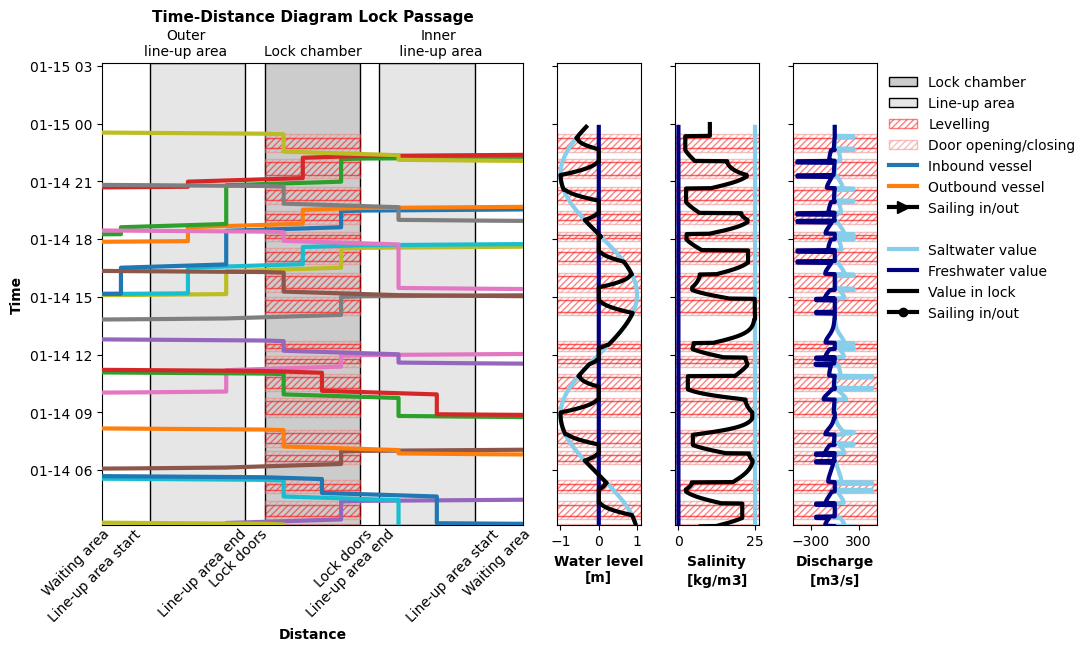

In [20]:
delays = False
entering_leaving = False

distance_to_lock_edge_start = lock_1.env.vessel_traffic_service.provide_sailing_distance_over_route(vessels[0],nx.dijkstra_path(FG,'Node_1','Node_49'))['Distance'].sum()
distance_to_lock_edge_end = lock_1.env.vessel_traffic_service.provide_sailing_distance_over_route(vessels[0],nx.dijkstra_path(FG,'Node_1','Node_50'))['Distance'].sum()
lock_outer_doors = distance_to_lock_edge_start+lock_1.distance_doors1_from_first_waiting_area
lock_inner_doors = distance_to_lock_edge_end-lock_1.distance_doors1_from_first_waiting_area
lineup_1_start = lock_outer_doors - lineup_area_1.distance_to_lock_doors - lineup_area_1.lineup_length
lineup_1_end = lock_outer_doors - lineup_area_1.distance_to_lock_doors
lineup_2_start = lock_inner_doors + lineup_area_2.distance_to_lock_doors + lineup_area_2.lineup_length
lineup_2_end = lock_inner_doors + lineup_area_2.distance_to_lock_doors

fig,axes = plt.subplots(1,4,figsize=[10,6],gridspec_kw = {'width_ratios':[5,1,1,1]})
ax = axes[0]
for time,distance in zip(times,distances):
    ax.plot(distance,time,linewidth=3,zorder=3)
vessel1, = ax.plot([-1,-1],color='C0',linewidth=3)
vessel2, = ax.plot([-1,-1],color='C1',linewidth=3)
for _vessel_ in vessels:
    vessel_df = pd.DataFrame(_vessel_.log)
    if len(vessel_df) < 120:
        continue
    arrival_time = datetime.datetime.fromtimestamp(_vessel_.arrival_time)
    if _vessel_.route[0] == 'Node_98':
        sail_in_time_vessel_2 = pd.DataFrame(_vessel_.log).loc[_vessel_.log['Action'].index('Sailing to first set of lock doors stop')].Time
        sail_out_time_vessel_2 = pd.DataFrame(_vessel_.log).loc[_vessel_.log['Action'].index('Sailing to second set of lock doors stop')].Time
        if entering_leaving:
            ax.plot(lock_inner_doors-40,sail_in_time_vessel_2+pd.Timedelta(40/4,'s'),'C1',marker='<',markersize=8)
            ax.plot(lock_outer_doors-40,sail_out_time_vessel_2+pd.Timedelta(40/4,'s'),'C1',marker='<',markersize=8)
        if delays:
            ax.plot([final_geometry.length,0],[arrival_time,arrival_time+pd.Timedelta(int(final_geometry.length/4),'s')],color='C1',linestyle='--',linewidth=2)
            passage_lineup_start = vessel_df.loc[_vessel_.log['Action'].index('Sailing to line-up area start')].Time
            passage_lineup_stop = vessel_df.loc[_vessel_.log['Action'].index('Sailing to line-up area stop')].Time
            delayed_arrival = 0.8*(passage_lineup_stop-passage_lineup_start)+passage_lineup_start
            normal_arrival = pd.Timedelta((distance_to_lock_edge_start+2000*0.8)/4,'s')+datetime.datetime.fromtimestamp(_vessel_.arrival_time)
            annotate_location = 0.8*(lineup_1_start-lineup_1_end)+lineup_1_end
            ax.annotate('', xy=(annotate_location, delayed_arrival), xycoords='data',
                        xytext=(annotate_location, normal_arrival), textcoords='data',
                        arrowprops={'arrowstyle': '<->'})
            waiting_time = pd.Timedelta(int((delayed_arrival-normal_arrival).total_seconds()/60),'min')
            hours,remainder = divmod(waiting_time.seconds, 3600)
            minutes,_ = divmod(remainder, 60)
            annotate_text_location = 0.5*(delayed_arrival-normal_arrival)+normal_arrival
            ax.annotate(r'$\mathbf{Delay\ time}$'+':\n'+'{:02} hrs {:02} mins'.format(int(hours), int(minutes)), xy=(50+annotate_location,annotate_text_location),
                        xycoords='data',xytext=(5, 0), textcoords='offset points', rotation=90,verticalalignment='center',horizontalalignment='center',color='C1')        

    else:
        sail_in_time_vessel_1 = pd.DataFrame(_vessel_.log).loc[_vessel_.log['Action'].index('Sailing to first set of lock doors stop')].Time
        sail_out_time_vessel_1 = pd.DataFrame(_vessel_.log).loc[_vessel_.log['Action'].index('Sailing to second set of lock doors stop')].Time
        if entering_leaving:
            ax.plot(lock_outer_doors+40,sail_in_time_vessel_1+pd.Timedelta(40/4,'s'),'C0',marker='>',markersize=8)
            ax.plot(lock_inner_doors+40,sail_out_time_vessel_1+pd.Timedelta(40/4,'s'),'C0',marker='>',markersize=8)
        if delays:
            ax.plot([0,final_geometry.length],[arrival_time,arrival_time+pd.Timedelta(int(final_geometry.length/4),'s')],color='C0',linestyle='--',linewidth=2)
            passage_lineup_start = vessel_df.loc[_vessel_.log['Action'].index('Sailing to line-up area start')].Time
            passage_lineup_stop = vessel_df.loc[_vessel_.log['Action'].index('Sailing to line-up area stop')].Time
            delayed_arrival = 0.8*(passage_lineup_stop-passage_lineup_start)+passage_lineup_start
            normal_arrival = pd.Timedelta((distance_to_lock_edge_start+2000*0.8)/4,'s')+datetime.datetime.fromtimestamp(_vessel_.arrival_time)
            annotate_location = 0.8*(lineup_2_start-lineup_2_end)+lineup_2_end
            ax.annotate('', xy=(annotate_location, delayed_arrival), xycoords='data',
                        xytext=(annotate_location, normal_arrival), textcoords='data',
                        arrowprops={'arrowstyle': '<->'})
            waiting_time = pd.Timedelta(int((delayed_arrival-normal_arrival).total_seconds()/60),'min')
            hours,remainder = divmod(waiting_time.seconds, 3600)
            minutes,_ = divmod(remainder, 60)
            annotate_text_location = 0.5*(delayed_arrival-normal_arrival)+normal_arrival
            ax.annotate(r'$\mathbf{Delay\ time}$'+':\n'+'{:02} hrs {:02} mins'.format(int(hours), int(minutes)), xy=(annotate_location-120,annotate_text_location),
                        xycoords='data',xytext=(5, 0), textcoords='offset points', rotation=270,verticalalignment='center',horizontalalignment='center',color='C0')        
        
lock_df = pd.DataFrame(lock_1.log)
for loc,info in lock_df.iterrows():
    if info.Action == 'Lock chamber converting stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        levelling, = ax.fill([lock_outer_doors,lock_outer_doors,lock_inner_doors,lock_inner_doors],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=2,color='none',edgecolor='red',alpha=0.5)
    if info.Action == 'Lock doors closing stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        door_opening_closing, = ax.fill([lock_outer_doors,lock_outer_doors,lock_inner_doors,lock_inner_doors],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
    if info.Action == 'Lock doors opening stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([lock_outer_doors,lock_outer_doors,lock_inner_doors,lock_inner_doors],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
    
ylim_min = lock_df.loc[0].Time-pd.Timedelta(1,'h')
ylim_max = lock_df.iloc[-7].Time+pd.Timedelta(5,'h')
ylim_min = ylim_max - pd.Timedelta(24,'h')
#ylim_max = ylim_min + pd.Timedelta(5,'h')
#ylim_min += pd.Timedelta(12,'h')
#ylim_max = ylim_min + pd.Timedelta(12,'h')

ax.set_ylim(ylim_min,ylim_max)
ylim = ax.get_ylim()
lineup_area_fill, = ax.fill([lineup_1_start,lineup_1_start,lineup_1_end,lineup_1_end],
        [ylim[0],ylim[1],ylim[1],ylim[0]],zorder=0,color=[0.9,0.9,0.9],edgecolor='k')
ax.fill([lineup_2_start,lineup_2_start,lineup_2_end,lineup_2_end],
        [ylim[0],ylim[1],ylim[1],ylim[0]],
        zorder=0,color=[0.9,0.9,0.9],edgecolor='k')
lock_chamber_fill, = ax.fill([lock_outer_doors,lock_outer_doors,lock_inner_doors,lock_inner_doors],
        [ylim[0],ylim[1],ylim[1],ylim[0]],
        zorder=0,color=[0.8,0.8,0.8],edgecolor='k')
ax.set_xlim([distance_to_lock_edge_start,distance_to_lock_edge_end])
ax.set_ylim(ylim)
ax.set_xticks([])

ax.text(50/2000, -0.025, 'Waiting area',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(200/2000, -0.025, 'Line-up area start',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(700/2000, -0.025, 'Line-up area end',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(800/2000, -0.025, 'Lock doors',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(1300/2000, -0.025, 'Lock doors',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(1400/2000, -0.025, 'Line-up area end',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(1900/2000, -0.025, 'Line-up area start',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(2050/2000, -0.025, 'Waiting area',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(400/2000,1.075,'Outer\nline-up area',verticalalignment='top',horizontalalignment='center',transform=ax.transAxes)
ax.text(1000/2000,1.075,'\nLock chamber',verticalalignment='top',horizontalalignment='center',transform=ax.transAxes)
ax.text(1600/2000,1.075,'Inner\n line-up area',verticalalignment='top',horizontalalignment='center',transform=ax.transAxes)
ax.set_xlabel('Distance',labelpad=70,fontweight='bold')
ax.set_ylabel('Time',fontweight='bold')
ax.set_title('Time-Distance Diagram Lock Passage',fontsize=11,fontweight='bold',pad=30)

ax = axes[1]
ax.set_facecolor('white')
ax.plot(hydrodynamic_data.sel(STATIONS=48)['Water level'].values,
        hydrodynamic_data.sel(STATIONS=48)['Water level'].TIME.values,
        color='skyblue',zorder=3,linewidth=3)
ax.plot(hydrodynamic_data.sel(STATIONS=49)['Water level'].values,
        hydrodynamic_data.sel(STATIONS=49)['Water level'].TIME.values,
        color='navy',zorder=3,linewidth=3)
lock_level, = ax.plot(lock_1.water_level.values,lock_1.water_level.TIME.values,zorder=4,linewidth=3,color='k')
ax.set_ylim(ylim)
ax.set_yticklabels([])
xlim_min,xlim_max = ax.get_xlim()
for loc,info in lock_df.iterrows():
    if info.Action == 'Lock chamber converting stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=2,color='none',edgecolor='red',alpha=0.5)
    if info.Action == 'Lock doors closing stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
    if info.Action == 'Lock doors opening stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
ax.set_xlim(xlim_min,xlim_max)
#ax.set_title('Lock\nChamber\nWater level',fontsize=11,fontweight='bold')
ax.set_xticks([-1,0,1])
ax.set_xlabel('Water level\n[m]',fontweight='bold')

ax = axes[2]
ax.set_facecolor('white')
ax.plot(hydrodynamic_data.sel(STATIONS=48)['Salinity'].values,
        hydrodynamic_data.sel(STATIONS=48)['Salinity'].TIME.values,
        color='skyblue',zorder=3,linewidth=3)
ax.plot(hydrodynamic_data.sel(STATIONS=49)['Salinity'].values,
        hydrodynamic_data.sel(STATIONS=49)['Salinity'].TIME.values,
        color='navy',zorder=3,linewidth=3)
ax.plot(lock_1.salinity.values,lock_1.salinity.TIME.values,zorder=4,linewidth=3,color='k')
ax.set_ylim(ylim)
ax.set_yticklabels([])
xlim_min,xlim_max = ax.get_xlim()
for loc,info in lock_df.iterrows():
    if info.Action == 'Lock chamber converting stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=2,color='none',edgecolor='red',alpha=0.5)
    if info.Action == 'Lock doors closing stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
    if info.Action == 'Lock doors opening stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
ax.set_xlim(xlim_min,xlim_max)
#ax.set_title('Lock\nChamber\nSalinity',fontsize=11,fontweight='bold')
ax.set_xticks([0,25])
ax.set_xlabel('Salinity\n'+r'[kg/m$\mathregular{3}$]',fontweight='bold')

ax = axes[3]
ax.set_facecolor('white')
freshwater, = ax.plot(lock_1.discharge_fresh.values,lock_1.discharge_fresh.TIME.values,color='navy',linewidth=3,zorder=4)
if entering_leaving:
    ax.plot(lock_1.discharge_fresh.interp(TIME=sail_in_time_vessel_1).values,sail_in_time_vessel_1,marker='o',color='navy',markersize=6)
    ax.plot(lock_1.discharge_fresh.interp(TIME=sail_out_time_vessel_1).values,sail_out_time_vessel_1,marker='o',color='navy',markersize=6)
saltwater, = ax.plot(lock_1.discharge_saline.values,lock_1.discharge_saline.TIME.values,color='skyblue',linewidth=3,zorder=3)
if entering_leaving:
    ax.plot(lock_1.discharge_saline.interp(TIME=sail_in_time_vessel_2).values,sail_in_time_vessel_2,marker='o',color='skyblue',markersize=6)
    ax.plot(lock_1.discharge_saline.interp(TIME=sail_out_time_vessel_2).values,sail_out_time_vessel_2,marker='o',color='skyblue',markersize=6)
sail_in_out_arrow, = ax.plot([0,0],color='k',marker='>',markersize=8,linewidth=3)
sail_in_out_point, = ax.plot([0,0],color='k',marker='o',markersize=6,linewidth=3)

ax.set_ylim(ylim)
ax.set_yticklabels([])
xlim_min,xlim_max = ax.get_xlim()
for loc,info in lock_df.iterrows():
    if info.Action == 'Lock chamber converting stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=2,color='none',edgecolor='red',alpha=0.5)
    if info.Action == 'Lock doors closing stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
    if info.Action == 'Lock doors opening stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
ax.set_xlim(xlim_min,xlim_max)
#ax.set_title('Lock\nChamber\nDischarge',fontsize=11,fontweight='bold')
ax.legend([lock_chamber_fill,lineup_area_fill,levelling,door_opening_closing,vessel1,vessel2,sail_in_out_arrow,mpl.patches.Patch(color='none'),
           saltwater,freshwater,lock_level,sail_in_out_point],
          ['Lock chamber','Line-up area','Levelling','Door opening/closing','Inbound vessel','Outbound vessel','Sailing in/out','',
           'Saltwater value','Freshwater value','Value in lock','Sailing in/out'],
          bbox_to_anchor=[1,1],frameon=False,prop={'size':10})
ax.set_xticks([-300,300])
ax.set_xlabel('Discharge\n'+r'[m$\mathregular{3}$/s]',fontweight='bold');
axes[0].set_xlim([distance_to_lock_edge_start-100,distance_to_lock_edge_end+100])
#fig.savefig('Basic_lock_passage.svg',dpi=500,format='svg',bbox_inches='tight');

In [21]:
lineup_area_1.line_up_area['Node_49'].users

[]

In [22]:
lineup_area_2.line_up_area['Node_50'].capacity

100

In [23]:
lock_df.iloc[-80:-30]

,Time,Location,Action,Status
1594,2019-01-14 06:48:20.426313,Node_50,Lock doors opening start,{}
1595,2019-01-14 06:58:20.426313,Node_50,Lock doors opening stop,{}
1596,2019-01-14 07:13:48.204091,Node_50,Lock doors closing start,{}
1597,2019-01-14 07:23:48.204091,Node_50,Lock doors closing stop,{}
1598,2019-01-14 07:23:48.204091,Node_50,Lock chamber converting start,{}
1599,2019-01-14 07:54:48.204091,Node_49,Lock chamber converting stop,{}
1600,2019-01-14 07:54:48.204091,Node_49,Lock doors opening start,{}
1601,2019-01-14 08:04:48.204091,Node_49,Lock doors opening stop,{}
1602,2019-01-14 08:46:06.938965,Node_49,Lock doors closing start,{}
1603,2019-01-14 08:56:06.938965,Node_49,Lock doors closing stop,{}


In [24]:
vessels[202].output['route']

['Node_98',
 'Node_97',
 'Node_96',
 'Node_95',
 'Node_94',
 'Node_93',
 'Node_92',
 'Node_91',
 'Node_90',
 'Node_89',
 'Node_88',
 'Node_87',
 'Node_86',
 'Node_85',
 'Node_84',
 'Node_83',
 'Node_82',
 'Node_81',
 'Node_80',
 'Node_79',
 'Node_78',
 'Node_77',
 'Node_76',
 'Node_75',
 'Node_74',
 'Node_73',
 'Node_72',
 'Node_71',
 'Node_70',
 'Node_69',
 'Node_68',
 'Node_67',
 'Node_66',
 'Node_65',
 'Node_64',
 'Node_63',
 'Node_62',
 'Node_61',
 'Node_60',
 'Node_59',
 'Node_58',
 'Node_57',
 'Node_56',
 'Node_55',
 'Node_54',
 'Node_53',
 'Node_52',
 'Node_51',
 'Node_50',
 'Node_49',
 'Node_48',
 'Node_47',
 'Node_46',
 'Node_45',
 'Node_44',
 'Node_43',
 'Node_42',
 'Node_41',
 'Node_40',
 'Node_39',
 'Node_38',
 'Node_37',
 'Node_36',
 'Node_35',
 'Node_34',
 'Node_33',
 'Node_32',
 'Node_31',
 'Node_30',
 'Node_29',
 'Node_28',
 'Node_27',
 'Node_26',
 'Node_25',
 'Node_24',
 'Node_23',
 'Node_22',
 'Node_21',
 'Node_20',
 'Node_19',
 'Node_18',
 'Node_17',
 'Node_16',
 'No

In [25]:
for loc,info in lock_df.iterrows():
    if info.Action == 'Lock chamber converting start':
        if lock_df.loc[loc-1,'Action'] != 'Lock doors closing stop':
            print(loc)
        if lock_df.loc[loc+1,'Action'] != 'Lock chamber converting stop':
            print(loc)

In [26]:
lock_df = pd.DataFrame(lock_1.log)
lock_df.head(n=20)

,Time,Location,Action,Status
0,2019-01-01 13:11:20.938305,Node_50,Lock doors closing start,{}
1,2019-01-01 13:21:20.938305,Node_50,Lock doors closing stop,{}
2,2019-01-01 13:21:20.938305,Node_50,Lock chamber converting start,{}
3,2019-01-01 13:55:20.938305,Node_49,Lock chamber converting stop,{}
4,2019-01-01 13:55:20.938305,Node_49,Lock doors opening start,{}
5,2019-01-01 14:05:20.938305,Node_49,Lock doors opening stop,{}
6,2019-01-01 15:02:23.901914,Node_49,Lock doors closing start,{}
7,2019-01-01 15:12:23.901914,Node_49,Lock doors closing stop,{}
8,2019-01-01 15:12:23.901914,Node_49,Lock chamber converting start,{}
9,2019-01-01 15:50:23.901914,Node_50,Lock chamber converting stop,{}


In [27]:
salt_transport_df = pd.DataFrame(columns=['Side','Levelling start','Levelling stop','Door Open','Door Closed',
                                          'Water level start levelling','Water level stop levelling',
                                          'Ship Volume Left','Ship Volume Entered'])
for loc,info in lock_df.iterrows():
    if info.Action == 'Lock doors closing stop' and loc > 2:
        levelling_start = lock_df.loc[loc-5].Time
        levelling_stop = lock_df.loc[loc-4].Time
        index_levelling_start = np.absolute(lock_1.water_level.TIME.values-np.datetime64(levelling_start)).argmin()
        index_levelling_stop = np.absolute(lock_1.water_level.TIME.values-np.datetime64(levelling_stop)).argmin()
        water_level_start_levelling = lock_1.water_level[index_levelling_start].values
        water_level_stop_levelling = lock_1.water_level[index_levelling_stop].values
        door_open = (lock_df.loc[loc-2].Time-lock_df.loc[loc-3].Time)/2+lock_df.loc[loc-3].Time
        door_closed = (info.Time-lock_df.loc[loc-1].Time)/2+lock_df.loc[loc-1].Time
        volume_loss = 0
        volume_transported = 0
        for _vessel_ in vessels:
            vessel_df = pd.DataFrame(_vessel_.log)
            if vessel_df.empty:
                continue
            vessel_df_door_open_time = vessel_df[(vessel_df.Time > door_open - datetime.timedelta(seconds=lock_1.doors_open)) & 
                                                 (vessel_df.Time < door_closed + datetime.timedelta(seconds=lock_1.doors_close))]
            if not vessel_df_door_open_time.empty and vessel_df_door_open_time.iloc[0].Action == 'Passing lock stop':
                volume_loss += _vessel_.L*_vessel_.B*_vessel_.T
            if not vessel_df_door_open_time.empty and vessel_df_door_open_time.iloc[-1].Action == 'Passing lock start':
                volume_transported += _vessel_.L*_vessel_.B*_vessel_.T
        salt_transport_df.loc[len(salt_transport_df),:] = [info.Location,levelling_start,levelling_stop,door_open,door_closed,
                                                           water_level_start_levelling,water_level_stop_levelling,
                                                           volume_loss,volume_transported]

In [28]:
salt_transport_df['Salt Exchange [kg]'] = 0.0
salt_transport_df['Salt Transported [kg]'] = 0.0
salt_transport_df['Freshwater Exchange [m3]'] = 0.0
salt_transport_df['Freshwater Transported [m3]'] = 0.0
salt_transport_df['Freshwater Levelled [m3]'] = 0.0

for loc,info in salt_transport_df.iterrows():
    if info.Side == 'Node_50':
        salinity_difference = lock_1.salinity.interp(TIME=info['Door Open']).values-np.nanmax([0,lock_1.salinity.interp(TIME=info['Door Closed']).values])
        salt_transport_df.loc[loc,'Salt Exchange [kg]'] = salinity_difference*lock_1.lock_length*lock_1.lock_width*lock_1.lock_depth
        salt_transport_df.loc[loc,'Salt Transported [kg]'] = np.nanmax([0,lock_1.salinity.interp(TIME=info['Door Closed']).values])*info['Ship Volume Entered']
        salt_transport_df.loc[loc,'Freshwater Exchange [m3]'] = lock_1.lock_length*lock_1.lock_width*lock_1.lock_depth*np.tanh((info['Door Closed']-info['Door Open']).total_seconds()/(2*lock_1.lock_length/(0.5*np.sqrt(9.81*0.8*salinity_difference*lock_1.lock_depth/(1000+0.8*25/2)))))
        salt_transport_df.loc[loc,'Freshwater Transported [m3]'] = info['Ship Volume Left']
        water_levelling_difference = info['Water level stop levelling']-info['Water level start levelling']
        if water_levelling_difference > 0:
            salt_transport_df['Freshwater Levelled [m3]'] = water_levelling_difference

In [29]:
(salt_transport_df['Salt Transported [kg]'].sum()+salt_transport_df['Salt Exchange [kg]'].sum())/(25*lock_1.lock_length*lock_1.lock_width*lock_1.lock_depth)

61.11837092569657

In [30]:
delay_df = pd.DataFrame(columns=['Delay'])
for _vessel_ in vessels:
    vessel_df = pd.DataFrame(_vessel_.log)
    start_df = vessel_df[vessel_df.Action == 'Sailing from node Node_49 to node Node_50 start']
    stop_df = vessel_df[vessel_df.Action == 'Sailing from node Node_49 to node Node_50 stop']
    if stop_df.empty or start_df.empty:
        continue
    start_time = start_df.Time.iloc[0]
    stop_time = stop_df.Time.iloc[0]
    delay = stop_time-start_time-pd.Timedelta(FG.edges['Node_49','Node_50',0]['Info']['length']/vessels[0].v,'s')
    delay_df.loc[_vessel_.name,'Delay'] = delay

In [31]:
average_vessel_delay = delay_df.Delay.sum()/len(delay_df)

In [32]:
average_vessel_delay

Timedelta('0 days 01:59:51.735554051')

In [33]:
len(lock_df)/6

279.0